#  Framework for Predictive Modeling of Sea Surface Currents Velocity 'v' (North-South) using GRU

This Notebook is an analysis and prediction of sea surface currents (SSC) velocity using an GRU Model. The primary focus is on processing, visualizing, and predicting based on historical sea surface current data. This pipeline aims to provide a comprehensive workflow from data processing to real-life future predictions, facilitating deeper insights into sea surface currents and their potential impacts.

## Overview
- **Data Preparation**: Loading and cleaning of time-series data from NetCDF files to create a structured dataset suitable for analysis.
- **Geospatial Visualization**: Mapping sea surface current data and identify areas of interest.
- **Data Filtering**: Narrowing down the dataset to focus on specific geographic regions and time frames for detailed analysis.
- **Predictive Modeling**: Developing GRU models to forecast future sea surface current velocities based on historical data.
- **Evaluation**: Comparing predicted values against actual data to assess the accuracy and effectiveness of the models.
- **Output**: Aggregating all predictions and converting them into a format suitable for further analysis or integration into a Lagrangian Model.

### Import Necessary Libraries

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError
from keras.models import load_model

### Suppress Future Warnings


In [2]:
import warnings

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Importing & Opening the Data

Load and open the sea surface current dataset for subsequent analysis and modeling. This file has hourly data from 1st January 2020 till 1st August 2023

In [3]:
# Load the dataset
netcdf_file_path = "Data/model_IO/final_SSC_Data.nc"

# Open the dataset
dataset = xr.open_dataset(netcdf_file_path)

### Data Preparation 

1. **Conversion and Index Resetting**: The dataset is converted to a Pandas DataFrame and the index is reset.
2. **Column Removal**: Unnecessary columns ('stdu', 'stdv', 'cov', 'velo', 'head') that are not needed are removed.
3. **NaN Value Removal**: Rows containing NaN values in the 'u' and 'v' columns are removed.
4. **Datetime Conversion**: The 'time' column is converted to a datetime format.
5. **Display**: Finally, the cleaned DataFrame is displayed to verify the successful preprocessing steps.

In [4]:
# Convert the dataset to a pandas DataFrame and reset the index 
df = dataset.to_dataframe().reset_index()

# Drop unnecessary columns from the DataFrame that are not needed
df = df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Drop rows with NaN values in 'u' and 'v' columns to ensure data integrity for analysis
df.dropna(subset=['u', 'v'],inplace=True)

# Convert the 'time' column to datetime format for time series analysis
df.index = pd.to_datetime(df['time'], format='%d-%m-%Y %H:%M:%S')

# Display the DataFrame
df

time        lat      lon         u  \
time                                                                    
2020-02-25 15:00:00 2020-02-25 15:00:00  35.900600  14.5692  0.224436   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.900600  14.6097  0.225030   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.900600  14.6503  0.219380   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.900600  14.6908  0.192193   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.900600  15.0965 -0.088404   
...                                 ...        ...      ...       ...   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.880199  14.0419 -0.179297   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.880199  14.0824 -0.187970   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.880199  14.1230 -0.184672   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.880199  14.1635 -0.228134   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.880199  14.2041 -0.225346   

                            v  
time                           
2020-02-25 15:00:00 -0.204129  
2020-02-25 15:00:00 -0.220144  
2020-02-25 15:00:00 -0.229340  
2020-02-25 15:00:00 -0.223198  
2020-02-25 15:00:00 -0.160217  
...                       ...  
2023-08-01 23:00:00 -0.109355  
2023-08-01 23:00:00 -0.150195  
2023-08-01 23:00:00 -0.175530  
2023-08-01 23:00:00 -0.281021  
2023-08-01 23:00:00 -0.278797  

[17230832 rows x 5 columns]

### Geospatial Visualization

- **Boundaries & Interest Area**: Set the coordinates for the specific geographic boundaries and a polygon to highlight key area on the map.
- **Map Setup**: Initialize a map with features like land, coastlines, and borders for context.
- **Data Points**: Plot data points within the set boundaries to visualize the distribution of sea surface currents.
- **Highlight Area**: Draw a red polygon to emphasize the area of interest on the map.

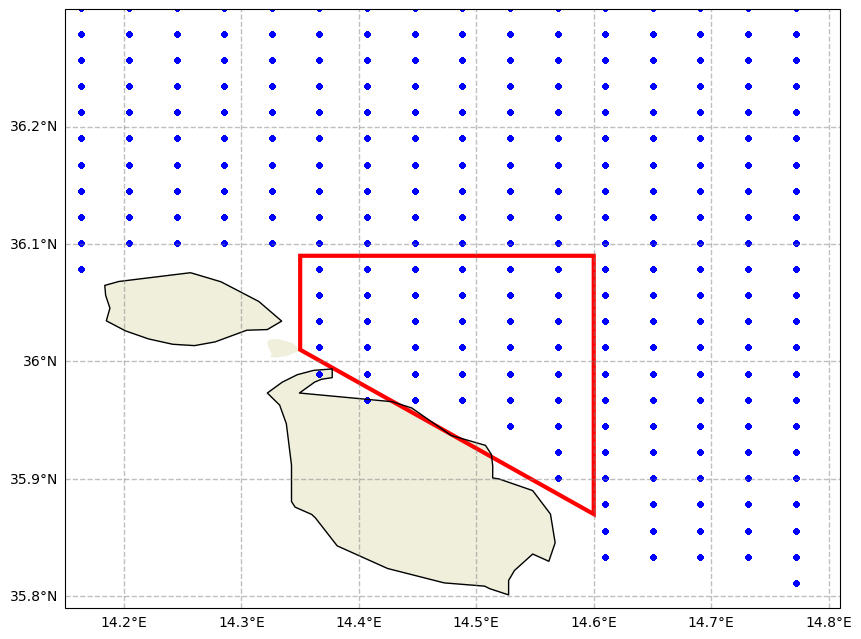

In [5]:
# Define the boundaries for the map 
boundaries = {
    'min_lon': 14.15,  
    'max_lon': 14.81,  
    'min_lat': 35.79,  
    'max_lat': 36.3    
}

# Define the vertices of a polygon to highlight a specific area on the map
polygon_coordinates = [
    (14.6, 35.87),
    (14.35, 36.01),
    (14.35, 36.09),
    (14.6, 36.09),
    (14.6, 35.87)
]

# Initialize a matplotlib figure with Cartopy for data visualization
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the viewing extent of the map using the defined boundaries
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# Add features to the map for land, coastlines, and country borders for context
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot all data points from the dataframe within the defined geographic boundaries
ax.scatter(df['lon'], df['lat'], s=10, color='blue', marker='o', alpha=0.5, transform=ccrs.Geodetic())

# Draw a red polygon using the defined coordinates to highlight a specific area on the map
red_polygon = mpatches.Polygon(polygon_coordinates, closed=True, edgecolor='red', facecolor='none', linewidth=3, transform=ccrs.Geodetic())
ax.add_patch(red_polygon)

# Add gridlines to the map
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Display the plot
plt.show()

### Geospatial Filtering

Filter the dataset to focus on the area of interest:

- **Filtering**: Apply the polygon as a filter to select only data points located inside this area.
- **Visualization**: Plot the filtered data on a map to visually confirm the focus area, marking points within the polygon in red for clarity.
- **Map Features**: Enhance the map with features like land, coastlines, and borders for better context.
- **Final View**: Display the map with the filtered points.

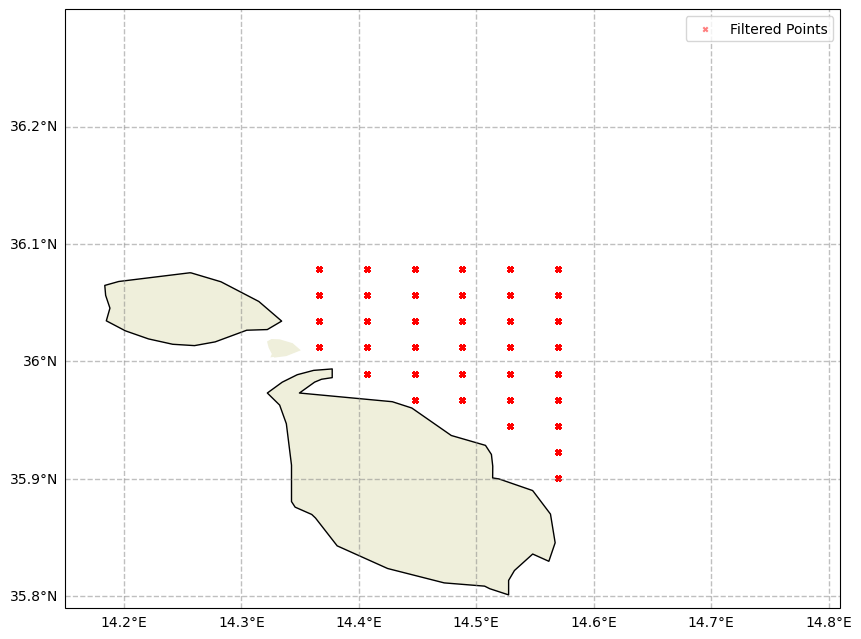

In [6]:
# Convert the list of polygon coordinates to a Path object
polygon_path = mpath.Path(polygon_coordinates)

# Use the Path object to filter points in the DataFrame that lie inside the polygon
inside_polygon = df.apply(lambda row: polygon_path.contains_point((row['lon'], row['lat'])), axis=1)
df_inside_polygon = df[inside_polygon]

# Initialize a new matplotlib figure with Cartopy for mapping, specifying the projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent of the map to the defined geographic boundaries
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# Add land, coastlines, and country borders to the map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the points that are located within the defined polygon in red
scatter = ax.scatter(df_inside_polygon['lon'], df_inside_polygon['lat'], s=10, color='red', marker='x', alpha=0.5, transform=ccrs.Geodetic(), label='Filtered Points')

# Add gridlines and labels to the map
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add a legend to the plot to explain the red "X" markers
ax.legend(handles=[scatter], loc='upper right')

# Display the plot
plt.show()

### Selecting the coordinates inside the polygon

Identify and processes data points located within the selected area:

- **Path Creation**: Transform the polygon coordinates into a Path object for spatial filtering.
- **Coordinate Pairing**: Combine 'lon' and 'lat' from the DataFrame into coordinate tuples.
- **Spatial Filtering**: Apply the Path object to select only points inside the polygon.
- **Duplicate Removal**: Eliminate duplicate points to ensure unique data entries.
- **Count and Display**: Calculate and print the total number of unique points inside the polygon, along with their coordinates.

In [7]:
# Convert the polygon coordinates to a Path object 
polygon_path = mpath.Path(polygon_coordinates)

# Combine longitude and latitude columns from the DataFrame into a list of tuples for each point
coordinates = list(zip(df['lon'], df['lat']))

# Create a mask to identify which points fall within the defined polygon by checking each point
inside_mask = [polygon_path.contains_point(coord) for coord in coordinates]

# Use the mask to filter the DataFrame, keeping only points that are inside the polygon
df_inside_polygon = df[inside_mask]

# Remove potential duplicate entries based on their longitude and latitude
df_inside_polygon = df_inside_polygon.drop_duplicates(subset=['lon', 'lat'])

# Calculate the number of unique points found inside the polygon
num_points_inside_polygon = df_inside_polygon.shape[0]
print(f"Total number of points inside the polygon: {num_points_inside_polygon}\n")
print("Coordinates of the points inside the polygon:")

# Iterate over each coordinate pair inside the polygon and print them out
coordinates_inside = df_inside_polygon[['lon', 'lat']].values
for lon, lat in coordinates_inside:
    print(f"({lon}, {lat})")

Total number of points inside the polygon: 37

Coordinates of the points inside the polygon:
(14.569199562072754, 35.90060043334961)
(14.569199562072754, 35.92279815673828)
(14.569199562072754, 35.945098876953125)
(14.528599739074707, 35.96730041503906)
(14.569199562072754, 35.96730041503906)
(14.447500228881836, 35.989601135253906)
(14.48799991607666, 35.989601135253906)
(14.528599739074707, 35.989601135253906)
(14.569199562072754, 35.989601135253906)
(14.447500228881836, 36.01190185546875)
(14.48799991607666, 36.01190185546875)
(14.528599739074707, 36.01190185546875)
(14.569199562072754, 36.01190185546875)
(14.447500228881836, 36.03409957885742)
(14.48799991607666, 36.03409957885742)
(14.528599739074707, 36.03409957885742)
(14.569199562072754, 36.03409957885742)
(14.447500228881836, 36.056400299072266)
(14.48799991607666, 36.056400299072266)
(14.528599739074707, 36.056400299072266)
(14.569199562072754, 36.056400299072266)
(14.366399765014648, 36.07870101928711)
(14.406900405883789, 3

### Create a Data Frame for the coordinates inside the polygon

In [8]:
# Convert 'inside_mask' to a pandas Series to use as a boolean indexer
inside_series = pd.Series(inside_mask, index=df.index)

# Filter the original DataFrame using the boolean Series
final_df = df[inside_series]

# Display the final DataFrame
final_df

time        lat      lon         u  \
time                                                                    
2020-02-25 15:00:00 2020-02-25 15:00:00  35.900600  14.5692  0.224436   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.922798  14.5692  0.209744   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.945099  14.5692  0.165433   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.967300  14.5286  0.139062   
2020-02-25 15:00:00 2020-02-25 15:00:00  35.967300  14.5692  0.162474   
...                                 ...        ...      ...       ...   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.078701  14.4069  0.148599   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.078701  14.4475  0.153244   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.078701  14.4880  0.165081   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.078701  14.5286  0.169408   
2023-08-01 23:00:00 2023-08-01 23:00:00  36.078701  14.5692  0.178463   

                            v  
time                           
2020-02-25 15:00:00 -0.204129  
2020-02-25 15:00:00 -0.180382  
2020-02-25 15:00:00 -0.158304  
2020-02-25 15:00:00 -0.155931  
2020-02-25 15:00:00 -0.140758  
...                       ...  
2023-08-01 23:00:00 -0.234722  
2023-08-01 23:00:00 -0.216512  
2023-08-01 23:00:00 -0.183771  
2023-08-01 23:00:00 -0.206215  
2023-08-01 23:00:00 -0.222228  

[366357 rows x 5 columns]

### Data Extraction for Selected Coordinates

Extracting and saving specific sea surface current data for predefined locations within our area of interest:

- **Selected Coordinates**: List the specific latitude and longitude pairs.
- **Data Extraction**: For each pair, filter the main dataset to obtain the relevant data points.
- **File Saving**: Convert latitude and longitude to a format suitable for filenames and save the data as CSV files.

Each data point's latitude and longitude are converted to remove decimal points, ensuring valid filenames. This process results in a set of CSV files, each corresponding to a unique location within the selected polygon.

In [9]:
# Directory to save the files
save_directory = "Data/coordinate_data_frames"
os.makedirs(save_directory, exist_ok=True)

# Coordinates of the points inside the polygon
coordinates_inside = [
    (14.569199562072754, 35.90060043334961),
    (14.569199562072754, 35.92279815673828),
    (14.569199562072754, 35.945098876953125),
    (14.528599739074707, 35.96730041503906),
    (14.569199562072754, 35.96730041503906),
    (14.447500228881836, 35.989601135253906),
    (14.48799991607666, 35.989601135253906),
    (14.528599739074707, 35.989601135253906),
    (14.569199562072754, 35.989601135253906),
    (14.447500228881836, 36.01190185546875),
    (14.48799991607666, 36.01190185546875),
    (14.528599739074707, 36.01190185546875),
    (14.569199562072754, 36.01190185546875),
    (14.447500228881836, 36.03409957885742),
    (14.48799991607666, 36.03409957885742),
    (14.528599739074707, 36.03409957885742),
    (14.569199562072754, 36.03409957885742),
    (14.447500228881836, 36.056400299072266),
    (14.48799991607666, 36.056400299072266),
    (14.528599739074707, 36.056400299072266),
    (14.569199562072754, 36.056400299072266),
    (14.366399765014648, 36.07870101928711),
    (14.406900405883789, 36.07870101928711),
    (14.447500228881836, 36.07870101928711),
    (14.48799991607666, 36.07870101928711),
    (14.528599739074707, 36.07870101928711),
    (14.569199562072754, 36.07870101928711),
    (14.528599739074707, 35.945098876953125),
    (14.406900405883789, 36.03409957885742),
    (14.406900405883789, 36.056400299072266),
    (14.406900405883789, 36.01190185546875),
    (14.366399765014648, 36.03409957885742),
    (14.366399765014648, 36.056400299072266),
    (14.48799991607666, 35.96730041503906),
    (14.406900405883789, 35.989601135253906,),
    (14.366399765014648, 36.01190185546875),
    (14.447500228881836, 35.96730041503906)
]

# Loop through each pair of coordinates along with an index
for index, (lon, lat) in enumerate(coordinates_inside, start=1):
    # Print the current pair being processed
    print(f"Processing pair {index}: (lat: {lat}, lon: {lon})")

    # Filter the DataFrame for the exact coordinates
    df_point = final_df[(final_df['lat'] == lat) & (final_df['lon'] == lon)]

    # Check if any data points were found for the current pair
    if df_point.empty:
        print(f"No data points found for (lat: {lat}, lon: {lon})")
    else:
        print(f"Found {df_point.shape[0]} data points for (lat: {lat}, lon: {lon})")

    # Format the latitude and longitude to remove decimal points and replace with underscores
    lat_formatted = str(lat).replace('.', '_')
    lon_formatted = str(lon).replace('.', '_')

    # Create a unique filename for each pair of coordinates
    filename = f"{index}_{lat_formatted}_{lon_formatted}.csv"
    filepath = os.path.join(save_directory, filename)

    # Save the filtered DataFrame to a CSV file
    df_point.to_csv(filepath, index=False)

    # Confirm that the file has been saved
    print(f"Saved data for (lat: {lat}, lon: {lon}) as {filename}\n")

print("All data processing complete.")
print("="*175)

Processing pair 1: (lat: 35.90060043334961, lon: 14.569199562072754)
Found 6694 data points for (lat: 35.90060043334961, lon: 14.569199562072754)
Saved data for (lat: 35.90060043334961, lon: 14.569199562072754) as 1_35_90060043334961_14_569199562072754.csv

Processing pair 2: (lat: 35.92279815673828, lon: 14.569199562072754)
Found 6804 data points for (lat: 35.92279815673828, lon: 14.569199562072754)
Saved data for (lat: 35.92279815673828, lon: 14.569199562072754) as 2_35_92279815673828_14_569199562072754.csv

Processing pair 3: (lat: 35.945098876953125, lon: 14.569199562072754)
Found 8293 data points for (lat: 35.945098876953125, lon: 14.569199562072754)
Saved data for (lat: 35.945098876953125, lon: 14.569199562072754) as 3_35_945098876953125_14_569199562072754.csv

Processing pair 4: (lat: 35.96730041503906, lon: 14.528599739074707)
Found 9458 data points for (lat: 35.96730041503906, lon: 14.528599739074707)
Saved data for (lat: 35.96730041503906, lon: 14.528599739074707) as 4_35_967

### Model Preparation, Training & Evaluation

- **Model Storage**: Set up a directory to save the trained models.
- **Data Preparation**: List and load all coordinate-specific CSV files that were prepared earlier.
- **Feature Selection**: For each dataset, 'u' and 'v' values are chosen as features with 'v' set as the target variable.
- **Time Series Generation**: Construct time series generators, utilizing the last 72 hours (3 days) of data to predict the 'v' value for the next hour. This historical data frame helps the model understand temporal patterns.
- **Early Stopping**: Integrate early stopping to halt training when the validation loss stops improving, preventing overfitting and saving computational resources.
- **Model Architecture**: Build the GRU (Gated Recurrent Unit) network. The model architecture includes several layers with dropout rates to manage overfitting.
- **Training Process**: Train the model on the generated time series data, monitoring both training and validation metrics.
- **Prediction and Evaluation**:
    - **Prediction**: After training, apply the model to the test set to forecast future 'v' values.
    - **Evaluation Metrics**: Use three key metrics to evaluate model performance:
        - **Mean Squared Error (MSE)**: Represents the average of the squares of the errors between actual and predicted values. Lower values indicate better performance.
        - **Mean Absolute Error (MAE)**: Measures the average magnitude of errors between pairs of actual and predicted values, without considering their direction. Lower MAE values signify better accuracy.
        - **Root Mean Squared Error (RMSE)**: The square root of MSE, providing error metrics in the same units as the data, making interpretation straightforward. Lower RMSE values denote better fit.
    - **Visualization**: Plot actual vs. predicted 'v' values to visually assess the model's prediction accuracy and understand its real-world applicability.

['1_35_90060043334961_14_569199562072754.csv', '2_35_92279815673828_14_569199562072754.csv', '3_35_945098876953125_14_569199562072754.csv', '4_35_96730041503906_14_528599739074707.csv', '5_35_96730041503906_14_569199562072754.csv', '6_35_989601135253906_14_447500228881836.csv', '7_35_989601135253906_14_48799991607666.csv', '8_35_989601135253906_14_528599739074707.csv', '9_35_989601135253906_14_569199562072754.csv', '10_36_01190185546875_14_447500228881836.csv', '11_36_01190185546875_14_48799991607666.csv', '12_36_01190185546875_14_528599739074707.csv', '13_36_01190185546875_14_569199562072754.csv', '14_36_03409957885742_14_447500228881836.csv', '15_36_03409957885742_14_48799991607666.csv', '16_36_03409957885742_14_528599739074707.csv', '17_36_03409957885742_14_569199562072754.csv', '18_36_056400299072266_14_447500228881836.csv', '19_36_056400299072266_14_48799991607666.csv', '20_36_056400299072266_14_528599739074707.csv', '21_36_056400299072266_14_569199562072754.csv', '22_36_078701019

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 43s 523ms/step - loss: 0.0114 - mean_absolute_error: 0.0808 - val_loss: 0.0109 - val_mean_absolute_error: 0.0688
Epoch 2/100
73/73 [==============================] - 27s 369ms/step - loss: 0.0077 - mean_absolute_error: 0.0621 - val_loss: 0.0110 - val_mean_absolute_error: 0.0690
Epoch 3/100
73/73 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0557INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 30s 415ms/step - loss: 0.0066 - mean_absolute_error: 0.0557 - val_loss: 0.0098 - val_mean_absolute_error: 0.0605
Epoch 4/100
73/73 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0531INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 35s 475ms/step - loss: 0.0063 - mean_absolute_error: 0.0531 - val_loss: 0.0096 - val_mean_absolute_error: 0.0594
Epoch 5/100
73/73 [==============================] - 30s 413ms/step - loss: 0.0062 - mean_absolute_error: 0.0526 - val_loss: 0.0105 - val_mean_absolute_error: 0.0645
Epoch 6/100
73/73 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0523INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 34s 468ms/step - loss: 0.0062 - mean_absolute_error: 0.0523 - val_loss: 0.0095 - val_mean_absolute_error: 0.0590
Epoch 7/100
73/73 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0509INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 37s 509ms/step - loss: 0.0059 - mean_absolute_error: 0.0509 - val_loss: 0.0092 - val_mean_absolute_error: 0.0571
Epoch 8/100
73/73 [==============================] - 34s 465ms/step - loss: 0.0060 - mean_absolute_error: 0.0512 - val_loss: 0.0096 - val_mean_absolute_error: 0.0600
Epoch 9/100
73/73 [==============================] - 32s 443ms/step - loss: 0.0057 - mean_absolute_error: 0.0500 - val_loss: 0.0097 - val_mean_absolute_error: 0.0613
Epoch 10/100
73/73 [==============================] - 32s 443ms/step - loss: 0.0059 - mean_absolute_error: 0.0503 - val_loss: 0.0101 - val_mean_absolute_error: 0.0635
Epoch 11/100
73/73 [==============================] - 33s 449ms/step - loss: 0.0059 - mean_absolute_error: 0.0503 - val_loss: 0.0095 - val_mean_absolute_error: 0.0602
Epoch 12/100
73/73 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0490INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\1_35_900

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 38s 517ms/step - loss: 0.0057 - mean_absolute_error: 0.0490 - val_loss: 0.0091 - val_mean_absolute_error: 0.0573
Epoch 13/100
73/73 [==============================] - 37s 503ms/step - loss: 0.0056 - mean_absolute_error: 0.0491 - val_loss: 0.0094 - val_mean_absolute_error: 0.0597
Epoch 14/100
73/73 [==============================] - 34s 461ms/step - loss: 0.0057 - mean_absolute_error: 0.0489 - val_loss: 0.0095 - val_mean_absolute_error: 0.0600
Epoch 15/100
73/73 [==============================] - 35s 477ms/step - loss: 0.0057 - mean_absolute_error: 0.0491 - val_loss: 0.0094 - val_mean_absolute_error: 0.0592
Epoch 16/100
73/73 [==============================] - 35s 484ms/step - loss: 0.0055 - mean_absolute_error: 0.0491 - val_loss: 0.0093 - val_mean_absolute_error: 0.0587
Epoch 17/100
73/73 [==============================] - 35s 479ms/step - loss: 0.0057 - mean_absolute_error: 0.0488 - val_loss: 0.0096 - val_mean_absolute_error: 0.0604
Epoch 18/10

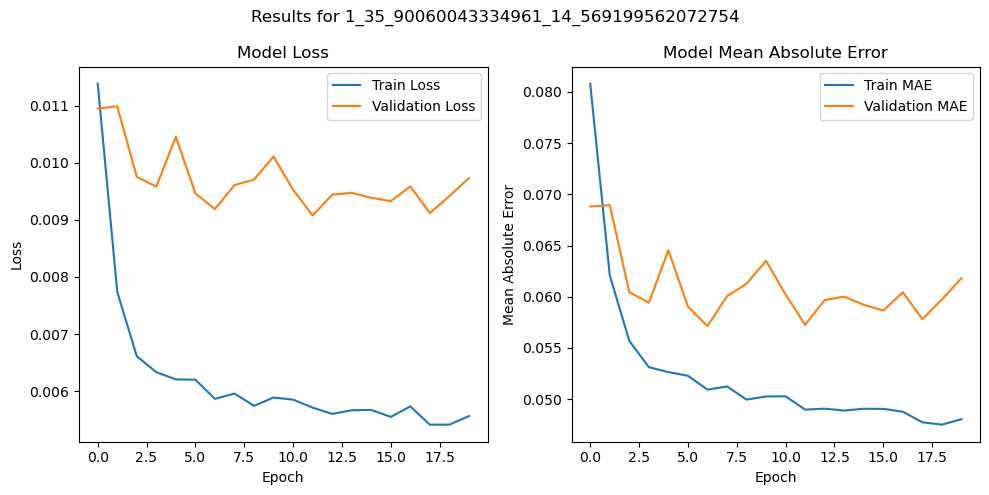

15/15 [==============================] - 2s 108ms/step

Test set Evaluation metrics for file: 1_35_90060043334961_14_569199562072754
Mean Squared Error (MSE): 0.0035967161447710526
Mean Absolute Error (MAE): 0.04239461804702965
Root Mean Squared Error (RMSE): 0.059972628296340764



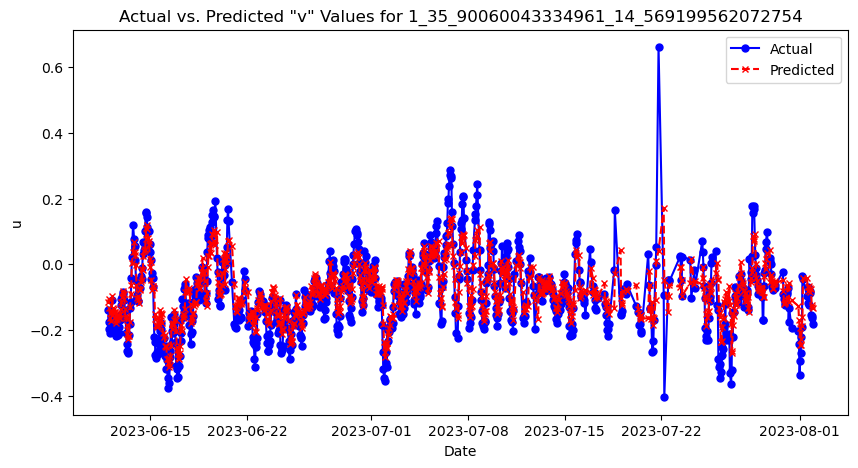

Model tarining & evaluation completed for file: 1_35_90060043334961_14_569199562072754.csv

Processing file: 2_35_92279815673828_14_569199562072754.csv

Epoch 1/100
74/74 [==============================] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0784INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 50s 637ms/step - loss: 0.0110 - mean_absolute_error: 0.0784 - val_loss: 0.0126 - val_mean_absolute_error: 0.0744
Epoch 2/100
74/74 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0566INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 74s 1s/step - loss: 0.0067 - mean_absolute_error: 0.0566 - val_loss: 0.0099 - val_mean_absolute_error: 0.0571
Epoch 3/100
74/74 [==============================] - 75s 1s/step - loss: 0.0065 - mean_absolute_error: 0.0551 - val_loss: 0.0104 - val_mean_absolute_error: 0.0593
Epoch 4/100
74/74 [==============================] - 75s 1s/step - loss: 0.0055 - mean_absolute_error: 0.0495 - val_loss: 0.0099 - val_mean_absolute_error: 0.0559
Epoch 5/100
74/74 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0490INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 79s 1s/step - loss: 0.0056 - mean_absolute_error: 0.0490 - val_loss: 0.0098 - val_mean_absolute_error: 0.0541
Epoch 6/100
74/74 [==============================] - 74s 1000ms/step - loss: 0.0057 - mean_absolute_error: 0.0497 - val_loss: 0.0100 - val_mean_absolute_error: 0.0567
Epoch 7/100
74/74 [==============================] - 74s 999ms/step - loss: 0.0054 - mean_absolute_error: 0.0477 - val_loss: 0.0104 - val_mean_absolute_error: 0.0585
Epoch 8/100
74/74 [==============================] - 74s 997ms/step - loss: 0.0055 - mean_absolute_error: 0.0485 - val_loss: 0.0101 - val_mean_absolute_error: 0.0570
Epoch 9/100
74/74 [==============================] - 73s 989ms/step - loss: 0.0054 - mean_absolute_error: 0.0479 - val_loss: 0.0100 - val_mean_absolute_error: 0.0569
Epoch 10/100
74/74 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0466INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\2_35_9227981

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 79s 1s/step - loss: 0.0052 - mean_absolute_error: 0.0466 - val_loss: 0.0094 - val_mean_absolute_error: 0.0521
Epoch 11/100
74/74 [==============================] - 76s 1s/step - loss: 0.0054 - mean_absolute_error: 0.0472 - val_loss: 0.0100 - val_mean_absolute_error: 0.0570
Epoch 12/100
74/74 [==============================] - 73s 989ms/step - loss: 0.0053 - mean_absolute_error: 0.0471 - val_loss: 0.0095 - val_mean_absolute_error: 0.0544
Epoch 13/100
74/74 [==============================] - 73s 990ms/step - loss: 0.0052 - mean_absolute_error: 0.0463 - val_loss: 0.0102 - val_mean_absolute_error: 0.0588
Epoch 14/100
74/74 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0456INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 78s 1s/step - loss: 0.0051 - mean_absolute_error: 0.0456 - val_loss: 0.0092 - val_mean_absolute_error: 0.0518
Epoch 15/100
74/74 [==============================] - 74s 1s/step - loss: 0.0053 - mean_absolute_error: 0.0468 - val_loss: 0.0104 - val_mean_absolute_error: 0.0580
Epoch 16/100
74/74 [==============================] - 75s 1s/step - loss: 0.0050 - mean_absolute_error: 0.0452 - val_loss: 0.0106 - val_mean_absolute_error: 0.0595
Epoch 17/100
74/74 [==============================] - 74s 1s/step - loss: 0.0050 - mean_absolute_error: 0.0450 - val_loss: 0.0102 - val_mean_absolute_error: 0.0591
Epoch 18/100
74/74 [==============================] - 73s 988ms/step - loss: 0.0049 - mean_absolute_error: 0.0455 - val_loss: 0.0114 - val_mean_absolute_error: 0.0582
Epoch 19/100
74/74 [==============================] - 73s 991ms/step - loss: 0.0049 - mean_absolute_error: 0.0454 - val_loss: 0.0100 - val_mean_absolute_error: 0.0567
Epoch 20/100
74/74 [===

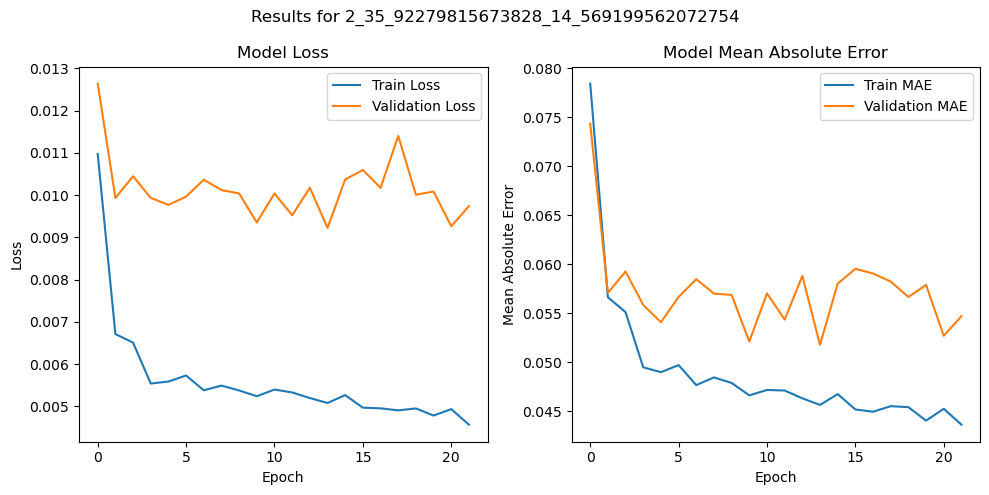

15/15 [==============================] - 3s 166ms/step

Test set Evaluation metrics for file: 2_35_92279815673828_14_569199562072754
Mean Squared Error (MSE): 0.00307303595250407
Mean Absolute Error (MAE): 0.038434890233536426
Root Mean Squared Error (RMSE): 0.05543497048347794



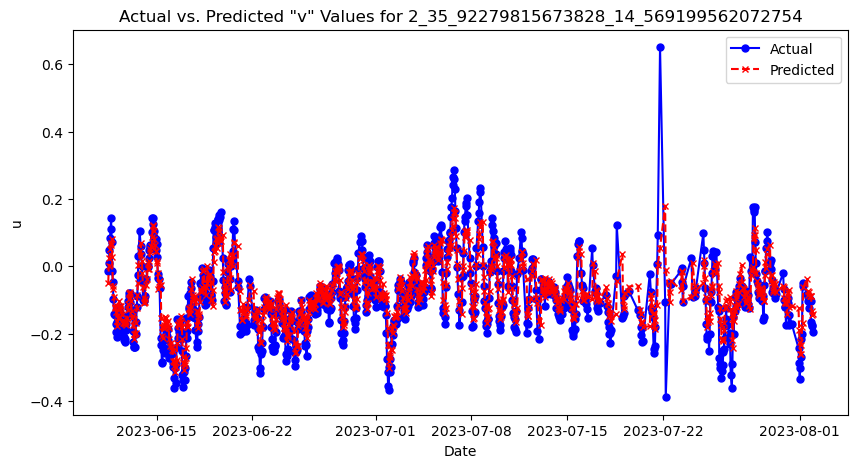

Model tarining & evaluation completed for file: 2_35_92279815673828_14_569199562072754.csv

Processing file: 3_35_945098876953125_14_569199562072754.csv

Epoch 1/100
90/90 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0733INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 116s 1s/step - loss: 0.0097 - mean_absolute_error: 0.0733 - val_loss: 0.0103 - val_mean_absolute_error: 0.0683
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0543INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 109s 1s/step - loss: 0.0061 - mean_absolute_error: 0.0543 - val_loss: 0.0095 - val_mean_absolute_error: 0.0646
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0493INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 99s 1s/step - loss: 0.0054 - mean_absolute_error: 0.0493 - val_loss: 0.0087 - val_mean_absolute_error: 0.0590
Epoch 4/100
90/90 [==============================] - 99s 1s/step - loss: 0.0052 - mean_absolute_error: 0.0477 - val_loss: 0.0088 - val_mean_absolute_error: 0.0595
Epoch 5/100
90/90 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0450INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 103s 1s/step - loss: 0.0048 - mean_absolute_error: 0.0450 - val_loss: 0.0086 - val_mean_absolute_error: 0.0567
Epoch 6/100
90/90 [==============================] - 91s 1s/step - loss: 0.0049 - mean_absolute_error: 0.0455 - val_loss: 0.0088 - val_mean_absolute_error: 0.0575
Epoch 7/100
90/90 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0453INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 97s 1s/step - loss: 0.0048 - mean_absolute_error: 0.0453 - val_loss: 0.0083 - val_mean_absolute_error: 0.0556
Epoch 8/100
90/90 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0454INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 94s 1s/step - loss: 0.0048 - mean_absolute_error: 0.0454 - val_loss: 0.0080 - val_mean_absolute_error: 0.0526
Epoch 9/100
90/90 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0440INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\3_35_945098876953125_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 89s 986ms/step - loss: 0.0047 - mean_absolute_error: 0.0440 - val_loss: 0.0077 - val_mean_absolute_error: 0.0503
Epoch 10/100
90/90 [==============================] - 86s 955ms/step - loss: 0.0048 - mean_absolute_error: 0.0444 - val_loss: 0.0084 - val_mean_absolute_error: 0.0553
Epoch 11/100
90/90 [==============================] - 86s 953ms/step - loss: 0.0046 - mean_absolute_error: 0.0437 - val_loss: 0.0079 - val_mean_absolute_error: 0.0514
Epoch 12/100
90/90 [==============================] - 88s 984ms/step - loss: 0.0046 - mean_absolute_error: 0.0432 - val_loss: 0.0080 - val_mean_absolute_error: 0.0529
Epoch 13/100
90/90 [==============================] - 90s 1s/step - loss: 0.0043 - mean_absolute_error: 0.0418 - val_loss: 0.0087 - val_mean_absolute_error: 0.0554
Epoch 14/100
90/90 [==============================] - 91s 1s/step - loss: 0.0045 - mean_absolute_error: 0.0429 - val_loss: 0.0086 - val_mean_absolute_error: 0.0546
Epoch 15/100
90/9

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\3_35_945098876953125_14_569199562072754\assets


90/90 [==============================] - 97s 1s/step - loss: 0.0042 - mean_absolute_error: 0.0415 - val_loss: 0.0075 - val_mean_absolute_error: 0.0464
Epoch 18/100
90/90 [==============================] - 92s 1s/step - loss: 0.0043 - mean_absolute_error: 0.0421 - val_loss: 0.0088 - val_mean_absolute_error: 0.0548
Epoch 19/100
90/90 [==============================] - 92s 1s/step - loss: 0.0041 - mean_absolute_error: 0.0412 - val_loss: 0.0082 - val_mean_absolute_error: 0.0509
Epoch 20/100
90/90 [==============================] - 89s 991ms/step - loss: 0.0041 - mean_absolute_error: 0.0414 - val_loss: 0.0081 - val_mean_absolute_error: 0.0488
Epoch 21/100
90/90 [==============================] - 89s 988ms/step - loss: 0.0040 - mean_absolute_error: 0.0408 - val_loss: 0.0080 - val_mean_absolute_error: 0.0499
Epoch 22/100
90/90 [==============================] - 87s 968ms/step - loss: 0.0040 - mean_absolute_error: 0.0404 - val_loss: 0.0081 - val_mean_absolute_error: 0.0512
Epoch 23/100
90/90 [

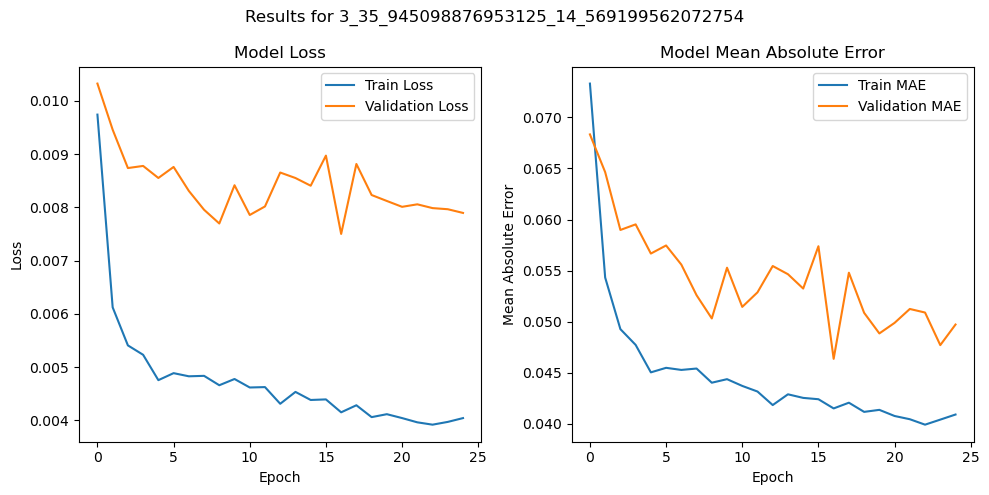

19/19 [==============================] - 4s 172ms/step

Test set Evaluation metrics for file: 3_35_945098876953125_14_569199562072754
Mean Squared Error (MSE): 0.002196579790882974
Mean Absolute Error (MAE): 0.03308304700615951
Root Mean Squared Error (RMSE): 0.046867683865142874



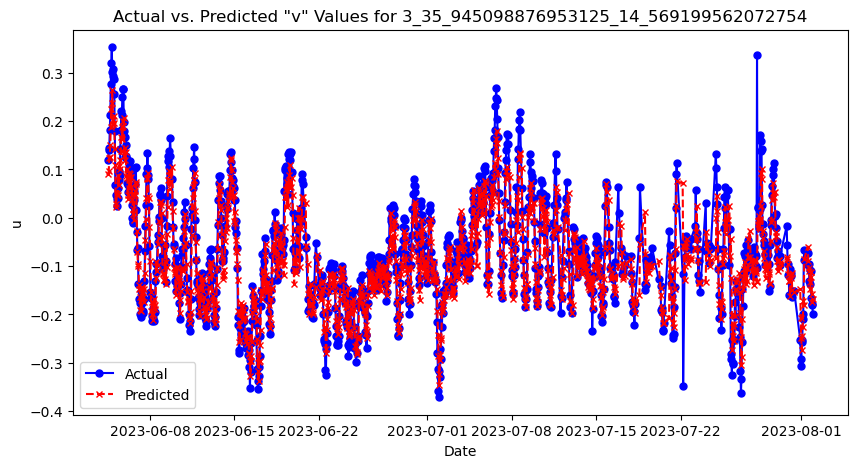

Model tarining & evaluation completed for file: 3_35_945098876953125_14_569199562072754.csv

Processing file: 4_35_96730041503906_14_528599739074707.csv

Epoch 1/100
103/103 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0800INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\4_35_96730041503906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\4_35_96730041503906_14_528599739074707\assets


103/103 [==============================] - 111s 1s/step - loss: 0.0117 - mean_absolute_error: 0.0800 - val_loss: 0.0126 - val_mean_absolute_error: 0.0749
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0597INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\4_35_96730041503906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\4_35_96730041503906_14_528599739074707\assets


103/103 [==============================] - 139s 1s/step - loss: 0.0074 - mean_absolute_error: 0.0597 - val_loss: 0.0105 - val_mean_absolute_error: 0.0629
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0524INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\4_35_96730041503906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\4_35_96730041503906_14_528599739074707\assets


103/103 [==============================] - 142s 1s/step - loss: 0.0061 - mean_absolute_error: 0.0524 - val_loss: 0.0104 - val_mean_absolute_error: 0.0626
Epoch 4/100
103/103 [==============================] - 135s 1s/step - loss: 0.0060 - mean_absolute_error: 0.0509 - val_loss: 0.0105 - val_mean_absolute_error: 0.0630
Epoch 5/100
103/103 [==============================] - 135s 1s/step - loss: 0.0058 - mean_absolute_error: 0.0500 - val_loss: 0.0118 - val_mean_absolute_error: 0.0689
Epoch 6/100
103/103 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0491INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\4_35_96730041503906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\4_35_96730041503906_14_528599739074707\assets


103/103 [==============================] - 139s 1s/step - loss: 0.0056 - mean_absolute_error: 0.0491 - val_loss: 0.0095 - val_mean_absolute_error: 0.0560
Epoch 7/100
103/103 [==============================] - 127s 1s/step - loss: 0.0054 - mean_absolute_error: 0.0474 - val_loss: 0.0100 - val_mean_absolute_error: 0.0581
Epoch 8/100
103/103 [==============================] - 127s 1s/step - loss: 0.0054 - mean_absolute_error: 0.0478 - val_loss: 0.0111 - val_mean_absolute_error: 0.0643
Epoch 9/100
103/103 [==============================] - 127s 1s/step - loss: 0.0052 - mean_absolute_error: 0.0462 - val_loss: 0.0107 - val_mean_absolute_error: 0.0625
Epoch 10/100
103/103 [==============================] - 128s 1s/step - loss: 0.0051 - mean_absolute_error: 0.0457 - val_loss: 0.0104 - val_mean_absolute_error: 0.0598
Epoch 11/100
103/103 [==============================] - 127s 1s/step - loss: 0.0051 - mean_absolute_error: 0.0457 - val_loss: 0.0102 - val_mean_absolute_error: 0.0594
Epoch 12/100
1

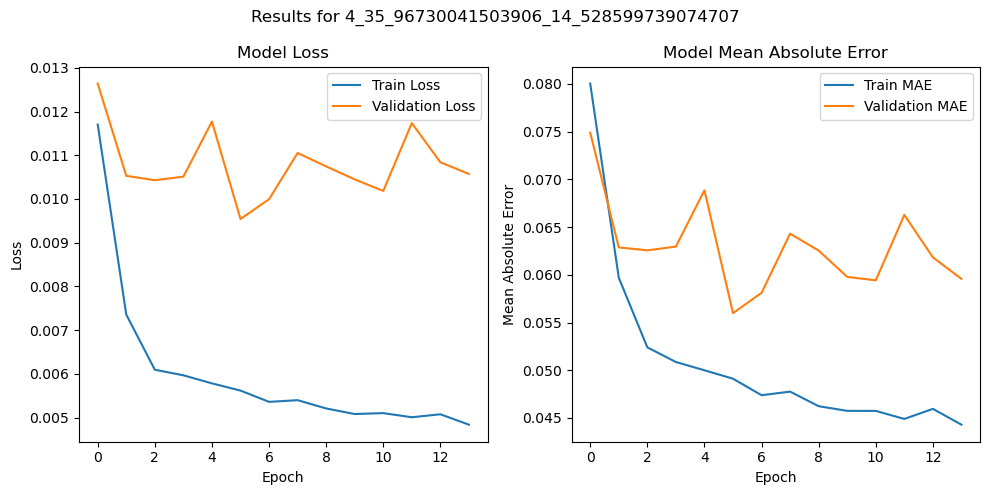

22/22 [==============================] - 5s 209ms/step

Test set Evaluation metrics for file: 4_35_96730041503906_14_528599739074707
Mean Squared Error (MSE): 0.0035425771679098673
Mean Absolute Error (MAE): 0.04562250283486684
Root Mean Squared Error (RMSE): 0.05951955282014363



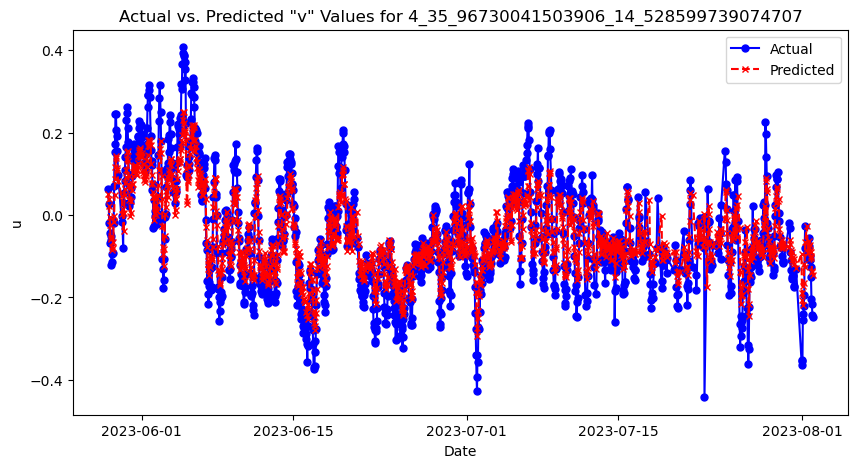

Model tarining & evaluation completed for file: 4_35_96730041503906_14_528599739074707.csv

Processing file: 5_35_96730041503906_14_569199562072754.csv

Epoch 1/100
103/103 [==============================] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0774INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 121s 1s/step - loss: 0.0111 - mean_absolute_error: 0.0774 - val_loss: 0.0085 - val_mean_absolute_error: 0.0602
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0555INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 119s 1s/step - loss: 0.0065 - mean_absolute_error: 0.0555 - val_loss: 0.0078 - val_mean_absolute_error: 0.0556
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0476INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 139s 1s/step - loss: 0.0054 - mean_absolute_error: 0.0476 - val_loss: 0.0073 - val_mean_absolute_error: 0.0525
Epoch 4/100
103/103 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0478INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 145s 1s/step - loss: 0.0054 - mean_absolute_error: 0.0478 - val_loss: 0.0073 - val_mean_absolute_error: 0.0520
Epoch 5/100
103/103 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0456INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 144s 1s/step - loss: 0.0051 - mean_absolute_error: 0.0456 - val_loss: 0.0067 - val_mean_absolute_error: 0.0477
Epoch 6/100
103/103 [==============================] - 140s 1s/step - loss: 0.0051 - mean_absolute_error: 0.0455 - val_loss: 0.0070 - val_mean_absolute_error: 0.0493
Epoch 7/100
103/103 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0442INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 143s 1s/step - loss: 0.0049 - mean_absolute_error: 0.0442 - val_loss: 0.0066 - val_mean_absolute_error: 0.0464
Epoch 8/100
103/103 [==============================] - 139s 1s/step - loss: 0.0048 - mean_absolute_error: 0.0439 - val_loss: 0.0067 - val_mean_absolute_error: 0.0475
Epoch 9/100
103/103 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0426INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 144s 1s/step - loss: 0.0047 - mean_absolute_error: 0.0426 - val_loss: 0.0065 - val_mean_absolute_error: 0.0460
Epoch 10/100
103/103 [==============================] - 139s 1s/step - loss: 0.0048 - mean_absolute_error: 0.0434 - val_loss: 0.0068 - val_mean_absolute_error: 0.0478
Epoch 11/100
103/103 [==============================] - 139s 1s/step - loss: 0.0047 - mean_absolute_error: 0.0429 - val_loss: 0.0066 - val_mean_absolute_error: 0.0469
Epoch 12/100
103/103 [==============================] - 143s 1s/step - loss: 0.0045 - mean_absolute_error: 0.0417 - val_loss: 0.0067 - val_mean_absolute_error: 0.0456
Epoch 13/100
103/103 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0422INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 150s 1s/step - loss: 0.0046 - mean_absolute_error: 0.0422 - val_loss: 0.0065 - val_mean_absolute_error: 0.0451
Epoch 14/100
103/103 [==============================] - 143s 1s/step - loss: 0.0044 - mean_absolute_error: 0.0415 - val_loss: 0.0071 - val_mean_absolute_error: 0.0487
Epoch 15/100
103/103 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0422INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 148s 1s/step - loss: 0.0046 - mean_absolute_error: 0.0422 - val_loss: 0.0064 - val_mean_absolute_error: 0.0447
Epoch 16/100
103/103 [==============================] - 144s 1s/step - loss: 0.0044 - mean_absolute_error: 0.0410 - val_loss: 0.0065 - val_mean_absolute_error: 0.0447
Epoch 17/100
103/103 [==============================] - 144s 1s/step - loss: 0.0043 - mean_absolute_error: 0.0405 - val_loss: 0.0068 - val_mean_absolute_error: 0.0448
Epoch 18/100
103/103 [==============================] - 144s 1s/step - loss: 0.0043 - mean_absolute_error: 0.0404 - val_loss: 0.0071 - val_mean_absolute_error: 0.0495
Epoch 19/100
103/103 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0411INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 149s 1s/step - loss: 0.0043 - mean_absolute_error: 0.0411 - val_loss: 0.0063 - val_mean_absolute_error: 0.0425
Epoch 20/100
103/103 [==============================] - 146s 1s/step - loss: 0.0043 - mean_absolute_error: 0.0407 - val_loss: 0.0065 - val_mean_absolute_error: 0.0447
Epoch 21/100
103/103 [==============================] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.0401INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\5_35_96730041503906_14_569199562072754\assets


103/103 [==============================] - 151s 1s/step - loss: 0.0042 - mean_absolute_error: 0.0401 - val_loss: 0.0062 - val_mean_absolute_error: 0.0410
Epoch 22/100
103/103 [==============================] - 149s 1s/step - loss: 0.0044 - mean_absolute_error: 0.0417 - val_loss: 0.0065 - val_mean_absolute_error: 0.0441
Epoch 23/100
103/103 [==============================] - 149s 1s/step - loss: 0.0042 - mean_absolute_error: 0.0405 - val_loss: 0.0065 - val_mean_absolute_error: 0.0435
Epoch 24/100
103/103 [==============================] - 149s 1s/step - loss: 0.0044 - mean_absolute_error: 0.0413 - val_loss: 0.0063 - val_mean_absolute_error: 0.0424
Epoch 25/100
103/103 [==============================] - 149s 1s/step - loss: 0.0042 - mean_absolute_error: 0.0400 - val_loss: 0.0066 - val_mean_absolute_error: 0.0445
Epoch 26/100
103/103 [==============================] - 149s 1s/step - loss: 0.0041 - mean_absolute_error: 0.0397 - val_loss: 0.0065 - val_mean_absolute_error: 0.0430
Epoch 27/10

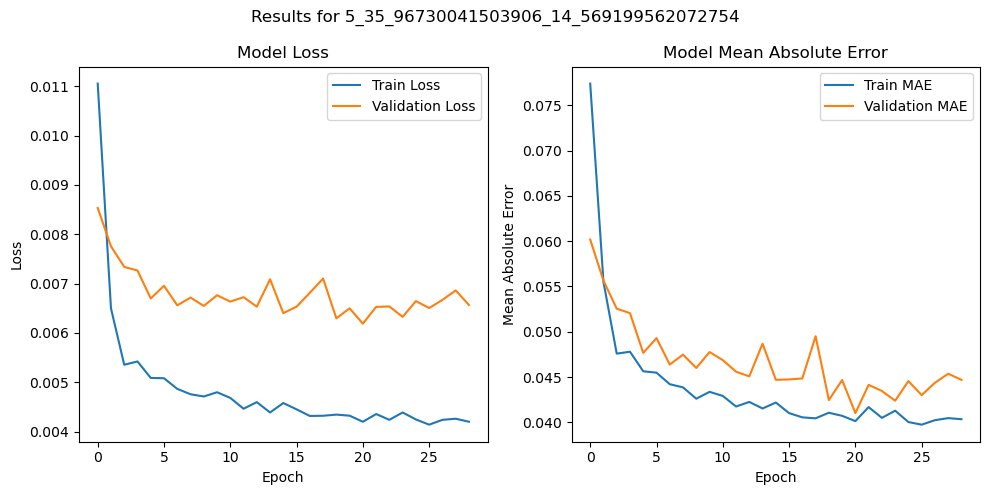

22/22 [==============================] - 6s 254ms/step

Test set Evaluation metrics for file: 5_35_96730041503906_14_569199562072754
Mean Squared Error (MSE): 0.0024169808162869525
Mean Absolute Error (MAE): 0.03576828401100811
Root Mean Squared Error (RMSE): 0.04916279910955999



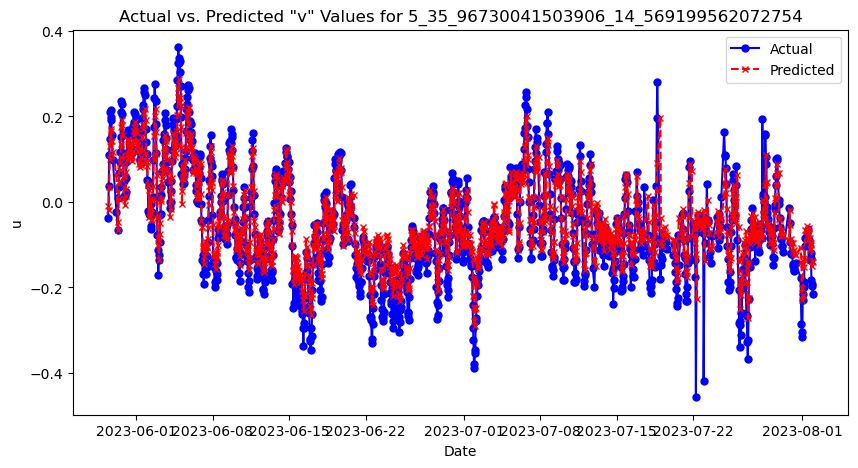

Model tarining & evaluation completed for file: 5_35_96730041503906_14_569199562072754.csv

Processing file: 6_35_989601135253906_14_447500228881836.csv

Epoch 1/100
73/73 [==============================] - ETA: 0s - loss: 0.0202 - mean_absolute_error: 0.1098INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\6_35_989601135253906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 114s 2s/step - loss: 0.0202 - mean_absolute_error: 0.1098 - val_loss: 0.0177 - val_mean_absolute_error: 0.1058
Epoch 2/100
73/73 [==============================] - ETA: 0s - loss: 0.0141 - mean_absolute_error: 0.0899INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\6_35_989601135253906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 113s 2s/step - loss: 0.0141 - mean_absolute_error: 0.0899 - val_loss: 0.0131 - val_mean_absolute_error: 0.0895
Epoch 3/100
73/73 [==============================] - ETA: 0s - loss: 0.0113 - mean_absolute_error: 0.0777INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\6_35_989601135253906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 113s 2s/step - loss: 0.0113 - mean_absolute_error: 0.0777 - val_loss: 0.0087 - val_mean_absolute_error: 0.0659
Epoch 4/100
73/73 [==============================] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0755INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\6_35_989601135253906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 117s 2s/step - loss: 0.0108 - mean_absolute_error: 0.0755 - val_loss: 0.0080 - val_mean_absolute_error: 0.0623
Epoch 5/100
73/73 [==============================] - 112s 2s/step - loss: 0.0107 - mean_absolute_error: 0.0745 - val_loss: 0.0090 - val_mean_absolute_error: 0.0669
Epoch 6/100
73/73 [==============================] - 112s 2s/step - loss: 0.0110 - mean_absolute_error: 0.0755 - val_loss: 0.0096 - val_mean_absolute_error: 0.0707
Epoch 7/100
73/73 [==============================] - 112s 2s/step - loss: 0.0108 - mean_absolute_error: 0.0752 - val_loss: 0.0080 - val_mean_absolute_error: 0.0619
Epoch 8/100
73/73 [==============================] - 112s 2s/step - loss: 0.0103 - mean_absolute_error: 0.0728 - val_loss: 0.0082 - val_mean_absolute_error: 0.0638
Epoch 9/100
73/73 [==============================] - 112s 2s/step - loss: 0.0099 - mean_absolute_error: 0.0718 - val_loss: 0.0082 - val_mean_absolute_error: 0.0628
Epoch 10/100
73/73 [========

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\6_35_989601135253906_14_447500228881836\assets


73/73 [==============================] - 117s 2s/step - loss: 0.0101 - mean_absolute_error: 0.0719 - val_loss: 0.0077 - val_mean_absolute_error: 0.0592
Epoch 12/100
73/73 [==============================] - 117s 2s/step - loss: 0.0103 - mean_absolute_error: 0.0729 - val_loss: 0.0083 - val_mean_absolute_error: 0.0639
Epoch 13/100
73/73 [==============================] - 119s 2s/step - loss: 0.0101 - mean_absolute_error: 0.0723 - val_loss: 0.0080 - val_mean_absolute_error: 0.0618
Epoch 14/100
73/73 [==============================] - 117s 2s/step - loss: 0.0100 - mean_absolute_error: 0.0721 - val_loss: 0.0079 - val_mean_absolute_error: 0.0606
Epoch 15/100
73/73 [==============================] - 117s 2s/step - loss: 0.0100 - mean_absolute_error: 0.0725 - val_loss: 0.0079 - val_mean_absolute_error: 0.0611
Epoch 16/100
73/73 [==============================] - 117s 2s/step - loss: 0.0101 - mean_absolute_error: 0.0720 - val_loss: 0.0089 - val_mean_absolute_error: 0.0677
Epoch 17/100
73/73 [===

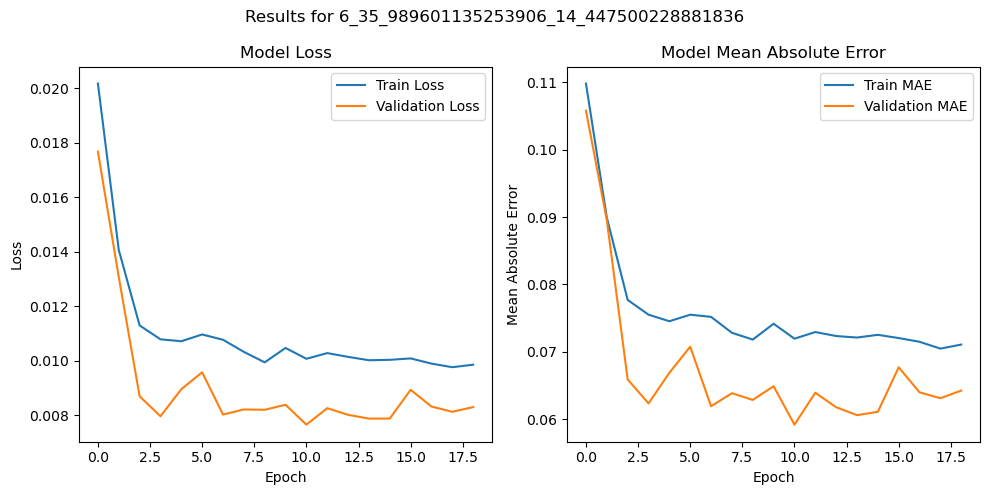

15/15 [==============================] - 5s 278ms/step

Test set Evaluation metrics for file: 6_35_989601135253906_14_447500228881836
Mean Squared Error (MSE): 0.007437401292507925
Mean Absolute Error (MAE): 0.0603345771370864
Root Mean Squared Error (RMSE): 0.08624036927395386



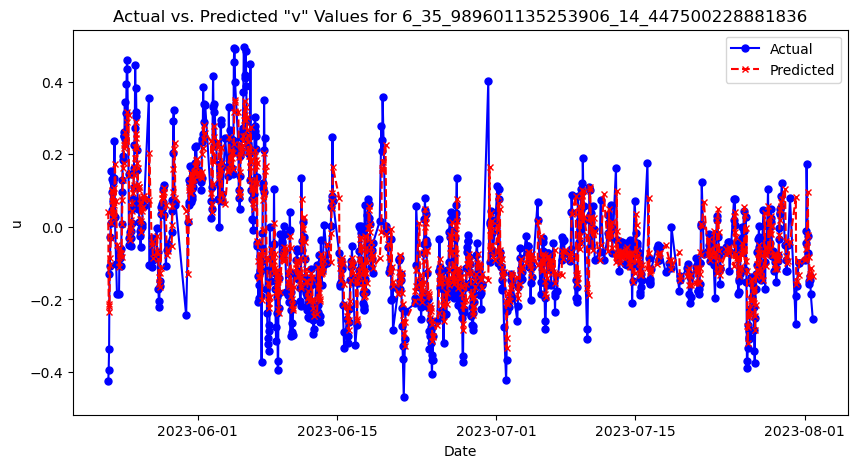

Model tarining & evaluation completed for file: 6_35_989601135253906_14_447500228881836.csv

Processing file: 7_35_989601135253906_14_48799991607666.csv

Epoch 1/100
106/106 [==============================] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0873INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\7_35_989601135253906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\7_35_989601135253906_14_48799991607666\assets


106/106 [==============================] - 175s 2s/step - loss: 0.0135 - mean_absolute_error: 0.0873 - val_loss: 0.0125 - val_mean_absolute_error: 0.0829
Epoch 2/100
106/106 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0662INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\7_35_989601135253906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\7_35_989601135253906_14_48799991607666\assets


106/106 [==============================] - 165s 2s/step - loss: 0.0081 - mean_absolute_error: 0.0662 - val_loss: 0.0074 - val_mean_absolute_error: 0.0640
Epoch 3/100
106/106 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0567INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\7_35_989601135253906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\7_35_989601135253906_14_48799991607666\assets


106/106 [==============================] - 164s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0567 - val_loss: 0.0073 - val_mean_absolute_error: 0.0618
Epoch 4/100
106/106 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0554INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\7_35_989601135253906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\7_35_989601135253906_14_48799991607666\assets


106/106 [==============================] - 165s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0554 - val_loss: 0.0072 - val_mean_absolute_error: 0.0619
Epoch 5/100
106/106 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0561INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\7_35_989601135253906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\7_35_989601135253906_14_48799991607666\assets


106/106 [==============================] - 165s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0561 - val_loss: 0.0066 - val_mean_absolute_error: 0.0588
Epoch 6/100
106/106 [==============================] - 160s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0551 - val_loss: 0.0066 - val_mean_absolute_error: 0.0594
Epoch 7/100
106/106 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0536INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\7_35_989601135253906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\7_35_989601135253906_14_48799991607666\assets


106/106 [==============================] - 164s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0536 - val_loss: 0.0062 - val_mean_absolute_error: 0.0571
Epoch 8/100
106/106 [==============================] - 160s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0519 - val_loss: 0.0069 - val_mean_absolute_error: 0.0602
Epoch 9/100
106/106 [==============================] - 160s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0538 - val_loss: 0.0081 - val_mean_absolute_error: 0.0657
Epoch 10/100
106/106 [==============================] - 160s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0525 - val_loss: 0.0064 - val_mean_absolute_error: 0.0578
Epoch 11/100
106/106 [==============================] - 159s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0512 - val_loss: 0.0067 - val_mean_absolute_error: 0.0593
Epoch 12/100
106/106 [==============================] - 160s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0523 - val_loss: 0.0075 - val_mean_absolute_error: 0.0635
Epoch 13/100


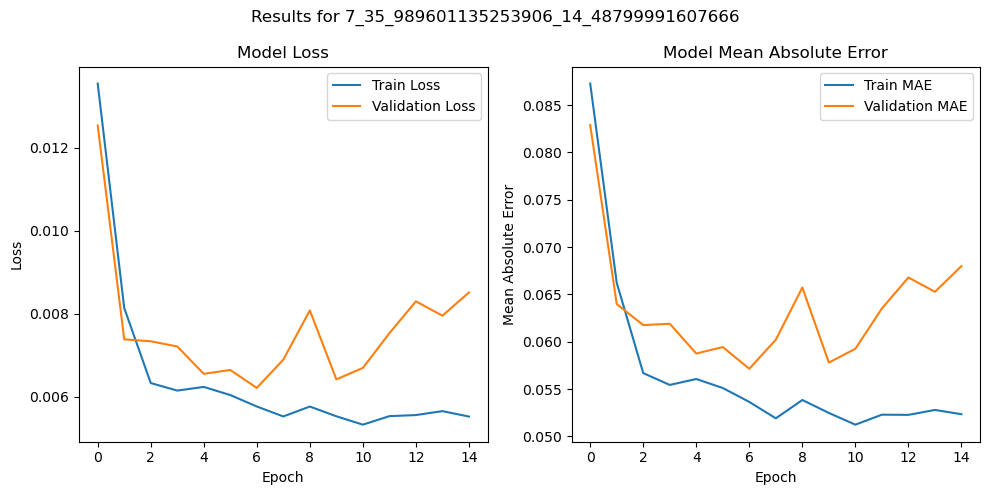

22/22 [==============================] - 7s 270ms/step

Test set Evaluation metrics for file: 7_35_989601135253906_14_48799991607666
Mean Squared Error (MSE): 0.004887387773580846
Mean Absolute Error (MAE): 0.05523785320660412
Root Mean Squared Error (RMSE): 0.06990985462422909



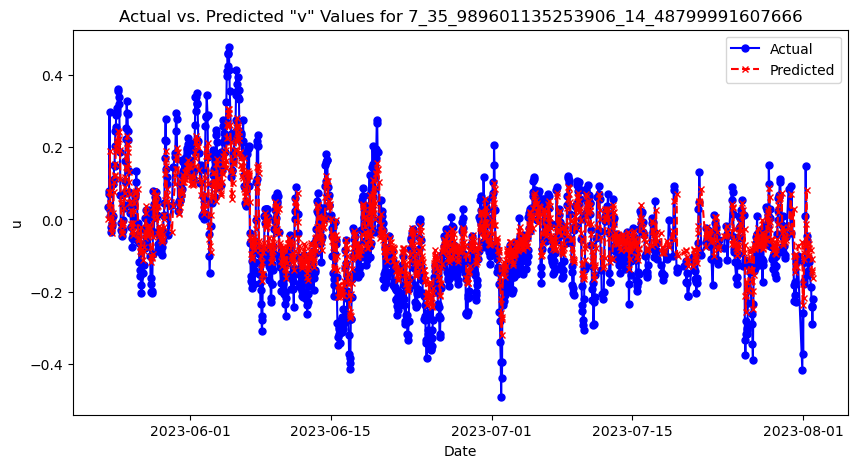

Model tarining & evaluation completed for file: 7_35_989601135253906_14_48799991607666.csv

Processing file: 8_35_989601135253906_14_528599739074707.csv

Epoch 1/100
117/117 [==============================] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0828INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 191s 2s/step - loss: 0.0128 - mean_absolute_error: 0.0828 - val_loss: 0.0125 - val_mean_absolute_error: 0.0726
Epoch 2/100
117/117 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0623INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 188s 2s/step - loss: 0.0080 - mean_absolute_error: 0.0623 - val_loss: 0.0101 - val_mean_absolute_error: 0.0605
Epoch 3/100
117/117 [==============================] - 195s 2s/step - loss: 0.0069 - mean_absolute_error: 0.0555 - val_loss: 0.0103 - val_mean_absolute_error: 0.0617
Epoch 4/100
117/117 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0539INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 200s 2s/step - loss: 0.0066 - mean_absolute_error: 0.0539 - val_loss: 0.0100 - val_mean_absolute_error: 0.0597
Epoch 5/100
117/117 [==============================] - 207s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0517 - val_loss: 0.0101 - val_mean_absolute_error: 0.0601
Epoch 6/100
117/117 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0524INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 211s 2s/step - loss: 0.0064 - mean_absolute_error: 0.0524 - val_loss: 0.0098 - val_mean_absolute_error: 0.0582
Epoch 7/100
117/117 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0502INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 221s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0502 - val_loss: 0.0091 - val_mean_absolute_error: 0.0554
Epoch 8/100
117/117 [==============================] - 205s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0502 - val_loss: 0.0095 - val_mean_absolute_error: 0.0571
Epoch 9/100
117/117 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0477INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 210s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0477 - val_loss: 0.0089 - val_mean_absolute_error: 0.0547
Epoch 10/100
117/117 [==============================] - 198s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0476 - val_loss: 0.0094 - val_mean_absolute_error: 0.0582
Epoch 11/100
117/117 [==============================] - 199s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0485 - val_loss: 0.0090 - val_mean_absolute_error: 0.0555
Epoch 12/100
117/117 [==============================] - 199s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0474 - val_loss: 0.0091 - val_mean_absolute_error: 0.0565
Epoch 13/100
117/117 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0474INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 203s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0474 - val_loss: 0.0089 - val_mean_absolute_error: 0.0551
Epoch 14/100
117/117 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0471INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\8_35_989601135253906_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 203s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0471 - val_loss: 0.0084 - val_mean_absolute_error: 0.0529
Epoch 15/100
117/117 [==============================] - 199s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0469 - val_loss: 0.0090 - val_mean_absolute_error: 0.0555
Epoch 16/100
117/117 [==============================] - 198s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0458 - val_loss: 0.0088 - val_mean_absolute_error: 0.0546
Epoch 17/100
117/117 [==============================] - 199s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0465 - val_loss: 0.0087 - val_mean_absolute_error: 0.0540
Epoch 18/100
117/117 [==============================] - 199s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0468 - val_loss: 0.0086 - val_mean_absolute_error: 0.0536
Epoch 19/100
117/117 [==============================] - 198s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0464 - val_loss: 0.0089 - val_mean_absolute_error: 0.0553
Epoch 20/10

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\8_35_989601135253906_14_528599739074707\assets


117/117 [==============================] - 203s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0454 - val_loss: 0.0083 - val_mean_absolute_error: 0.0512
Epoch 22/100
117/117 [==============================] - 198s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0461 - val_loss: 0.0089 - val_mean_absolute_error: 0.0557
Epoch 23/100
117/117 [==============================] - 198s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0466 - val_loss: 0.0084 - val_mean_absolute_error: 0.0524
Epoch 24/100
117/117 [==============================] - 198s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0457 - val_loss: 0.0085 - val_mean_absolute_error: 0.0529
Epoch 25/100
117/117 [==============================] - 198s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0457 - val_loss: 0.0089 - val_mean_absolute_error: 0.0562
Epoch 26/100
117/117 [==============================] - 198s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0465 - val_loss: 0.0089 - val_mean_absolute_error: 0.0562
Epoch 27/10

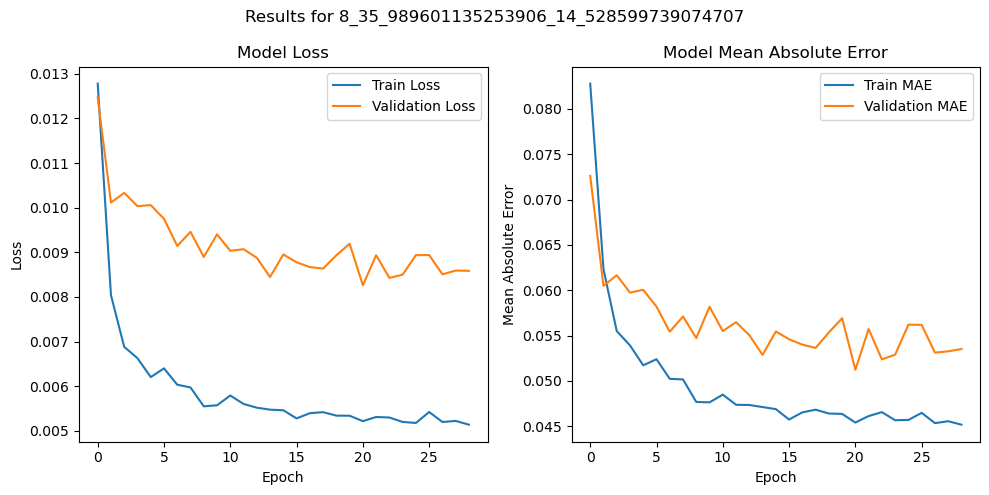

25/25 [==============================] - 8s 301ms/step

Test set Evaluation metrics for file: 8_35_989601135253906_14_528599739074707
Mean Squared Error (MSE): 0.003177930065196911
Mean Absolute Error (MAE): 0.042728994977403165
Root Mean Squared Error (RMSE): 0.056373132476357134



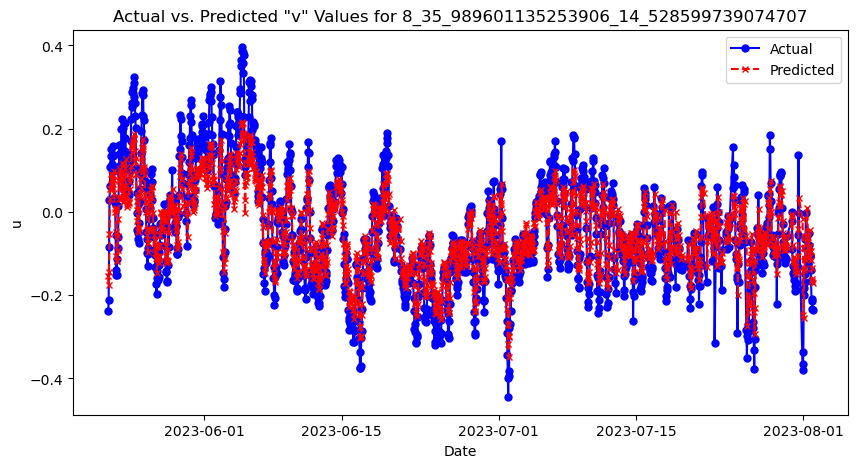

Model tarining & evaluation completed for file: 8_35_989601135253906_14_528599739074707.csv

Processing file: 9_35_989601135253906_14_569199562072754.csv

Epoch 1/100
117/117 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0793INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 200s 2s/step - loss: 0.0117 - mean_absolute_error: 0.0793 - val_loss: 0.0095 - val_mean_absolute_error: 0.0617
Epoch 2/100
117/117 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0593INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 198s 2s/step - loss: 0.0075 - mean_absolute_error: 0.0593 - val_loss: 0.0086 - val_mean_absolute_error: 0.0564
Epoch 3/100
117/117 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0528INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 208s 2s/step - loss: 0.0064 - mean_absolute_error: 0.0528 - val_loss: 0.0083 - val_mean_absolute_error: 0.0544
Epoch 4/100
117/117 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0490INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 191s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0490 - val_loss: 0.0080 - val_mean_absolute_error: 0.0528
Epoch 5/100
117/117 [==============================] - 192s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0489 - val_loss: 0.0080 - val_mean_absolute_error: 0.0531
Epoch 6/100
117/117 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0485INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 197s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0485 - val_loss: 0.0078 - val_mean_absolute_error: 0.0510
Epoch 7/100
117/117 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0473INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 192s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0473 - val_loss: 0.0078 - val_mean_absolute_error: 0.0516
Epoch 8/100
117/117 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0464INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 192s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0464 - val_loss: 0.0077 - val_mean_absolute_error: 0.0509
Epoch 9/100
117/117 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0454INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 191s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0454 - val_loss: 0.0076 - val_mean_absolute_error: 0.0495
Epoch 10/100
117/117 [==============================] - 186s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0456 - val_loss: 0.0077 - val_mean_absolute_error: 0.0518
Epoch 11/100
117/117 [==============================] - 193s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0467 - val_loss: 0.0077 - val_mean_absolute_error: 0.0520
Epoch 12/100
117/117 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0451INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 202s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0451 - val_loss: 0.0071 - val_mean_absolute_error: 0.0471
Epoch 13/100
117/117 [==============================] - 193s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0442 - val_loss: 0.0072 - val_mean_absolute_error: 0.0480
Epoch 14/100
117/117 [==============================] - 194s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0444 - val_loss: 0.0071 - val_mean_absolute_error: 0.0473
Epoch 15/100
117/117 [==============================] - 194s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0448 - val_loss: 0.0072 - val_mean_absolute_error: 0.0483
Epoch 16/100
117/117 [==============================] - 193s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0439 - val_loss: 0.0071 - val_mean_absolute_error: 0.0479
Epoch 17/100
117/117 [==============================] - 194s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0439 - val_loss: 0.0073 - val_mean_absolute_error: 0.0487
Epoch 18/10

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 199s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0437 - val_loss: 0.0071 - val_mean_absolute_error: 0.0472
Epoch 19/100
117/117 [==============================] - 193s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0438 - val_loss: 0.0075 - val_mean_absolute_error: 0.0498
Epoch 20/100
117/117 [==============================] - 194s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0430 - val_loss: 0.0073 - val_mean_absolute_error: 0.0481
Epoch 21/100
117/117 [==============================] - 194s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0433 - val_loss: 0.0072 - val_mean_absolute_error: 0.0477
Epoch 22/100
117/117 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0432INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 198s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0432 - val_loss: 0.0069 - val_mean_absolute_error: 0.0463
Epoch 23/100
117/117 [==============================] - 193s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0428 - val_loss: 0.0071 - val_mean_absolute_error: 0.0478
Epoch 24/100
117/117 [==============================] - 193s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0430 - val_loss: 0.0073 - val_mean_absolute_error: 0.0484
Epoch 25/100
117/117 [==============================] - 192s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0424 - val_loss: 0.0072 - val_mean_absolute_error: 0.0490
Epoch 26/100
117/117 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0421INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 198s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0421 - val_loss: 0.0068 - val_mean_absolute_error: 0.0443
Epoch 27/100
117/117 [==============================] - 203s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0434 - val_loss: 0.0071 - val_mean_absolute_error: 0.0477
Epoch 28/100
117/117 [==============================] - 202s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0437 - val_loss: 0.0072 - val_mean_absolute_error: 0.0484
Epoch 29/100
117/117 [==============================] - 203s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0426 - val_loss: 0.0071 - val_mean_absolute_error: 0.0481
Epoch 30/100
117/117 [==============================] - 202s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0428 - val_loss: 0.0071 - val_mean_absolute_error: 0.0477
Epoch 31/100
117/117 [==============================] - 203s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0427 - val_loss: 0.0074 - val_mean_absolute_error: 0.0489
Epoch 32/10

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\9_35_989601135253906_14_569199562072754\assets


117/117 [==============================] - 207s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0424 - val_loss: 0.0067 - val_mean_absolute_error: 0.0445
Epoch 35/100
117/117 [==============================] - 220s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0429 - val_loss: 0.0071 - val_mean_absolute_error: 0.0470
Epoch 36/100
117/117 [==============================] - 220s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0423 - val_loss: 0.0069 - val_mean_absolute_error: 0.0464
Epoch 37/100
117/117 [==============================] - 219s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0424 - val_loss: 0.0069 - val_mean_absolute_error: 0.0462
Epoch 38/100
117/117 [==============================] - 220s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0420 - val_loss: 0.0069 - val_mean_absolute_error: 0.0456
Epoch 39/100
117/117 [==============================] - 219s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0424 - val_loss: 0.0069 - val_mean_absolute_error: 0.0451
Epoch 40/10

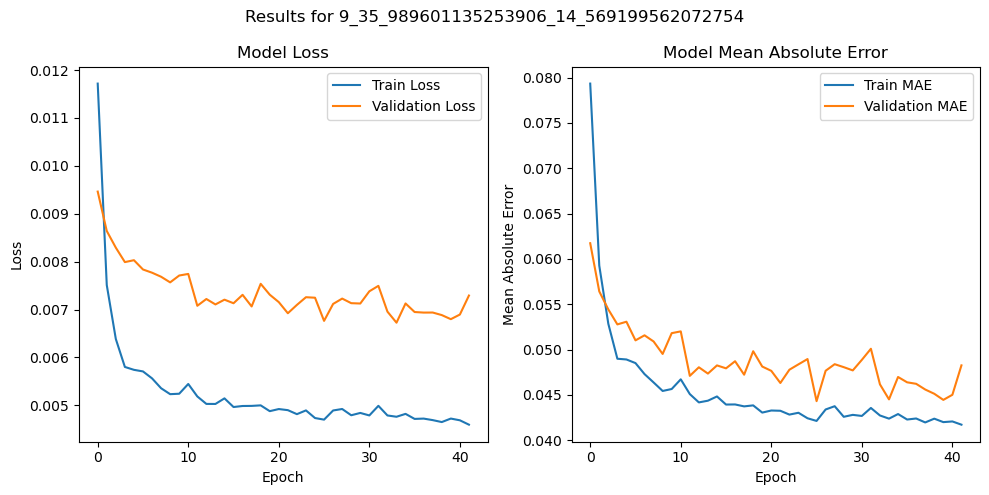

25/25 [==============================] - 9s 293ms/step

Test set Evaluation metrics for file: 9_35_989601135253906_14_569199562072754
Mean Squared Error (MSE): 0.002286316917679351
Mean Absolute Error (MAE): 0.035620993048376084
Root Mean Squared Error (RMSE): 0.04781544643396474



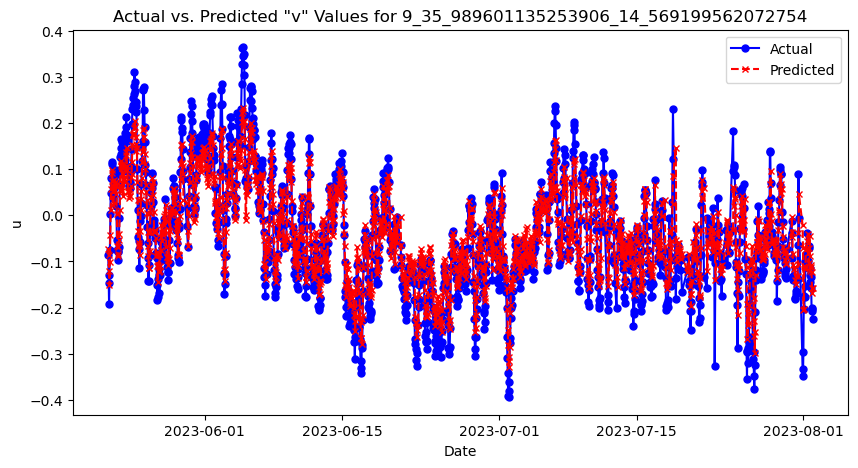

Model tarining & evaluation completed for file: 9_35_989601135253906_14_569199562072754.csv

Processing file: 10_36_01190185546875_14_447500228881836.csv

Epoch 1/100
102/102 [==============================] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.0910INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 177s 2s/step - loss: 0.0143 - mean_absolute_error: 0.0910 - val_loss: 0.0094 - val_mean_absolute_error: 0.0771
Epoch 2/100
102/102 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 193s 2s/step - loss: 0.0091 - mean_absolute_error: 0.0700 - val_loss: 0.0070 - val_mean_absolute_error: 0.0652
Epoch 3/100
102/102 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0639INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 193s 2s/step - loss: 0.0080 - mean_absolute_error: 0.0639 - val_loss: 0.0061 - val_mean_absolute_error: 0.0604
Epoch 4/100
102/102 [==============================] - 190s 2s/step - loss: 0.0076 - mean_absolute_error: 0.0622 - val_loss: 0.0065 - val_mean_absolute_error: 0.0628
Epoch 5/100
102/102 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0613INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 194s 2s/step - loss: 0.0074 - mean_absolute_error: 0.0613 - val_loss: 0.0059 - val_mean_absolute_error: 0.0585
Epoch 6/100
102/102 [==============================] - 190s 2s/step - loss: 0.0074 - mean_absolute_error: 0.0605 - val_loss: 0.0059 - val_mean_absolute_error: 0.0590
Epoch 7/100
102/102 [==============================] - 190s 2s/step - loss: 0.0074 - mean_absolute_error: 0.0611 - val_loss: 0.0067 - val_mean_absolute_error: 0.0636
Epoch 8/100
102/102 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0616INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 195s 2s/step - loss: 0.0075 - mean_absolute_error: 0.0616 - val_loss: 0.0056 - val_mean_absolute_error: 0.0567
Epoch 9/100
102/102 [==============================] - 190s 2s/step - loss: 0.0072 - mean_absolute_error: 0.0596 - val_loss: 0.0062 - val_mean_absolute_error: 0.0604
Epoch 10/100
102/102 [==============================] - 191s 2s/step - loss: 0.0072 - mean_absolute_error: 0.0596 - val_loss: 0.0060 - val_mean_absolute_error: 0.0597
Epoch 11/100
102/102 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0593INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\10_36_01190185546875_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\10_36_01190185546875_14_447500228881836\assets


102/102 [==============================] - 196s 2s/step - loss: 0.0071 - mean_absolute_error: 0.0593 - val_loss: 0.0053 - val_mean_absolute_error: 0.0542
Epoch 12/100
102/102 [==============================] - 201s 2s/step - loss: 0.0071 - mean_absolute_error: 0.0591 - val_loss: 0.0055 - val_mean_absolute_error: 0.0559
Epoch 13/100
102/102 [==============================] - 201s 2s/step - loss: 0.0072 - mean_absolute_error: 0.0596 - val_loss: 0.0060 - val_mean_absolute_error: 0.0592
Epoch 14/100
102/102 [==============================] - 201s 2s/step - loss: 0.0071 - mean_absolute_error: 0.0596 - val_loss: 0.0060 - val_mean_absolute_error: 0.0596
Epoch 15/100
102/102 [==============================] - 202s 2s/step - loss: 0.0070 - mean_absolute_error: 0.0588 - val_loss: 0.0056 - val_mean_absolute_error: 0.0566
Epoch 16/100
102/102 [==============================] - 205s 2s/step - loss: 0.0069 - mean_absolute_error: 0.0581 - val_loss: 0.0063 - val_mean_absolute_error: 0.0614
Epoch 17/10

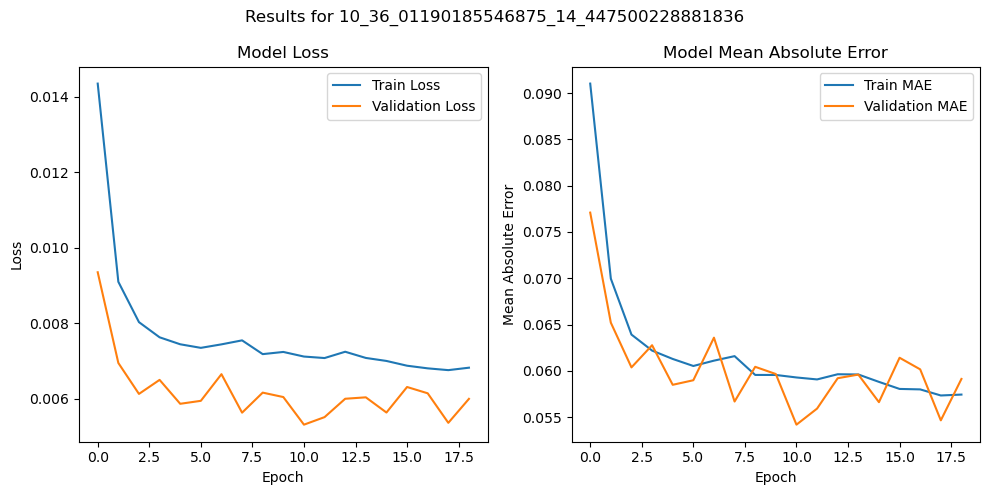

21/21 [==============================] - 8s 370ms/step

Test set Evaluation metrics for file: 10_36_01190185546875_14_447500228881836
Mean Squared Error (MSE): 0.005894174313313621
Mean Absolute Error (MAE): 0.057750649625912705
Root Mean Squared Error (RMSE): 0.0767735261227047



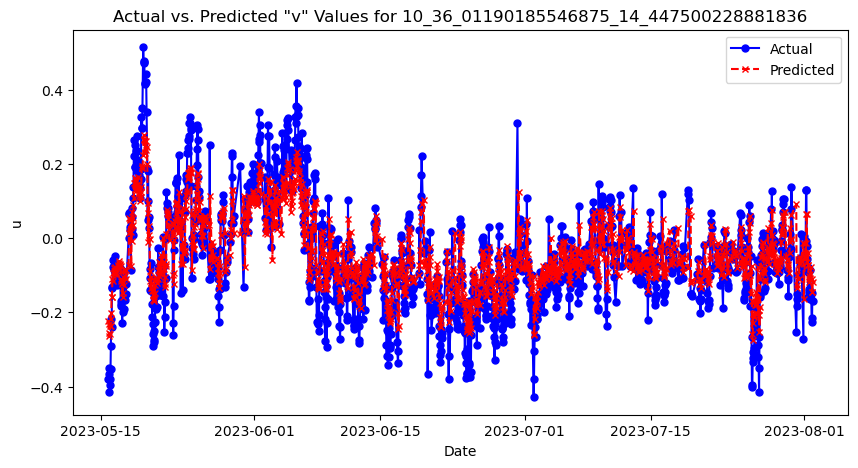

Model tarining & evaluation completed for file: 10_36_01190185546875_14_447500228881836.csv

Processing file: 11_36_01190185546875_14_48799991607666.csv

Epoch 1/100
121/121 [==============================] - ETA: 0s - loss: 0.0123 - mean_absolute_error: 0.0828INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\11_36_01190185546875_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\11_36_01190185546875_14_48799991607666\assets


121/121 [==============================] - 224s 2s/step - loss: 0.0123 - mean_absolute_error: 0.0828 - val_loss: 0.0072 - val_mean_absolute_error: 0.0628
Epoch 2/100
121/121 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0623INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\11_36_01190185546875_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\11_36_01190185546875_14_48799991607666\assets


121/121 [==============================] - 224s 2s/step - loss: 0.0073 - mean_absolute_error: 0.0623 - val_loss: 0.0050 - val_mean_absolute_error: 0.0532
Epoch 3/100
121/121 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0546INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\11_36_01190185546875_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\11_36_01190185546875_14_48799991607666\assets


121/121 [==============================] - 223s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0546 - val_loss: 0.0045 - val_mean_absolute_error: 0.0495
Epoch 4/100
121/121 [==============================] - 218s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0540 - val_loss: 0.0051 - val_mean_absolute_error: 0.0539
Epoch 5/100
121/121 [==============================] - 217s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0521 - val_loss: 0.0049 - val_mean_absolute_error: 0.0526
Epoch 6/100
121/121 [==============================] - 219s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0535 - val_loss: 0.0054 - val_mean_absolute_error: 0.0551
Epoch 7/100
121/121 [==============================] - 218s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0526 - val_loss: 0.0050 - val_mean_absolute_error: 0.0531
Epoch 8/100
121/121 [==============================] - 217s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0502 - val_loss: 0.0048 - val_mean_absolute_error: 0.0519
Epoch 9/100
121/

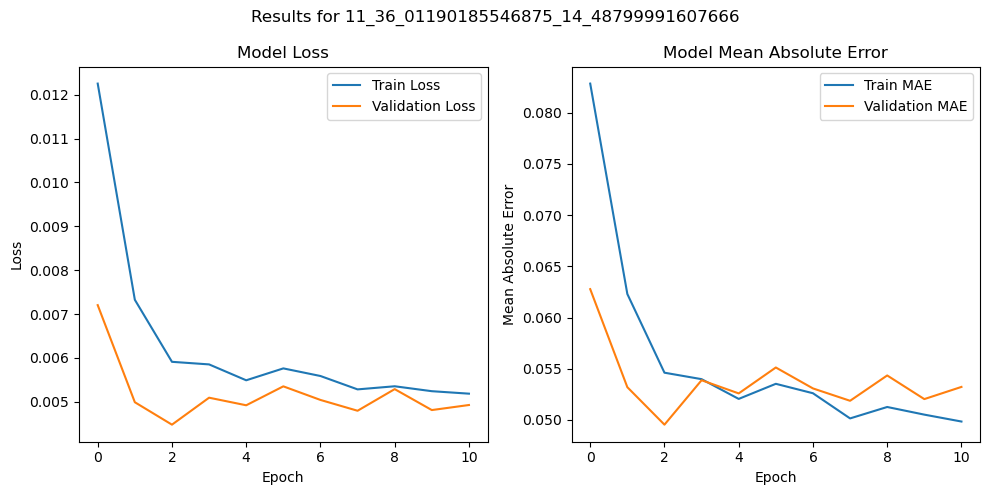

26/26 [==============================] - 9s 324ms/step

Test set Evaluation metrics for file: 11_36_01190185546875_14_48799991607666
Mean Squared Error (MSE): 0.004371261036834796
Mean Absolute Error (MAE): 0.051883578849397365
Root Mean Squared Error (RMSE): 0.06611551283046056



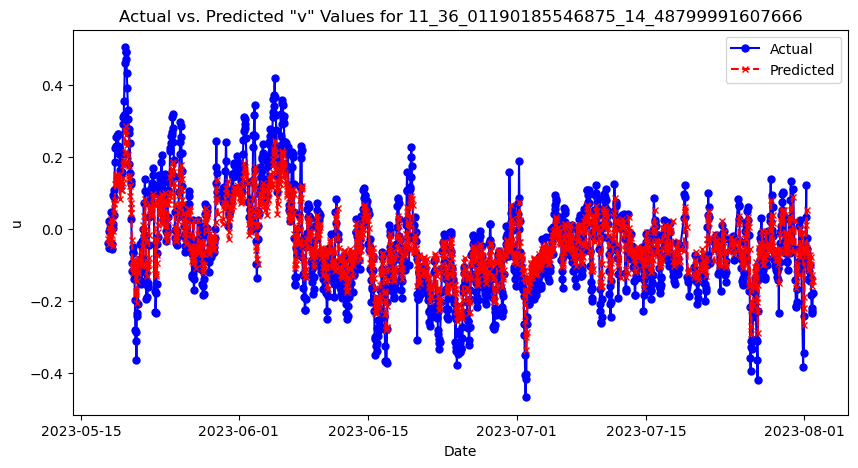

Model tarining & evaluation completed for file: 11_36_01190185546875_14_48799991607666.csv

Processing file: 12_36_01190185546875_14_528599739074707.csv

Epoch 1/100
135/135 [==============================] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0830INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\12_36_01190185546875_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 248s 2s/step - loss: 0.0128 - mean_absolute_error: 0.0830 - val_loss: 0.0106 - val_mean_absolute_error: 0.0679
Epoch 2/100
135/135 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0620INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\12_36_01190185546875_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 247s 2s/step - loss: 0.0080 - mean_absolute_error: 0.0620 - val_loss: 0.0087 - val_mean_absolute_error: 0.0564
Epoch 3/100
135/135 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0560INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\12_36_01190185546875_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 248s 2s/step - loss: 0.0069 - mean_absolute_error: 0.0560 - val_loss: 0.0087 - val_mean_absolute_error: 0.0567
Epoch 4/100
135/135 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0550INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\12_36_01190185546875_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 248s 2s/step - loss: 0.0067 - mean_absolute_error: 0.0550 - val_loss: 0.0084 - val_mean_absolute_error: 0.0549
Epoch 5/100
135/135 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0535INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\12_36_01190185546875_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\12_36_01190185546875_14_528599739074707\assets


135/135 [==============================] - 248s 2s/step - loss: 0.0066 - mean_absolute_error: 0.0535 - val_loss: 0.0082 - val_mean_absolute_error: 0.0538
Epoch 6/100
135/135 [==============================] - 243s 2s/step - loss: 0.0065 - mean_absolute_error: 0.0529 - val_loss: 0.0089 - val_mean_absolute_error: 0.0578
Epoch 7/100
135/135 [==============================] - 242s 2s/step - loss: 0.0064 - mean_absolute_error: 0.0525 - val_loss: 0.0091 - val_mean_absolute_error: 0.0586
Epoch 8/100
135/135 [==============================] - 243s 2s/step - loss: 0.0064 - mean_absolute_error: 0.0530 - val_loss: 0.0092 - val_mean_absolute_error: 0.0581
Epoch 9/100
135/135 [==============================] - 242s 2s/step - loss: 0.0064 - mean_absolute_error: 0.0520 - val_loss: 0.0087 - val_mean_absolute_error: 0.0571
Epoch 10/100
135/135 [==============================] - 243s 2s/step - loss: 0.0061 - mean_absolute_error: 0.0508 - val_loss: 0.0092 - val_mean_absolute_error: 0.0588
Epoch 11/100
13

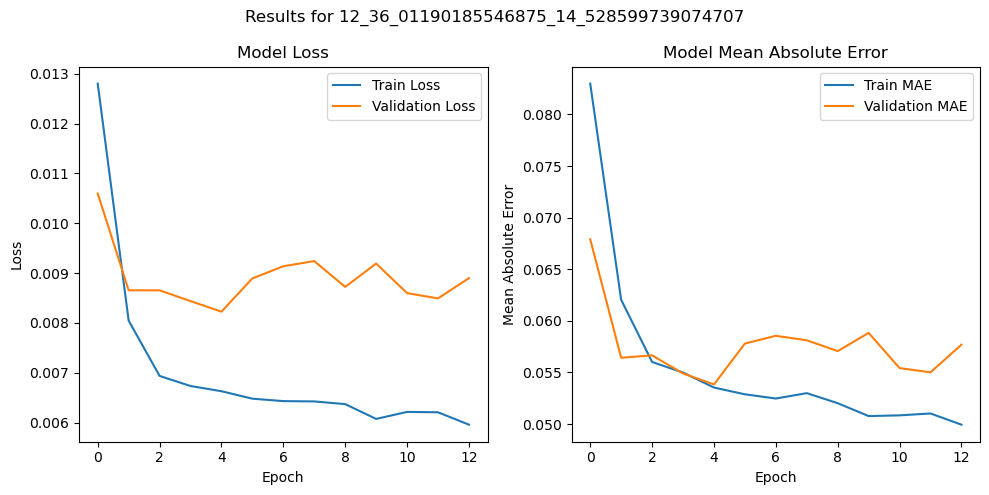

28/28 [==============================] - 10s 337ms/step

Test set Evaluation metrics for file: 12_36_01190185546875_14_528599739074707
Mean Squared Error (MSE): 0.003225733928198851
Mean Absolute Error (MAE): 0.04472067535648008
Root Mean Squared Error (RMSE): 0.05679554496788327



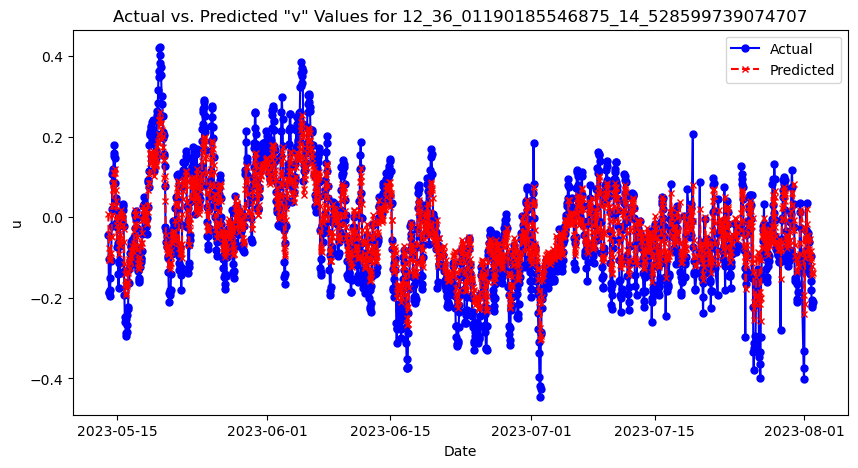

Model tarining & evaluation completed for file: 12_36_01190185546875_14_528599739074707.csv

Processing file: 13_36_01190185546875_14_569199562072754.csv

Epoch 1/100
133/133 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0793INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\13_36_01190185546875_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 259s 2s/step - loss: 0.0117 - mean_absolute_error: 0.0793 - val_loss: 0.0074 - val_mean_absolute_error: 0.0551
Epoch 2/100
133/133 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0596INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\13_36_01190185546875_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 261s 2s/step - loss: 0.0075 - mean_absolute_error: 0.0596 - val_loss: 0.0067 - val_mean_absolute_error: 0.0488
Epoch 3/100
133/133 [==============================] - 258s 2s/step - loss: 0.0065 - mean_absolute_error: 0.0544 - val_loss: 0.0070 - val_mean_absolute_error: 0.0500
Epoch 4/100
133/133 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0536INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\13_36_01190185546875_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 262s 2s/step - loss: 0.0065 - mean_absolute_error: 0.0536 - val_loss: 0.0066 - val_mean_absolute_error: 0.0477
Epoch 5/100
133/133 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0528INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\13_36_01190185546875_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 291s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0528 - val_loss: 0.0064 - val_mean_absolute_error: 0.0476
Epoch 6/100
133/133 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0511INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\13_36_01190185546875_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 261s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0511 - val_loss: 0.0063 - val_mean_absolute_error: 0.0465
Epoch 7/100
133/133 [==============================] - 259s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0513 - val_loss: 0.0067 - val_mean_absolute_error: 0.0486
Epoch 8/100
133/133 [==============================] - 259s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0506 - val_loss: 0.0064 - val_mean_absolute_error: 0.0471
Epoch 9/100
133/133 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0504INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\13_36_01190185546875_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 265s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0504 - val_loss: 0.0063 - val_mean_absolute_error: 0.0472
Epoch 10/100
133/133 [==============================] - 259s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0495 - val_loss: 0.0065 - val_mean_absolute_error: 0.0484
Epoch 11/100
133/133 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0494INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\13_36_01190185546875_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 265s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0494 - val_loss: 0.0062 - val_mean_absolute_error: 0.0463
Epoch 12/100
133/133 [==============================] - 260s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0487 - val_loss: 0.0065 - val_mean_absolute_error: 0.0484
Epoch 13/100
133/133 [==============================] - 260s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0476 - val_loss: 0.0063 - val_mean_absolute_error: 0.0474
Epoch 14/100
133/133 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0487INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\13_36_01190185546875_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 264s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0487 - val_loss: 0.0062 - val_mean_absolute_error: 0.0462
Epoch 15/100
133/133 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0475INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\13_36_01190185546875_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 264s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0475 - val_loss: 0.0061 - val_mean_absolute_error: 0.0459
Epoch 16/100
133/133 [==============================] - 261s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0477 - val_loss: 0.0065 - val_mean_absolute_error: 0.0489
Epoch 17/100
133/133 [==============================] - 259s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0477 - val_loss: 0.0064 - val_mean_absolute_error: 0.0471
Epoch 18/100
133/133 [==============================] - 261s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0469 - val_loss: 0.0062 - val_mean_absolute_error: 0.0472
Epoch 19/100
133/133 [==============================] - 259s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0461 - val_loss: 0.0063 - val_mean_absolute_error: 0.0462
Epoch 20/100
133/133 [==============================] - 260s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0460 - val_loss: 0.0066 - val_mean_absolute_error: 0.0478
Epoch 21/10

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\13_36_01190185546875_14_569199562072754\assets


133/133 [==============================] - 265s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0453 - val_loss: 0.0058 - val_mean_absolute_error: 0.0436
Epoch 23/100
133/133 [==============================] - 261s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0459 - val_loss: 0.0060 - val_mean_absolute_error: 0.0449
Epoch 24/100
133/133 [==============================] - 260s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0461 - val_loss: 0.0061 - val_mean_absolute_error: 0.0446
Epoch 25/100
133/133 [==============================] - 260s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0446 - val_loss: 0.0061 - val_mean_absolute_error: 0.0457
Epoch 26/100
133/133 [==============================] - 259s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0458 - val_loss: 0.0062 - val_mean_absolute_error: 0.0458
Epoch 27/100
133/133 [==============================] - 260s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0455 - val_loss: 0.0062 - val_mean_absolute_error: 0.0458
Epoch 28/10

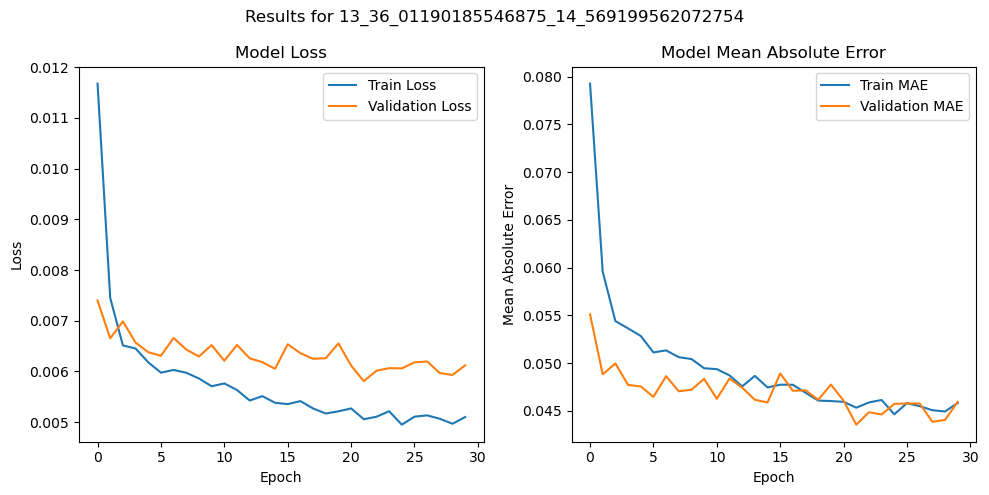

28/28 [==============================] - 11s 363ms/step

Test set Evaluation metrics for file: 13_36_01190185546875_14_569199562072754
Mean Squared Error (MSE): 0.002560295950491681
Mean Absolute Error (MAE): 0.036893078431708415
Root Mean Squared Error (RMSE): 0.05059936709576199



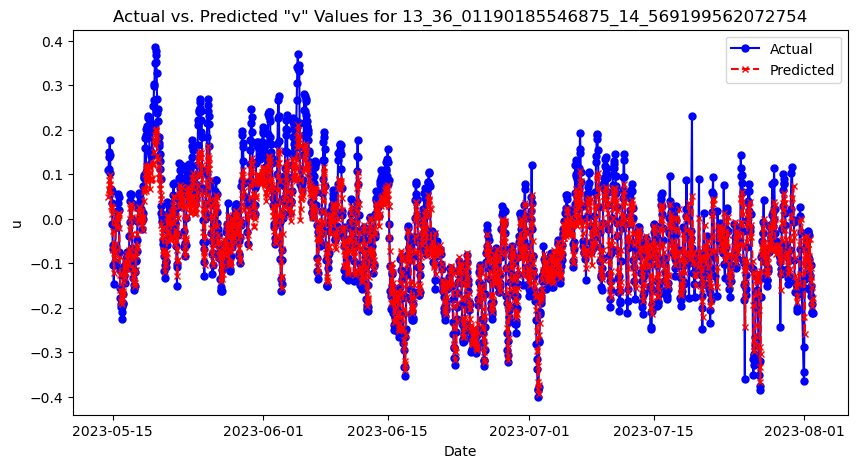

Model tarining & evaluation completed for file: 13_36_01190185546875_14_569199562072754.csv

Processing file: 14_36_03409957885742_14_447500228881836.csv

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.0797INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 256s 2s/step - loss: 0.0115 - mean_absolute_error: 0.0797 - val_loss: 0.0073 - val_mean_absolute_error: 0.0689
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0624INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 252s 2s/step - loss: 0.0074 - mean_absolute_error: 0.0624 - val_loss: 0.0069 - val_mean_absolute_error: 0.0680
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0568INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 260s 2s/step - loss: 0.0065 - mean_absolute_error: 0.0568 - val_loss: 0.0053 - val_mean_absolute_error: 0.0575
Epoch 4/100
125/125 [==============================] - 276s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0559 - val_loss: 0.0061 - val_mean_absolute_error: 0.0629
Epoch 5/100
125/125 [==============================] - 277s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0556 - val_loss: 0.0061 - val_mean_absolute_error: 0.0627
Epoch 6/100
125/125 [==============================] - 277s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0534 - val_loss: 0.0059 - val_mean_absolute_error: 0.0613
Epoch 7/100
125/125 [==============================] - 276s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0530 - val_loss: 0.0057 - val_mean_absolute_error: 0.0602
Epoch 8/100
125/125 [==============================] - 276s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0535 - val_loss: 0.0060 - val_mean_absolute_error: 0.0622
Epoch 9/100
125/

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 281s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0522 - val_loss: 0.0045 - val_mean_absolute_error: 0.0525
Epoch 12/100
125/125 [==============================] - 286s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0510 - val_loss: 0.0047 - val_mean_absolute_error: 0.0539
Epoch 13/100
125/125 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 295s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0510 - val_loss: 0.0044 - val_mean_absolute_error: 0.0516
Epoch 14/100
125/125 [==============================] - 301s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0520 - val_loss: 0.0045 - val_mean_absolute_error: 0.0526
Epoch 15/100
125/125 [==============================] - 302s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0515 - val_loss: 0.0046 - val_mean_absolute_error: 0.0531
Epoch 16/100
125/125 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0511INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 306s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0511 - val_loss: 0.0042 - val_mean_absolute_error: 0.0507
Epoch 17/100
125/125 [==============================] - 269s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0515 - val_loss: 0.0043 - val_mean_absolute_error: 0.0511
Epoch 18/100
125/125 [==============================] - 268s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0512 - val_loss: 0.0046 - val_mean_absolute_error: 0.0530
Epoch 19/100
125/125 [==============================] - 269s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0494 - val_loss: 0.0044 - val_mean_absolute_error: 0.0517
Epoch 20/100
125/125 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0505INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 273s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0505 - val_loss: 0.0040 - val_mean_absolute_error: 0.0492
Epoch 21/100
125/125 [==============================] - 268s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0502 - val_loss: 0.0042 - val_mean_absolute_error: 0.0503
Epoch 22/100
125/125 [==============================] - 267s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0495 - val_loss: 0.0043 - val_mean_absolute_error: 0.0511
Epoch 23/100
125/125 [==============================] - 268s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0498 - val_loss: 0.0042 - val_mean_absolute_error: 0.0510
Epoch 24/100
125/125 [==============================] - 268s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0499 - val_loss: 0.0042 - val_mean_absolute_error: 0.0508
Epoch 25/100
125/125 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0506INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_3

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 272s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0506 - val_loss: 0.0038 - val_mean_absolute_error: 0.0472
Epoch 26/100
125/125 [==============================] - 267s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0492 - val_loss: 0.0046 - val_mean_absolute_error: 0.0532
Epoch 27/100
125/125 [==============================] - 266s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0496 - val_loss: 0.0038 - val_mean_absolute_error: 0.0479
Epoch 28/100
125/125 [==============================] - 268s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0499 - val_loss: 0.0042 - val_mean_absolute_error: 0.0504
Epoch 29/100
125/125 [==============================] - 267s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0493 - val_loss: 0.0041 - val_mean_absolute_error: 0.0495
Epoch 30/100
125/125 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0495INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_3

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 271s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0495 - val_loss: 0.0035 - val_mean_absolute_error: 0.0451
Epoch 31/100
125/125 [==============================] - 267s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0490 - val_loss: 0.0040 - val_mean_absolute_error: 0.0491
Epoch 32/100
125/125 [==============================] - 269s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0496 - val_loss: 0.0040 - val_mean_absolute_error: 0.0492
Epoch 33/100
125/125 [==============================] - 259s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0488 - val_loss: 0.0036 - val_mean_absolute_error: 0.0455
Epoch 34/100
125/125 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0501INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 262s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0501 - val_loss: 0.0034 - val_mean_absolute_error: 0.0442
Epoch 35/100
125/125 [==============================] - 257s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0500 - val_loss: 0.0036 - val_mean_absolute_error: 0.0461
Epoch 36/100
125/125 [==============================] - 268s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0491 - val_loss: 0.0035 - val_mean_absolute_error: 0.0453
Epoch 37/100
125/125 [==============================] - 267s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0491 - val_loss: 0.0035 - val_mean_absolute_error: 0.0453
Epoch 38/100
125/125 [==============================] - 266s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0486 - val_loss: 0.0039 - val_mean_absolute_error: 0.0482
Epoch 39/100
125/125 [==============================] - 267s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0487 - val_loss: 0.0035 - val_mean_absolute_error: 0.0450
Epoch 40/10

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 266s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0496 - val_loss: 0.0034 - val_mean_absolute_error: 0.0440
Epoch 42/100
125/125 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0486INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 262s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0486 - val_loss: 0.0033 - val_mean_absolute_error: 0.0439
Epoch 43/100
125/125 [==============================] - 261s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0489 - val_loss: 0.0034 - val_mean_absolute_error: 0.0445
Epoch 44/100
125/125 [==============================] - 263s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0486 - val_loss: 0.0036 - val_mean_absolute_error: 0.0461
Epoch 45/100
125/125 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0493INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 268s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0493 - val_loss: 0.0033 - val_mean_absolute_error: 0.0438
Epoch 46/100
125/125 [==============================] - 268s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0484 - val_loss: 0.0034 - val_mean_absolute_error: 0.0446
Epoch 47/100
125/125 [==============================] - 258s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0486 - val_loss: 0.0035 - val_mean_absolute_error: 0.0450
Epoch 48/100
125/125 [==============================] - 260s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0486 - val_loss: 0.0037 - val_mean_absolute_error: 0.0469
Epoch 49/100
125/125 [==============================] - 267s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0483 - val_loss: 0.0034 - val_mean_absolute_error: 0.0440
Epoch 50/100
125/125 [==============================] - 278s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0492 - val_loss: 0.0033 - val_mean_absolute_error: 0.0438
Epoch 51/10

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\14_36_03409957885742_14_447500228881836\assets


125/125 [==============================] - 282s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0492 - val_loss: 0.0033 - val_mean_absolute_error: 0.0430
Epoch 54/100
125/125 [==============================] - 298s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0481 - val_loss: 0.0036 - val_mean_absolute_error: 0.0462
Epoch 55/100
125/125 [==============================] - 294s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0482 - val_loss: 0.0036 - val_mean_absolute_error: 0.0459
Epoch 56/100
125/125 [==============================] - 289s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0491 - val_loss: 0.0033 - val_mean_absolute_error: 0.0431
Epoch 57/100
125/125 [==============================] - 289s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0478 - val_loss: 0.0037 - val_mean_absolute_error: 0.0470
Epoch 58/100
125/125 [==============================] - 298s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0484 - val_loss: 0.0036 - val_mean_absolute_error: 0.0459
Epoch 59/10

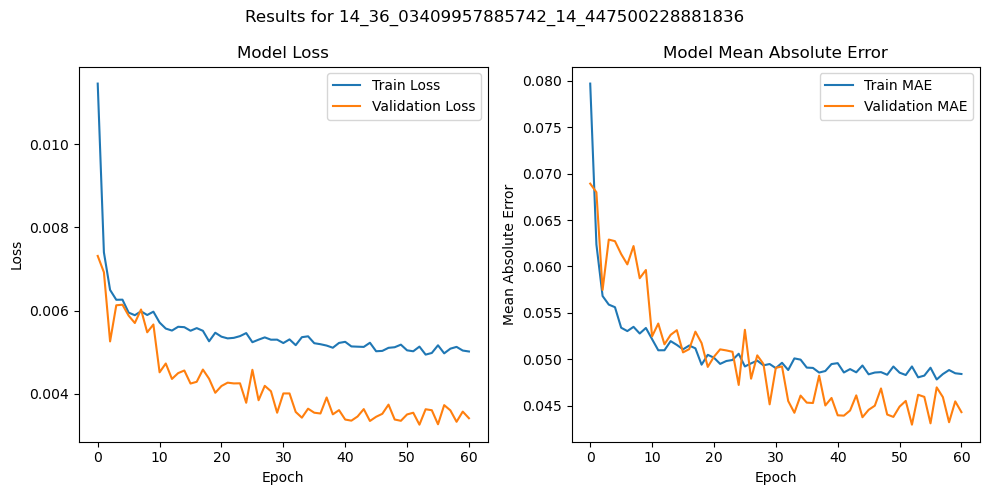

26/26 [==============================] - 12s 395ms/step

Test set Evaluation metrics for file: 14_36_03409957885742_14_447500228881836
Mean Squared Error (MSE): 0.003929269102751062
Mean Absolute Error (MAE): 0.047019571830218036
Root Mean Squared Error (RMSE): 0.0626838823203466



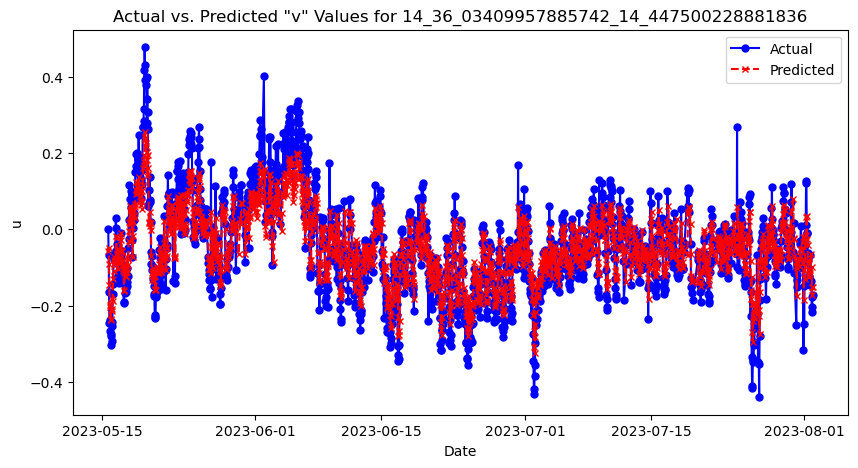

Model tarining & evaluation completed for file: 14_36_03409957885742_14_447500228881836.csv

Processing file: 15_36_03409957885742_14_48799991607666.csv

Epoch 1/100
137/137 [==============================] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0769INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\15_36_03409957885742_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\15_36_03409957885742_14_48799991607666\assets


137/137 [==============================] - 289s 2s/step - loss: 0.0110 - mean_absolute_error: 0.0769 - val_loss: 0.0070 - val_mean_absolute_error: 0.0654
Epoch 2/100
137/137 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0603INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\15_36_03409957885742_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\15_36_03409957885742_14_48799991607666\assets


137/137 [==============================] - 287s 2s/step - loss: 0.0070 - mean_absolute_error: 0.0603 - val_loss: 0.0057 - val_mean_absolute_error: 0.0591
Epoch 3/100
137/137 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0524INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\15_36_03409957885742_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\15_36_03409957885742_14_48799991607666\assets


137/137 [==============================] - 283s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0524 - val_loss: 0.0045 - val_mean_absolute_error: 0.0502
Epoch 4/100
137/137 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0514INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\15_36_03409957885742_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\15_36_03409957885742_14_48799991607666\assets


137/137 [==============================] - 301s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0514 - val_loss: 0.0040 - val_mean_absolute_error: 0.0467
Epoch 5/100
137/137 [==============================] - 309s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0501 - val_loss: 0.0042 - val_mean_absolute_error: 0.0485
Epoch 6/100
137/137 [==============================] - 306s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0500 - val_loss: 0.0044 - val_mean_absolute_error: 0.0501
Epoch 7/100
137/137 [==============================] - 295s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0500 - val_loss: 0.0044 - val_mean_absolute_error: 0.0503
Epoch 8/100
137/137 [==============================] - 295s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0505 - val_loss: 0.0048 - val_mean_absolute_error: 0.0528
Epoch 9/100
137/137 [==============================] - 305s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0490 - val_loss: 0.0043 - val_mean_absolute_error: 0.0489
Epoch 10/100
137

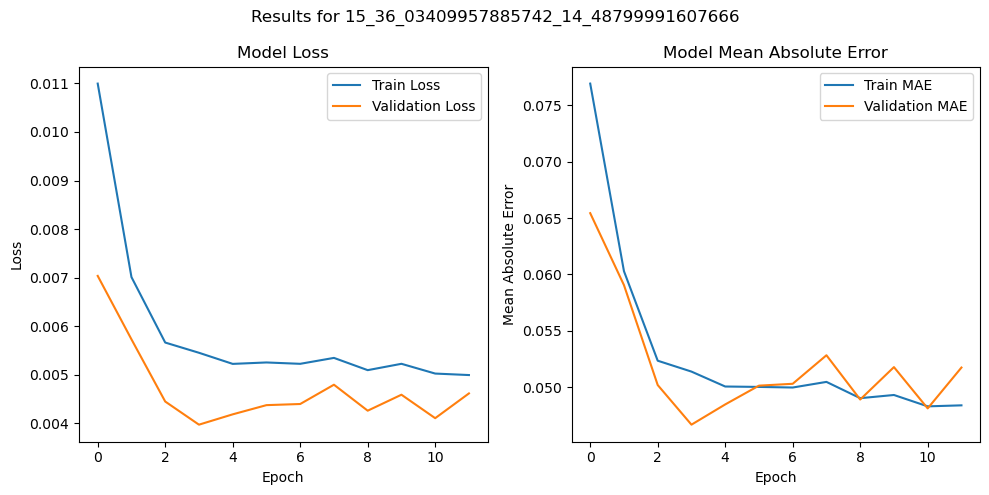

29/29 [==============================] - 13s 411ms/step

Test set Evaluation metrics for file: 15_36_03409957885742_14_48799991607666
Mean Squared Error (MSE): 0.0032737264410202874
Mean Absolute Error (MAE): 0.04386970062698425
Root Mean Squared Error (RMSE): 0.057216487492857224



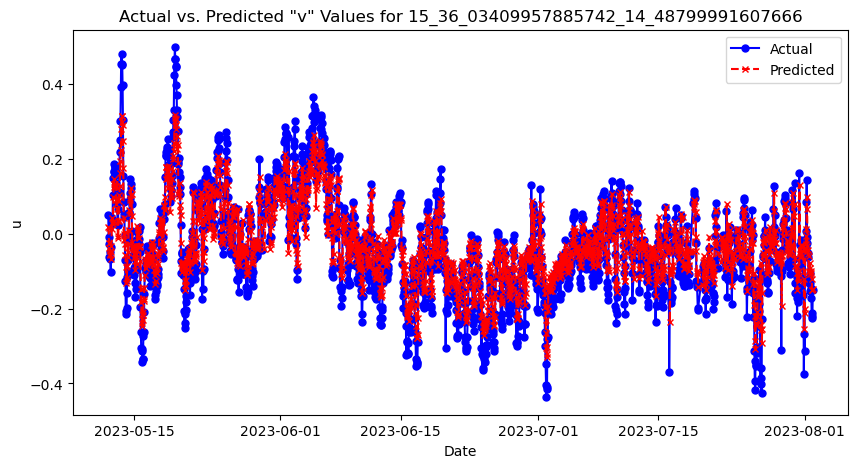

Model tarining & evaluation completed for file: 15_36_03409957885742_14_48799991607666.csv

Processing file: 16_36_03409957885742_14_528599739074707.csv

Epoch 1/100
156/156 [==============================] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.0814INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\16_36_03409957885742_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 352s 2s/step - loss: 0.0125 - mean_absolute_error: 0.0814 - val_loss: 0.0084 - val_mean_absolute_error: 0.0594
Epoch 2/100
156/156 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0621INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\16_36_03409957885742_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 351s 2s/step - loss: 0.0081 - mean_absolute_error: 0.0621 - val_loss: 0.0076 - val_mean_absolute_error: 0.0539
Epoch 3/100
156/156 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0562INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\16_36_03409957885742_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 351s 2s/step - loss: 0.0070 - mean_absolute_error: 0.0562 - val_loss: 0.0074 - val_mean_absolute_error: 0.0525
Epoch 4/100
156/156 [==============================] - 338s 2s/step - loss: 0.0067 - mean_absolute_error: 0.0548 - val_loss: 0.0075 - val_mean_absolute_error: 0.0532
Epoch 5/100
156/156 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0548INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\16_36_03409957885742_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 338s 2s/step - loss: 0.0068 - mean_absolute_error: 0.0548 - val_loss: 0.0074 - val_mean_absolute_error: 0.0535
Epoch 6/100
156/156 [==============================] - 336s 2s/step - loss: 0.0067 - mean_absolute_error: 0.0543 - val_loss: 0.0075 - val_mean_absolute_error: 0.0535
Epoch 7/100
156/156 [==============================] - 348s 2s/step - loss: 0.0064 - mean_absolute_error: 0.0526 - val_loss: 0.0077 - val_mean_absolute_error: 0.0555
Epoch 8/100
156/156 [==============================] - 346s 2s/step - loss: 0.0065 - mean_absolute_error: 0.0529 - val_loss: 0.0076 - val_mean_absolute_error: 0.0549
Epoch 9/100
156/156 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0522INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\16_36_03409957885742_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 351s 2s/step - loss: 0.0064 - mean_absolute_error: 0.0522 - val_loss: 0.0074 - val_mean_absolute_error: 0.0528
Epoch 10/100
156/156 [==============================] - 339s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0525 - val_loss: 0.0077 - val_mean_absolute_error: 0.0548
Epoch 11/100
156/156 [==============================] - 332s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0515 - val_loss: 0.0074 - val_mean_absolute_error: 0.0534
Epoch 12/100
156/156 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0513INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\16_36_03409957885742_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 336s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0513 - val_loss: 0.0072 - val_mean_absolute_error: 0.0514
Epoch 13/100
156/156 [==============================] - 350s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0512 - val_loss: 0.0078 - val_mean_absolute_error: 0.0551
Epoch 14/100
156/156 [==============================] - 347s 2s/step - loss: 0.0061 - mean_absolute_error: 0.0512 - val_loss: 0.0075 - val_mean_absolute_error: 0.0541
Epoch 15/100
156/156 [==============================] - 347s 2s/step - loss: 0.0061 - mean_absolute_error: 0.0511 - val_loss: 0.0077 - val_mean_absolute_error: 0.0556
Epoch 16/100
156/156 [==============================] - 346s 2s/step - loss: 0.0062 - mean_absolute_error: 0.0514 - val_loss: 0.0075 - val_mean_absolute_error: 0.0538
Epoch 17/100
156/156 [==============================] - 346s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0508 - val_loss: 0.0076 - val_mean_absolute_error: 0.0558
Epoch 18/10

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\16_36_03409957885742_14_528599739074707\assets


156/156 [==============================] - 351s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0506 - val_loss: 0.0070 - val_mean_absolute_error: 0.0517
Epoch 19/100
156/156 [==============================] - 348s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0506 - val_loss: 0.0073 - val_mean_absolute_error: 0.0528
Epoch 20/100
156/156 [==============================] - 347s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0503 - val_loss: 0.0074 - val_mean_absolute_error: 0.0541
Epoch 21/100
156/156 [==============================] - 348s 2s/step - loss: 0.0061 - mean_absolute_error: 0.0511 - val_loss: 0.0074 - val_mean_absolute_error: 0.0536
Epoch 22/100
156/156 [==============================] - 341s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0502 - val_loss: 0.0077 - val_mean_absolute_error: 0.0552
Epoch 23/100
156/156 [==============================] - 334s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0503 - val_loss: 0.0073 - val_mean_absolute_error: 0.0534
Epoch 24/10

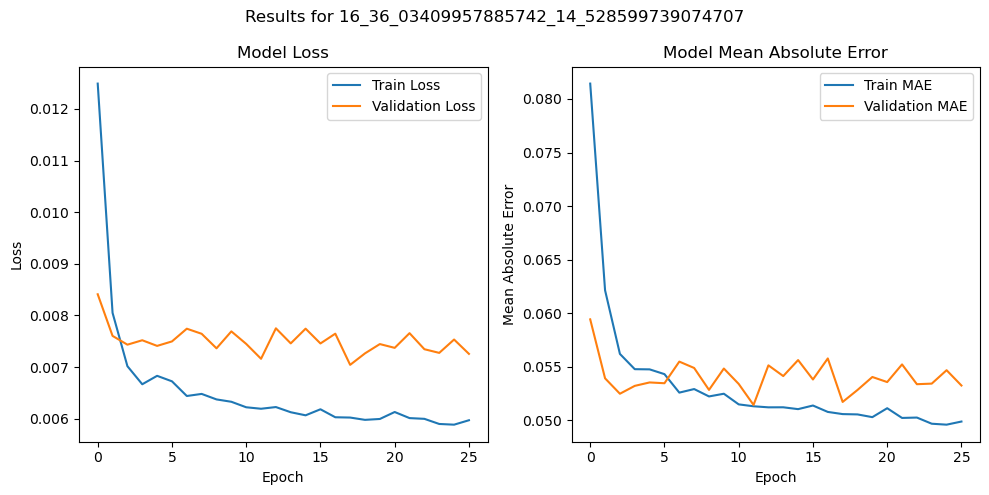

33/33 [==============================] - 14s 416ms/step

Test set Evaluation metrics for file: 16_36_03409957885742_14_528599739074707
Mean Squared Error (MSE): 0.004047697193968542
Mean Absolute Error (MAE): 0.04711104990740106
Root Mean Squared Error (RMSE): 0.06362151518133266



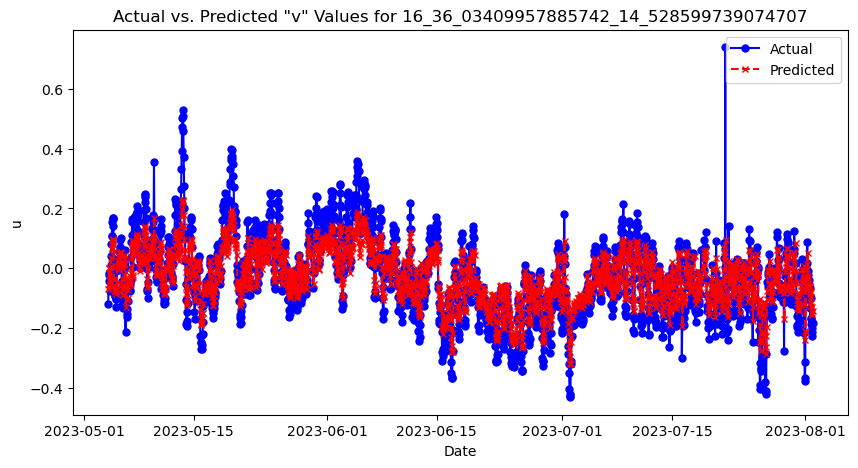

Model tarining & evaluation completed for file: 16_36_03409957885742_14_528599739074707.csv

Processing file: 17_36_03409957885742_14_569199562072754.csv

Epoch 1/100
153/153 [==============================] - ETA: 0s - loss: 0.0116 - mean_absolute_error: 0.0794INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\17_36_03409957885742_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\17_36_03409957885742_14_569199562072754\assets


153/153 [==============================] - 348s 2s/step - loss: 0.0116 - mean_absolute_error: 0.0794 - val_loss: 0.0078 - val_mean_absolute_error: 0.0557
Epoch 2/100
153/153 [==============================] - 347s 2s/step - loss: 0.0078 - mean_absolute_error: 0.0617 - val_loss: 0.0078 - val_mean_absolute_error: 0.0566
Epoch 3/100
153/153 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0579INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\17_36_03409957885742_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\17_36_03409957885742_14_569199562072754\assets


153/153 [==============================] - 353s 2s/step - loss: 0.0072 - mean_absolute_error: 0.0579 - val_loss: 0.0073 - val_mean_absolute_error: 0.0532
Epoch 4/100
153/153 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0560INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\17_36_03409957885742_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\17_36_03409957885742_14_569199562072754\assets


153/153 [==============================] - 352s 2s/step - loss: 0.0069 - mean_absolute_error: 0.0560 - val_loss: 0.0070 - val_mean_absolute_error: 0.0510
Epoch 5/100
153/153 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0551INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\17_36_03409957885742_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\17_36_03409957885742_14_569199562072754\assets


153/153 [==============================] - 344s 2s/step - loss: 0.0068 - mean_absolute_error: 0.0551 - val_loss: 0.0070 - val_mean_absolute_error: 0.0506
Epoch 6/100
153/153 [==============================] - 337s 2s/step - loss: 0.0065 - mean_absolute_error: 0.0536 - val_loss: 0.0072 - val_mean_absolute_error: 0.0520
Epoch 7/100
153/153 [==============================] - 342s 2s/step - loss: 0.0064 - mean_absolute_error: 0.0529 - val_loss: 0.0070 - val_mean_absolute_error: 0.0505
Epoch 8/100
153/153 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0526INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\17_36_03409957885742_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\17_36_03409957885742_14_569199562072754\assets


153/153 [==============================] - 358s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0526 - val_loss: 0.0069 - val_mean_absolute_error: 0.0504
Epoch 9/100
153/153 [==============================] - 377s 2s/step - loss: 0.0061 - mean_absolute_error: 0.0513 - val_loss: 0.0072 - val_mean_absolute_error: 0.0526
Epoch 10/100
153/153 [==============================] - 377s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0509 - val_loss: 0.0069 - val_mean_absolute_error: 0.0502
Epoch 11/100
153/153 [==============================] - 375s 2s/step - loss: 0.0061 - mean_absolute_error: 0.0511 - val_loss: 0.0074 - val_mean_absolute_error: 0.0533
Epoch 12/100
153/153 [==============================] - 374s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0505 - val_loss: 0.0071 - val_mean_absolute_error: 0.0519
Epoch 13/100
153/153 [==============================] - 375s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0509 - val_loss: 0.0073 - val_mean_absolute_error: 0.0527
Epoch 14/100

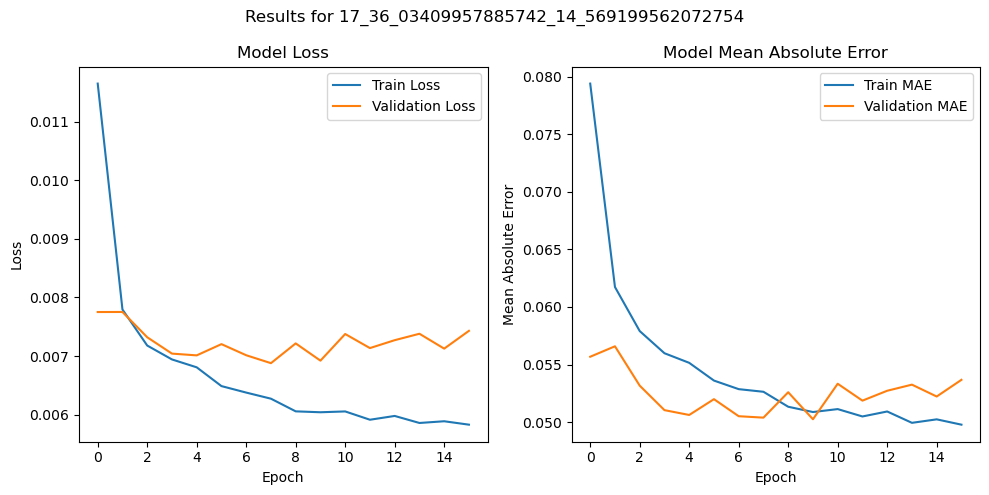

32/32 [==============================] - 15s 427ms/step

Test set Evaluation metrics for file: 17_36_03409957885742_14_569199562072754
Mean Squared Error (MSE): 0.003103460750359176
Mean Absolute Error (MAE): 0.04019554959871975
Root Mean Squared Error (RMSE): 0.055708713415041064



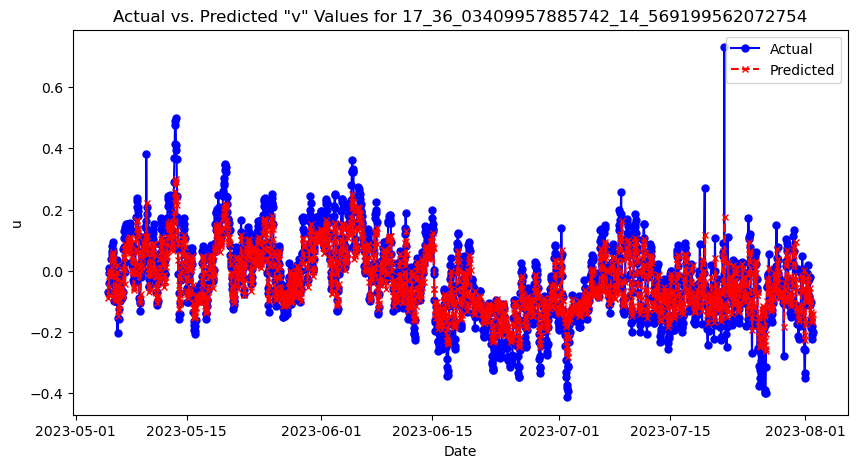

Model tarining & evaluation completed for file: 17_36_03409957885742_14_569199562072754.csv

Processing file: 18_36_056400299072266_14_447500228881836.csv

Epoch 1/100
128/128 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0755INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 294s 2s/step - loss: 0.0104 - mean_absolute_error: 0.0755 - val_loss: 0.0065 - val_mean_absolute_error: 0.0645
Epoch 2/100
128/128 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0589INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 292s 2s/step - loss: 0.0065 - mean_absolute_error: 0.0589 - val_loss: 0.0048 - val_mean_absolute_error: 0.0557
Epoch 3/100
128/128 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0515INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 292s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0515 - val_loss: 0.0043 - val_mean_absolute_error: 0.0526
Epoch 4/100
128/128 [==============================] - 287s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0505 - val_loss: 0.0046 - val_mean_absolute_error: 0.0546
Epoch 5/100
128/128 [==============================] - 285s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0493 - val_loss: 0.0043 - val_mean_absolute_error: 0.0526
Epoch 6/100
128/128 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0485INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 290s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0485 - val_loss: 0.0038 - val_mean_absolute_error: 0.0491
Epoch 7/100
128/128 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.0488INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 299s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0488 - val_loss: 0.0034 - val_mean_absolute_error: 0.0452
Epoch 8/100
128/128 [==============================] - 295s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0478 - val_loss: 0.0039 - val_mean_absolute_error: 0.0498
Epoch 9/100
128/128 [==============================] - 297s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0489 - val_loss: 0.0037 - val_mean_absolute_error: 0.0478
Epoch 10/100
128/128 [==============================] - 295s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0483 - val_loss: 0.0035 - val_mean_absolute_error: 0.0464
Epoch 11/100
128/128 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0479INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 300s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0479 - val_loss: 0.0029 - val_mean_absolute_error: 0.0415
Epoch 12/100
128/128 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0463INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 327s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0463 - val_loss: 0.0029 - val_mean_absolute_error: 0.0414
Epoch 13/100
128/128 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0479INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 308s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0479 - val_loss: 0.0027 - val_mean_absolute_error: 0.0397
Epoch 14/100
128/128 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0468INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 307s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0468 - val_loss: 0.0025 - val_mean_absolute_error: 0.0374
Epoch 15/100
128/128 [==============================] - 303s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0469 - val_loss: 0.0030 - val_mean_absolute_error: 0.0417
Epoch 16/100
128/128 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0465INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 309s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0465 - val_loss: 0.0025 - val_mean_absolute_error: 0.0370
Epoch 17/100
128/128 [==============================] - 303s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0463 - val_loss: 0.0027 - val_mean_absolute_error: 0.0395
Epoch 18/100
128/128 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0464INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 308s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0464 - val_loss: 0.0024 - val_mean_absolute_error: 0.0366
Epoch 19/100
128/128 [==============================] - 302s 2s/step - loss: 0.0044 - mean_absolute_error: 0.0455 - val_loss: 0.0025 - val_mean_absolute_error: 0.0377
Epoch 20/100
128/128 [==============================] - 306s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0463 - val_loss: 0.0026 - val_mean_absolute_error: 0.0381
Epoch 21/100
128/128 [==============================] - 304s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0466 - val_loss: 0.0025 - val_mean_absolute_error: 0.0367
Epoch 22/100
128/128 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0461INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\18_36_056400299072266_14_447500228881836\assets


128/128 [==============================] - 309s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0461 - val_loss: 0.0023 - val_mean_absolute_error: 0.0354
Epoch 23/100
128/128 [==============================] - 302s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0458 - val_loss: 0.0026 - val_mean_absolute_error: 0.0380
Epoch 24/100
128/128 [==============================] - 303s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0462 - val_loss: 0.0025 - val_mean_absolute_error: 0.0366
Epoch 25/100
128/128 [==============================] - 303s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0463 - val_loss: 0.0025 - val_mean_absolute_error: 0.0372
Epoch 26/100
128/128 [==============================] - 303s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0457 - val_loss: 0.0024 - val_mean_absolute_error: 0.0362
Epoch 27/100
128/128 [==============================] - 302s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0462 - val_loss: 0.0024 - val_mean_absolute_error: 0.0364
Epoch 28/10

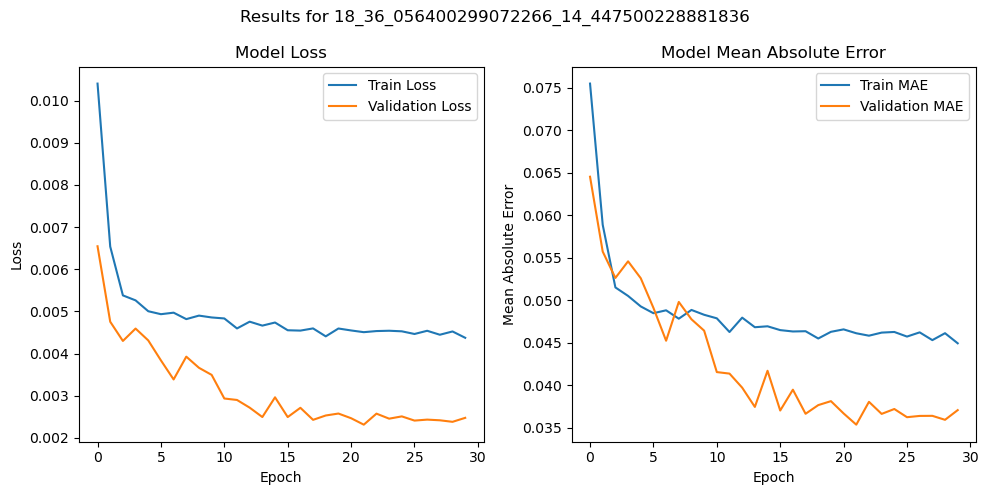

27/27 [==============================] - 12s 437ms/step

Test set Evaluation metrics for file: 18_36_056400299072266_14_447500228881836
Mean Squared Error (MSE): 0.002512956611666382
Mean Absolute Error (MAE): 0.036782553369585747
Root Mean Squared Error (RMSE): 0.050129398676489044



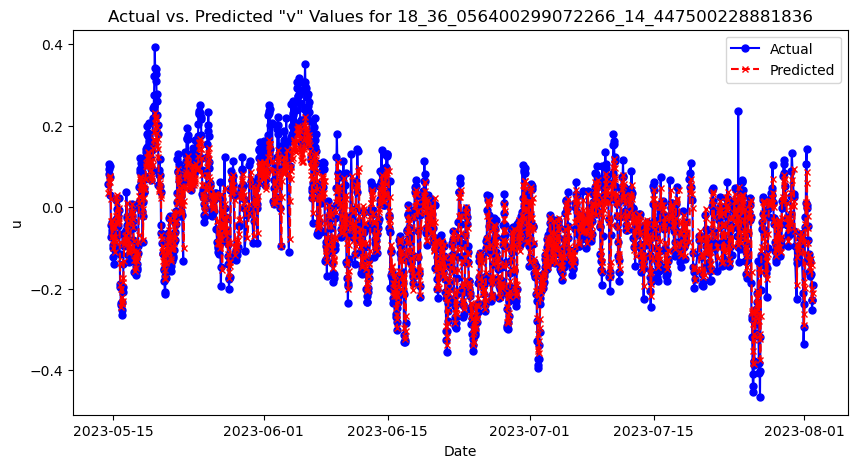

Model tarining & evaluation completed for file: 18_36_056400299072266_14_447500228881836.csv

Processing file: 19_36_056400299072266_14_48799991607666.csv

Epoch 1/100
138/138 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0735INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\19_36_056400299072266_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 329s 2s/step - loss: 0.0101 - mean_absolute_error: 0.0735 - val_loss: 0.0044 - val_mean_absolute_error: 0.0510
Epoch 2/100
138/138 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0571INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\19_36_056400299072266_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 323s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0571 - val_loss: 0.0043 - val_mean_absolute_error: 0.0509
Epoch 3/100
138/138 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0519INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\19_36_056400299072266_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 353s 3s/step - loss: 0.0055 - mean_absolute_error: 0.0519 - val_loss: 0.0039 - val_mean_absolute_error: 0.0482
Epoch 4/100
138/138 [==============================] - 310s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0495 - val_loss: 0.0041 - val_mean_absolute_error: 0.0494
Epoch 5/100
138/138 [==============================] - 311s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0508 - val_loss: 0.0043 - val_mean_absolute_error: 0.0510
Epoch 6/100
138/138 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0502INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\19_36_056400299072266_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 326s 2s/step - loss: 0.0052 - mean_absolute_error: 0.0502 - val_loss: 0.0036 - val_mean_absolute_error: 0.0462
Epoch 7/100
138/138 [==============================] - 324s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0485 - val_loss: 0.0042 - val_mean_absolute_error: 0.0499
Epoch 8/100
138/138 [==============================] - 319s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0481 - val_loss: 0.0041 - val_mean_absolute_error: 0.0493
Epoch 9/100
138/138 [==============================] - 310s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0485 - val_loss: 0.0039 - val_mean_absolute_error: 0.0480
Epoch 10/100
138/138 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0478INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\19_36_056400299072266_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 315s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0478 - val_loss: 0.0035 - val_mean_absolute_error: 0.0452
Epoch 11/100
138/138 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0469INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\19_36_056400299072266_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 332s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0469 - val_loss: 0.0035 - val_mean_absolute_error: 0.0453
Epoch 12/100
138/138 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0471INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\19_36_056400299072266_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\19_36_056400299072266_14_48799991607666\assets


138/138 [==============================] - 328s 2s/step - loss: 0.0047 - mean_absolute_error: 0.0471 - val_loss: 0.0034 - val_mean_absolute_error: 0.0442
Epoch 13/100
138/138 [==============================] - 323s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0462 - val_loss: 0.0035 - val_mean_absolute_error: 0.0455
Epoch 14/100
138/138 [==============================] - 321s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0463 - val_loss: 0.0039 - val_mean_absolute_error: 0.0486
Epoch 15/100
138/138 [==============================] - 310s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0466 - val_loss: 0.0038 - val_mean_absolute_error: 0.0480
Epoch 16/100
138/138 [==============================] - 310s 2s/step - loss: 0.0046 - mean_absolute_error: 0.0465 - val_loss: 0.0034 - val_mean_absolute_error: 0.0445
Epoch 17/100
138/138 [==============================] - 318s 2s/step - loss: 0.0045 - mean_absolute_error: 0.0457 - val_loss: 0.0037 - val_mean_absolute_error: 0.0469
Epoch 18/10

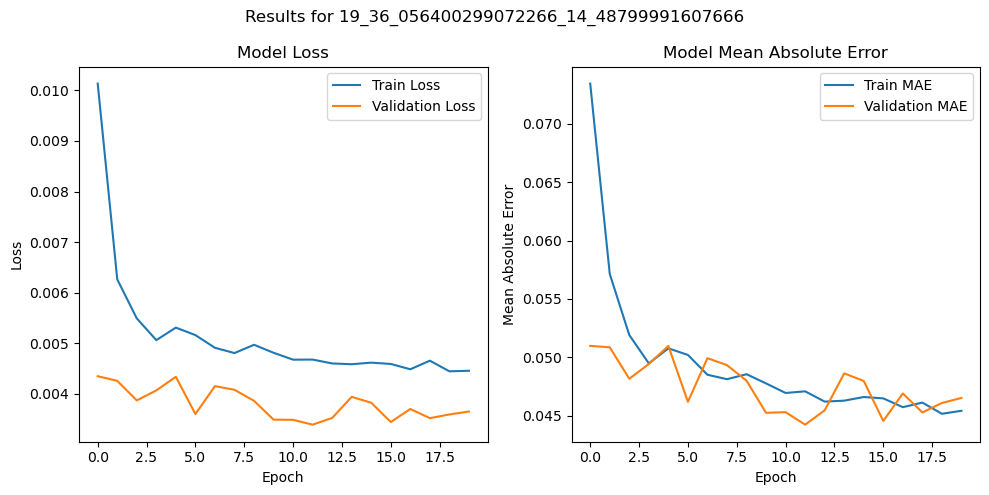

29/29 [==============================] - 13s 438ms/step

Test set Evaluation metrics for file: 19_36_056400299072266_14_48799991607666
Mean Squared Error (MSE): 0.003354882180260988
Mean Absolute Error (MAE): 0.04431276755996613
Root Mean Squared Error (RMSE): 0.057921344772553306



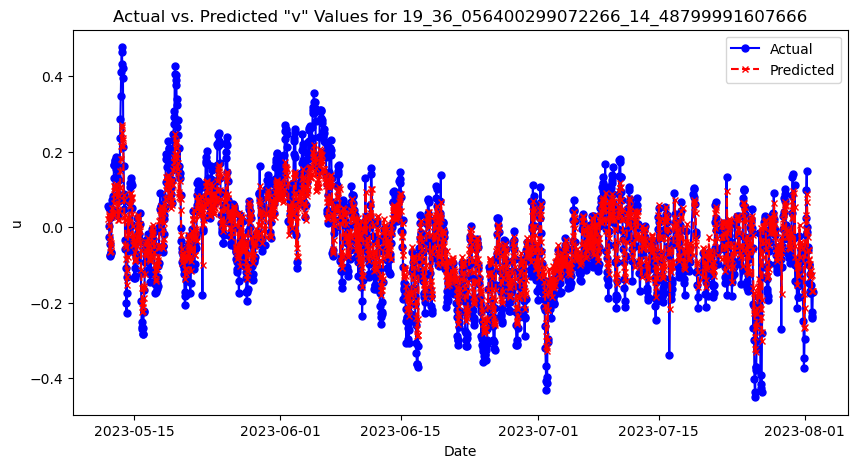

Model tarining & evaluation completed for file: 19_36_056400299072266_14_48799991607666.csv

Processing file: 20_36_056400299072266_14_528599739074707.csv

Epoch 1/100
156/156 [==============================] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.0787INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\20_36_056400299072266_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\20_36_056400299072266_14_528599739074707\assets


156/156 [==============================] - 365s 2s/step - loss: 0.0115 - mean_absolute_error: 0.0787 - val_loss: 0.0071 - val_mean_absolute_error: 0.0595
Epoch 2/100
156/156 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0574INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\20_36_056400299072266_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\20_36_056400299072266_14_528599739074707\assets


156/156 [==============================] - 369s 2s/step - loss: 0.0066 - mean_absolute_error: 0.0574 - val_loss: 0.0057 - val_mean_absolute_error: 0.0502
Epoch 3/100
156/156 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0530INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\20_36_056400299072266_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\20_36_056400299072266_14_528599739074707\assets


156/156 [==============================] - 366s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0530 - val_loss: 0.0053 - val_mean_absolute_error: 0.0466
Epoch 4/100
156/156 [==============================] - 363s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0520 - val_loss: 0.0055 - val_mean_absolute_error: 0.0487
Epoch 5/100
156/156 [==============================] - 362s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0505 - val_loss: 0.0060 - val_mean_absolute_error: 0.0523
Epoch 6/100
156/156 [==============================] - 363s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0509 - val_loss: 0.0059 - val_mean_absolute_error: 0.0510
Epoch 7/100
156/156 [==============================] - 362s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0507 - val_loss: 0.0062 - val_mean_absolute_error: 0.0528
Epoch 8/100
156/156 [==============================] - 362s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0498 - val_loss: 0.0059 - val_mean_absolute_error: 0.0516
Epoch 9/100
156/

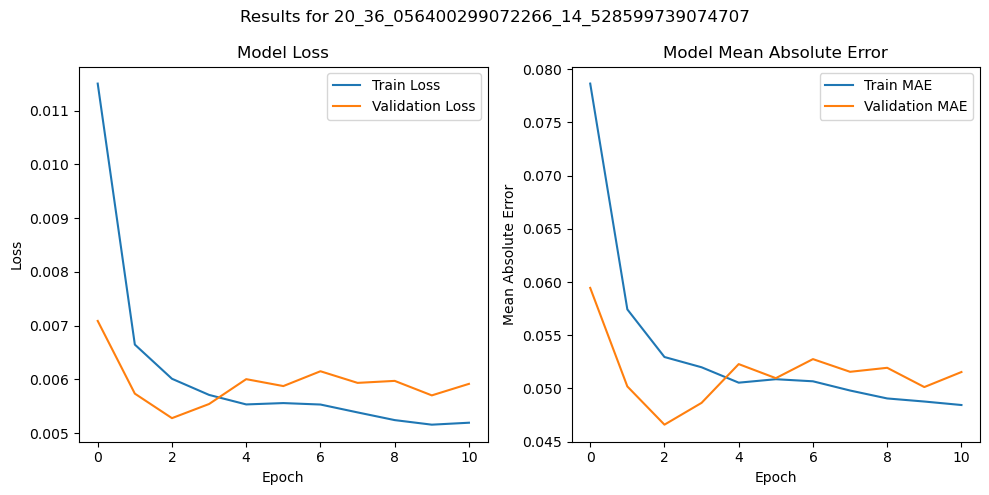

33/33 [==============================] - 15s 428ms/step

Test set Evaluation metrics for file: 20_36_056400299072266_14_528599739074707
Mean Squared Error (MSE): 0.002753441088993203
Mean Absolute Error (MAE): 0.038699175249812943
Root Mean Squared Error (RMSE): 0.0524732416474645



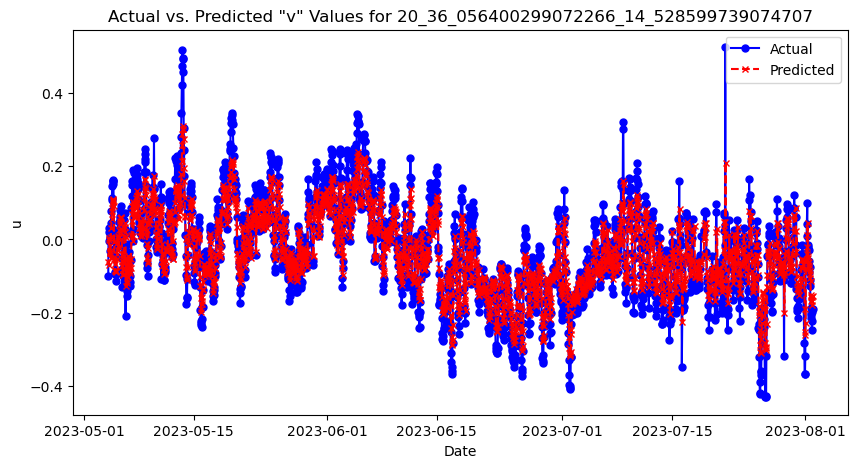

Model tarining & evaluation completed for file: 20_36_056400299072266_14_528599739074707.csv

Processing file: 21_36_056400299072266_14_569199562072754.csv

Epoch 1/100
154/154 [==============================] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0770INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\21_36_056400299072266_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\21_36_056400299072266_14_569199562072754\assets


154/154 [==============================] - 353s 2s/step - loss: 0.0107 - mean_absolute_error: 0.0770 - val_loss: 0.0058 - val_mean_absolute_error: 0.0527
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\21_36_056400299072266_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\21_36_056400299072266_14_569199562072754\assets


154/154 [==============================] - 347s 2s/step - loss: 0.0071 - mean_absolute_error: 0.0602 - val_loss: 0.0049 - val_mean_absolute_error: 0.0462
Epoch 3/100
154/154 [==============================] - 341s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0541 - val_loss: 0.0051 - val_mean_absolute_error: 0.0479
Epoch 4/100
154/154 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0536INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\21_36_056400299072266_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\21_36_056400299072266_14_569199562072754\assets


154/154 [==============================] - 346s 2s/step - loss: 0.0060 - mean_absolute_error: 0.0536 - val_loss: 0.0047 - val_mean_absolute_error: 0.0449
Epoch 5/100
154/154 [==============================] - 374s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0523 - val_loss: 0.0052 - val_mean_absolute_error: 0.0482
Epoch 6/100
154/154 [==============================] - 376s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0518 - val_loss: 0.0049 - val_mean_absolute_error: 0.0460
Epoch 7/100
154/154 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0511INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\21_36_056400299072266_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\21_36_056400299072266_14_569199562072754\assets


154/154 [==============================] - 380s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0511 - val_loss: 0.0045 - val_mean_absolute_error: 0.0428
Epoch 8/100
154/154 [==============================] - 392s 3s/step - loss: 0.0053 - mean_absolute_error: 0.0499 - val_loss: 0.0049 - val_mean_absolute_error: 0.0458
Epoch 9/100
154/154 [==============================] - 393s 3s/step - loss: 0.0053 - mean_absolute_error: 0.0497 - val_loss: 0.0046 - val_mean_absolute_error: 0.0444
Epoch 10/100
154/154 [==============================] - 392s 3s/step - loss: 0.0053 - mean_absolute_error: 0.0500 - val_loss: 0.0048 - val_mean_absolute_error: 0.0449
Epoch 11/100
154/154 [==============================] - 393s 3s/step - loss: 0.0051 - mean_absolute_error: 0.0485 - val_loss: 0.0046 - val_mean_absolute_error: 0.0441
Epoch 12/100
154/154 [==============================] - 393s 3s/step - loss: 0.0051 - mean_absolute_error: 0.0487 - val_loss: 0.0047 - val_mean_absolute_error: 0.0445
Epoch 13/100


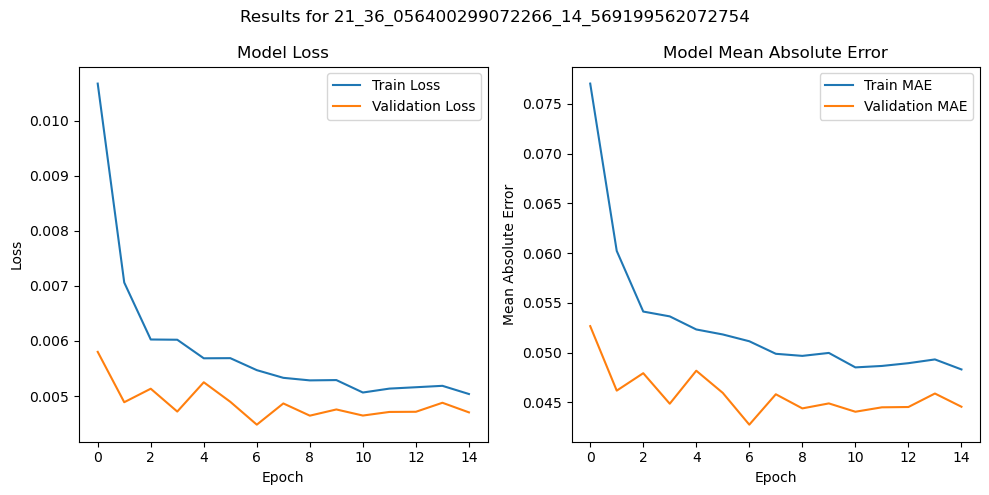

32/32 [==============================] - 16s 485ms/step

Test set Evaluation metrics for file: 21_36_056400299072266_14_569199562072754
Mean Squared Error (MSE): 0.0026640414099680723
Mean Absolute Error (MAE): 0.03748145994745933
Root Mean Squared Error (RMSE): 0.05161435275161428



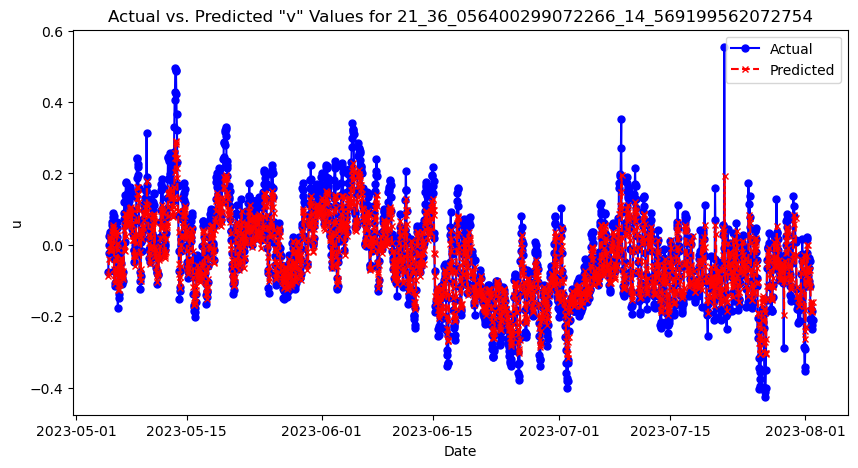

Model tarining & evaluation completed for file: 21_36_056400299072266_14_569199562072754.csv

Processing file: 22_36_07870101928711_14_366399765014648.csv

Epoch 1/100
103/103 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0609INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\22_36_07870101928711_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\22_36_07870101928711_14_366399765014648\assets


103/103 [==============================] - 233s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0609 - val_loss: 0.0049 - val_mean_absolute_error: 0.0567
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0497INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\22_36_07870101928711_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\22_36_07870101928711_14_366399765014648\assets


103/103 [==============================] - 229s 2s/step - loss: 0.0043 - mean_absolute_error: 0.0497 - val_loss: 0.0030 - val_mean_absolute_error: 0.0438
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0462INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\22_36_07870101928711_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\22_36_07870101928711_14_366399765014648\assets


103/103 [==============================] - 230s 2s/step - loss: 0.0038 - mean_absolute_error: 0.0462 - val_loss: 0.0020 - val_mean_absolute_error: 0.0342
Epoch 4/100
103/103 [==============================] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.0416INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\22_36_07870101928711_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\22_36_07870101928711_14_366399765014648\assets


103/103 [==============================] - 240s 2s/step - loss: 0.0033 - mean_absolute_error: 0.0416 - val_loss: 0.0012 - val_mean_absolute_error: 0.0248
Epoch 5/100
103/103 [==============================] - 237s 2s/step - loss: 0.0029 - mean_absolute_error: 0.0383 - val_loss: 0.0013 - val_mean_absolute_error: 0.0268
Epoch 6/100
103/103 [==============================] - 238s 2s/step - loss: 0.0029 - mean_absolute_error: 0.0381 - val_loss: 0.0014 - val_mean_absolute_error: 0.0274
Epoch 7/100
103/103 [==============================] - 237s 2s/step - loss: 0.0029 - mean_absolute_error: 0.0378 - val_loss: 0.0015 - val_mean_absolute_error: 0.0283
Epoch 8/100
103/103 [==============================] - 238s 2s/step - loss: 0.0028 - mean_absolute_error: 0.0371 - val_loss: 0.0015 - val_mean_absolute_error: 0.0286
Epoch 9/100
103/103 [==============================] - 238s 2s/step - loss: 0.0028 - mean_absolute_error: 0.0369 - val_loss: 0.0014 - val_mean_absolute_error: 0.0274
Epoch 10/100
103

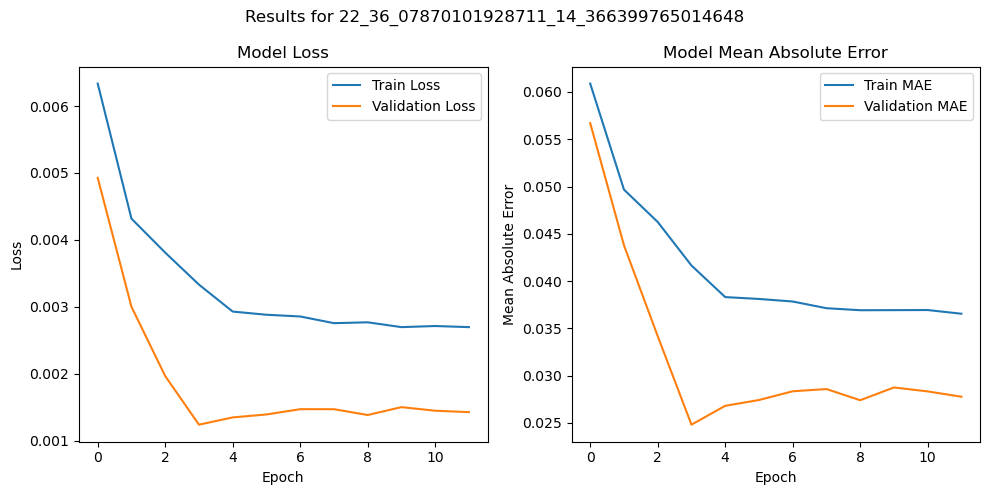

22/22 [==============================] - 10s 409ms/step

Test set Evaluation metrics for file: 22_36_07870101928711_14_366399765014648
Mean Squared Error (MSE): 0.00238583401661032
Mean Absolute Error (MAE): 0.03488959397600267
Root Mean Squared Error (RMSE): 0.04884499991411936



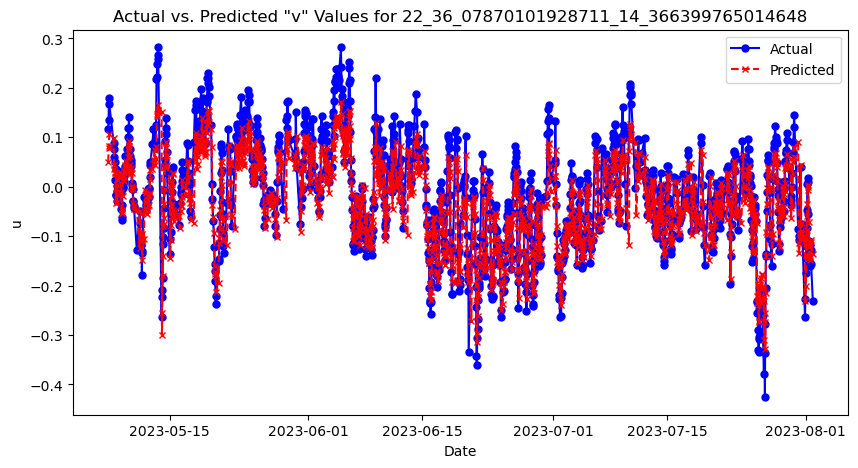

Model tarining & evaluation completed for file: 22_36_07870101928711_14_366399765014648.csv

Processing file: 23_36_07870101928711_14_406900405883789.csv

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0684INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 305s 2s/step - loss: 0.0080 - mean_absolute_error: 0.0684 - val_loss: 0.0074 - val_mean_absolute_error: 0.0717
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.0522INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 312s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0522 - val_loss: 0.0041 - val_mean_absolute_error: 0.0521
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0478INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 310s 2s/step - loss: 0.0043 - mean_absolute_error: 0.0478 - val_loss: 0.0038 - val_mean_absolute_error: 0.0501
Epoch 4/100
125/125 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0481INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 311s 2s/step - loss: 0.0043 - mean_absolute_error: 0.0481 - val_loss: 0.0028 - val_mean_absolute_error: 0.0418
Epoch 5/100
125/125 [==============================] - 305s 2s/step - loss: 0.0041 - mean_absolute_error: 0.0457 - val_loss: 0.0034 - val_mean_absolute_error: 0.0471
Epoch 6/100
125/125 [==============================] - 306s 2s/step - loss: 0.0040 - mean_absolute_error: 0.0457 - val_loss: 0.0032 - val_mean_absolute_error: 0.0450
Epoch 7/100
125/125 [==============================] - 306s 2s/step - loss: 0.0039 - mean_absolute_error: 0.0449 - val_loss: 0.0029 - val_mean_absolute_error: 0.0422
Epoch 8/100
125/125 [==============================] - 307s 2s/step - loss: 0.0040 - mean_absolute_error: 0.0452 - val_loss: 0.0030 - val_mean_absolute_error: 0.0438
Epoch 9/100
125/125 [==============================] - 306s 2s/step - loss: 0.0039 - mean_absolute_error: 0.0449 - val_loss: 0.0030 - val_mean_absolute_error: 0.0434
Epoch 10/100
125

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 310s 2s/step - loss: 0.0040 - mean_absolute_error: 0.0451 - val_loss: 0.0026 - val_mean_absolute_error: 0.0399
Epoch 11/100
125/125 [==============================] - 322s 3s/step - loss: 0.0037 - mean_absolute_error: 0.0438 - val_loss: 0.0030 - val_mean_absolute_error: 0.0431
Epoch 12/100
125/125 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.0439INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 328s 3s/step - loss: 0.0037 - mean_absolute_error: 0.0439 - val_loss: 0.0026 - val_mean_absolute_error: 0.0390
Epoch 13/100
125/125 [==============================] - 323s 3s/step - loss: 0.0038 - mean_absolute_error: 0.0439 - val_loss: 0.0026 - val_mean_absolute_error: 0.0394
Epoch 14/100
125/125 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.0439INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 329s 3s/step - loss: 0.0037 - mean_absolute_error: 0.0439 - val_loss: 0.0024 - val_mean_absolute_error: 0.0376
Epoch 15/100
125/125 [==============================] - 318s 3s/step - loss: 0.0038 - mean_absolute_error: 0.0437 - val_loss: 0.0031 - val_mean_absolute_error: 0.0438
Epoch 16/100
125/125 [==============================] - 318s 3s/step - loss: 0.0038 - mean_absolute_error: 0.0437 - val_loss: 0.0032 - val_mean_absolute_error: 0.0446
Epoch 17/100
125/125 [==============================] - 318s 3s/step - loss: 0.0038 - mean_absolute_error: 0.0443 - val_loss: 0.0027 - val_mean_absolute_error: 0.0399
Epoch 18/100
125/125 [==============================] - 318s 3s/step - loss: 0.0036 - mean_absolute_error: 0.0431 - val_loss: 0.0025 - val_mean_absolute_error: 0.0380
Epoch 19/100
125/125 [==============================] - 319s 3s/step - loss: 0.0036 - mean_absolute_error: 0.0429 - val_loss: 0.0033 - val_mean_absolute_error: 0.0460
Epoch 20/10

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 324s 3s/step - loss: 0.0038 - mean_absolute_error: 0.0443 - val_loss: 0.0024 - val_mean_absolute_error: 0.0377
Epoch 23/100
125/125 [==============================] - 320s 3s/step - loss: 0.0036 - mean_absolute_error: 0.0430 - val_loss: 0.0025 - val_mean_absolute_error: 0.0389
Epoch 24/100
125/125 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.0434INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 325s 3s/step - loss: 0.0037 - mean_absolute_error: 0.0434 - val_loss: 0.0022 - val_mean_absolute_error: 0.0353
Epoch 25/100
125/125 [==============================] - 320s 3s/step - loss: 0.0036 - mean_absolute_error: 0.0431 - val_loss: 0.0023 - val_mean_absolute_error: 0.0360
Epoch 26/100
125/125 [==============================] - 319s 3s/step - loss: 0.0036 - mean_absolute_error: 0.0428 - val_loss: 0.0029 - val_mean_absolute_error: 0.0425
Epoch 27/100
125/125 [==============================] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.0428INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 324s 3s/step - loss: 0.0036 - mean_absolute_error: 0.0428 - val_loss: 0.0022 - val_mean_absolute_error: 0.0353
Epoch 28/100
125/125 [==============================] - 321s 3s/step - loss: 0.0037 - mean_absolute_error: 0.0433 - val_loss: 0.0026 - val_mean_absolute_error: 0.0399
Epoch 29/100
125/125 [==============================] - 323s 3s/step - loss: 0.0036 - mean_absolute_error: 0.0426 - val_loss: 0.0023 - val_mean_absolute_error: 0.0364
Epoch 30/100
125/125 [==============================] - ETA: 0s - loss: 0.0035 - mean_absolute_error: 0.0425INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 326s 3s/step - loss: 0.0035 - mean_absolute_error: 0.0425 - val_loss: 0.0022 - val_mean_absolute_error: 0.0349
Epoch 31/100
125/125 [==============================] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.0426INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\23_36_07870101928711_14_406900405883789\assets


125/125 [==============================] - 325s 3s/step - loss: 0.0036 - mean_absolute_error: 0.0426 - val_loss: 0.0022 - val_mean_absolute_error: 0.0348
Epoch 32/100
125/125 [==============================] - 321s 3s/step - loss: 0.0035 - mean_absolute_error: 0.0418 - val_loss: 0.0023 - val_mean_absolute_error: 0.0362
Epoch 33/100
125/125 [==============================] - 319s 3s/step - loss: 0.0036 - mean_absolute_error: 0.0426 - val_loss: 0.0024 - val_mean_absolute_error: 0.0368
Epoch 34/100
125/125 [==============================] - 321s 3s/step - loss: 0.0035 - mean_absolute_error: 0.0419 - val_loss: 0.0028 - val_mean_absolute_error: 0.0419
Epoch 35/100
125/125 [==============================] - 321s 3s/step - loss: 0.0036 - mean_absolute_error: 0.0425 - val_loss: 0.0027 - val_mean_absolute_error: 0.0403
Epoch 36/100
125/125 [==============================] - 322s 3s/step - loss: 0.0036 - mean_absolute_error: 0.0433 - val_loss: 0.0023 - val_mean_absolute_error: 0.0366
Epoch 37/10

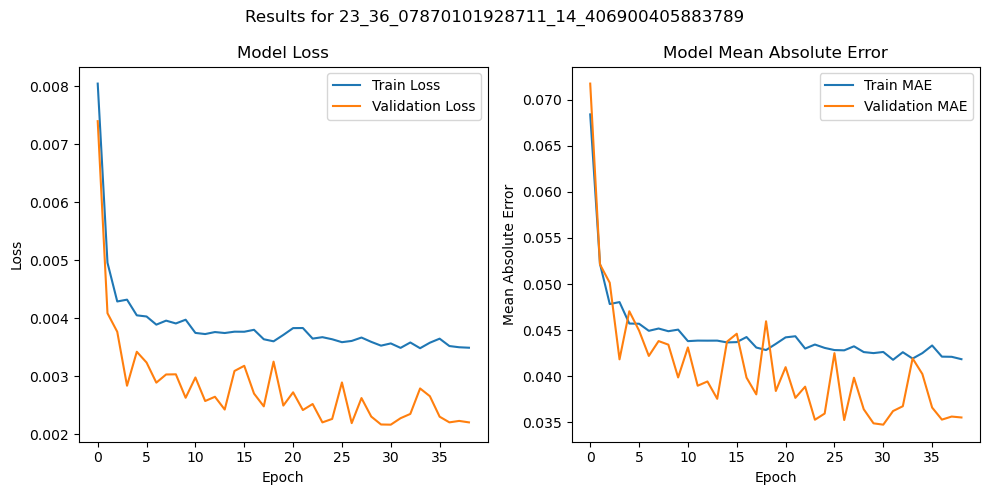

26/26 [==============================] - 13s 476ms/step

Test set Evaluation metrics for file: 23_36_07870101928711_14_406900405883789
Mean Squared Error (MSE): 0.0028059842411454995
Mean Absolute Error (MAE): 0.03913777140397681
Root Mean Squared Error (RMSE): 0.05297154180449631



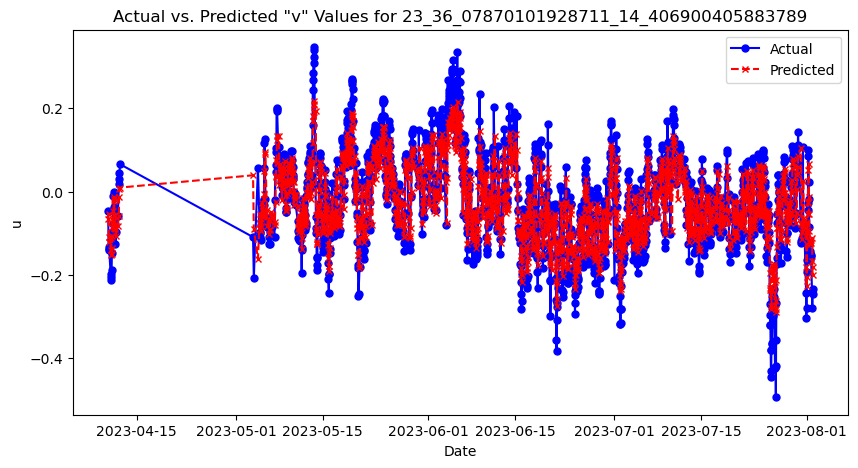

Model tarining & evaluation completed for file: 23_36_07870101928711_14_406900405883789.csv

Processing file: 24_36_07870101928711_14_447500228881836.csv

Epoch 1/100
151/151 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0704INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 389s 3s/step - loss: 0.0093 - mean_absolute_error: 0.0704 - val_loss: 0.0047 - val_mean_absolute_error: 0.0552
Epoch 2/100
151/151 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0537INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 393s 3s/step - loss: 0.0057 - mean_absolute_error: 0.0537 - val_loss: 0.0037 - val_mean_absolute_error: 0.0489
Epoch 3/100
151/151 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0489INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 393s 3s/step - loss: 0.0049 - mean_absolute_error: 0.0489 - val_loss: 0.0033 - val_mean_absolute_error: 0.0459
Epoch 4/100
151/151 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0481INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 393s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0481 - val_loss: 0.0030 - val_mean_absolute_error: 0.0424
Epoch 5/100
151/151 [==============================] - 387s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0475 - val_loss: 0.0037 - val_mean_absolute_error: 0.0492
Epoch 6/100
151/151 [==============================] - 389s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0480 - val_loss: 0.0032 - val_mean_absolute_error: 0.0450
Epoch 7/100
151/151 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0469INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 395s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0469 - val_loss: 0.0030 - val_mean_absolute_error: 0.0422
Epoch 8/100
151/151 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0463INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 392s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0463 - val_loss: 0.0029 - val_mean_absolute_error: 0.0422
Epoch 9/100
151/151 [==============================] - 402s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0465 - val_loss: 0.0030 - val_mean_absolute_error: 0.0432
Epoch 10/100
151/151 [==============================] - 400s 3s/step - loss: 0.0044 - mean_absolute_error: 0.0456 - val_loss: 0.0035 - val_mean_absolute_error: 0.0470
Epoch 11/100
151/151 [==============================] - 399s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0473 - val_loss: 0.0032 - val_mean_absolute_error: 0.0447
Epoch 12/100
151/151 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0464INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 406s 3s/step - loss: 0.0045 - mean_absolute_error: 0.0464 - val_loss: 0.0027 - val_mean_absolute_error: 0.0399
Epoch 13/100
151/151 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.0460INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 407s 3s/step - loss: 0.0044 - mean_absolute_error: 0.0460 - val_loss: 0.0025 - val_mean_absolute_error: 0.0380
Epoch 14/100
151/151 [==============================] - 400s 3s/step - loss: 0.0043 - mean_absolute_error: 0.0453 - val_loss: 0.0028 - val_mean_absolute_error: 0.0409
Epoch 15/100
151/151 [==============================] - 401s 3s/step - loss: 0.0044 - mean_absolute_error: 0.0453 - val_loss: 0.0026 - val_mean_absolute_error: 0.0394
Epoch 16/100
151/151 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0452INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 407s 3s/step - loss: 0.0043 - mean_absolute_error: 0.0452 - val_loss: 0.0024 - val_mean_absolute_error: 0.0372
Epoch 17/100
151/151 [==============================] - 404s 3s/step - loss: 0.0043 - mean_absolute_error: 0.0451 - val_loss: 0.0028 - val_mean_absolute_error: 0.0416
Epoch 18/100
151/151 [==============================] - 420s 3s/step - loss: 0.0043 - mean_absolute_error: 0.0451 - val_loss: 0.0026 - val_mean_absolute_error: 0.0385
Epoch 19/100
151/151 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0448INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\24_36_07870101928711_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\24_36_07870101928711_14_447500228881836\assets


151/151 [==============================] - 408s 3s/step - loss: 0.0043 - mean_absolute_error: 0.0448 - val_loss: 0.0023 - val_mean_absolute_error: 0.0357
Epoch 20/100
151/151 [==============================] - 403s 3s/step - loss: 0.0042 - mean_absolute_error: 0.0445 - val_loss: 0.0024 - val_mean_absolute_error: 0.0368
Epoch 21/100
151/151 [==============================] - 409s 3s/step - loss: 0.0043 - mean_absolute_error: 0.0444 - val_loss: 0.0026 - val_mean_absolute_error: 0.0391
Epoch 22/100
151/151 [==============================] - 407s 3s/step - loss: 0.0043 - mean_absolute_error: 0.0446 - val_loss: 0.0025 - val_mean_absolute_error: 0.0380
Epoch 23/100
151/151 [==============================] - 406s 3s/step - loss: 0.0043 - mean_absolute_error: 0.0449 - val_loss: 0.0026 - val_mean_absolute_error: 0.0390
Epoch 24/100
151/151 [==============================] - 410s 3s/step - loss: 0.0043 - mean_absolute_error: 0.0445 - val_loss: 0.0025 - val_mean_absolute_error: 0.0382
Epoch 25/10

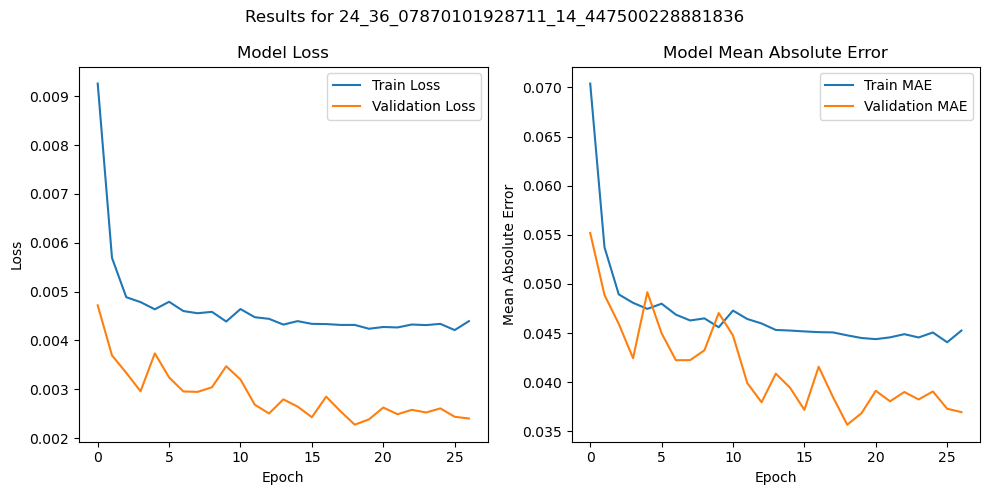

32/32 [==============================] - 16s 493ms/step

Test set Evaluation metrics for file: 24_36_07870101928711_14_447500228881836
Mean Squared Error (MSE): 0.0022641589584943087
Mean Absolute Error (MAE): 0.034940737464401565
Root Mean Squared Error (RMSE): 0.047583179365131845



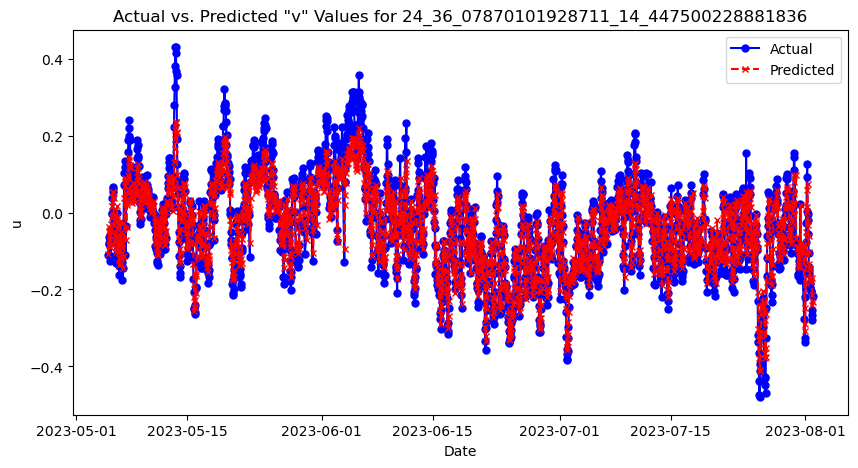

Model tarining & evaluation completed for file: 24_36_07870101928711_14_447500228881836.csv

Processing file: 25_36_07870101928711_14_48799991607666.csv

Epoch 1/100
154/154 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0718INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\25_36_07870101928711_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\25_36_07870101928711_14_48799991607666\assets


154/154 [==============================] - 417s 3s/step - loss: 0.0097 - mean_absolute_error: 0.0718 - val_loss: 0.0052 - val_mean_absolute_error: 0.0566
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0540INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\25_36_07870101928711_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\25_36_07870101928711_14_48799991607666\assets


154/154 [==============================] - 420s 3s/step - loss: 0.0057 - mean_absolute_error: 0.0540 - val_loss: 0.0043 - val_mean_absolute_error: 0.0506
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.0501INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\25_36_07870101928711_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\25_36_07870101928711_14_48799991607666\assets


154/154 [==============================] - 407s 3s/step - loss: 0.0050 - mean_absolute_error: 0.0501 - val_loss: 0.0035 - val_mean_absolute_error: 0.0448
Epoch 4/100
154/154 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0489INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\25_36_07870101928711_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\25_36_07870101928711_14_48799991607666\assets


154/154 [==============================] - 405s 3s/step - loss: 0.0049 - mean_absolute_error: 0.0489 - val_loss: 0.0032 - val_mean_absolute_error: 0.0417
Epoch 5/100
154/154 [==============================] - 399s 3s/step - loss: 0.0047 - mean_absolute_error: 0.0484 - val_loss: 0.0035 - val_mean_absolute_error: 0.0441
Epoch 6/100
154/154 [==============================] - 400s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0475 - val_loss: 0.0038 - val_mean_absolute_error: 0.0466
Epoch 7/100
154/154 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0477INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\25_36_07870101928711_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\25_36_07870101928711_14_48799991607666\assets


154/154 [==============================] - 404s 3s/step - loss: 0.0047 - mean_absolute_error: 0.0477 - val_loss: 0.0031 - val_mean_absolute_error: 0.0403
Epoch 8/100
154/154 [==============================] - 401s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0472 - val_loss: 0.0033 - val_mean_absolute_error: 0.0423
Epoch 9/100
154/154 [==============================] - 406s 3s/step - loss: 0.0045 - mean_absolute_error: 0.0464 - val_loss: 0.0034 - val_mean_absolute_error: 0.0434
Epoch 10/100
154/154 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0465INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\25_36_07870101928711_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\25_36_07870101928711_14_48799991607666\assets


154/154 [==============================] - 406s 3s/step - loss: 0.0045 - mean_absolute_error: 0.0465 - val_loss: 0.0029 - val_mean_absolute_error: 0.0390
Epoch 11/100
154/154 [==============================] - 401s 3s/step - loss: 0.0044 - mean_absolute_error: 0.0455 - val_loss: 0.0032 - val_mean_absolute_error: 0.0416
Epoch 12/100
154/154 [==============================] - 400s 3s/step - loss: 0.0044 - mean_absolute_error: 0.0456 - val_loss: 0.0032 - val_mean_absolute_error: 0.0418
Epoch 13/100
154/154 [==============================] - 400s 3s/step - loss: 0.0044 - mean_absolute_error: 0.0455 - val_loss: 0.0032 - val_mean_absolute_error: 0.0422
Epoch 14/100
154/154 [==============================] - 399s 3s/step - loss: 0.0044 - mean_absolute_error: 0.0461 - val_loss: 0.0035 - val_mean_absolute_error: 0.0445
Epoch 15/100
154/154 [==============================] - 399s 3s/step - loss: 0.0044 - mean_absolute_error: 0.0454 - val_loss: 0.0032 - val_mean_absolute_error: 0.0425
Epoch 16/10

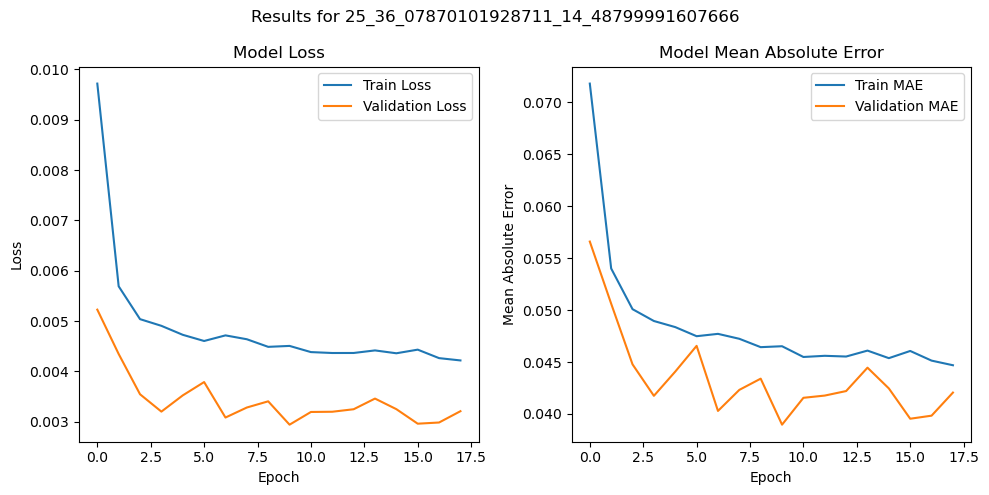

33/33 [==============================] - 16s 472ms/step

Test set Evaluation metrics for file: 25_36_07870101928711_14_48799991607666
Mean Squared Error (MSE): 0.0026228608100624363
Mean Absolute Error (MAE): 0.038638586219510385
Root Mean Squared Error (RMSE): 0.05121387321871327



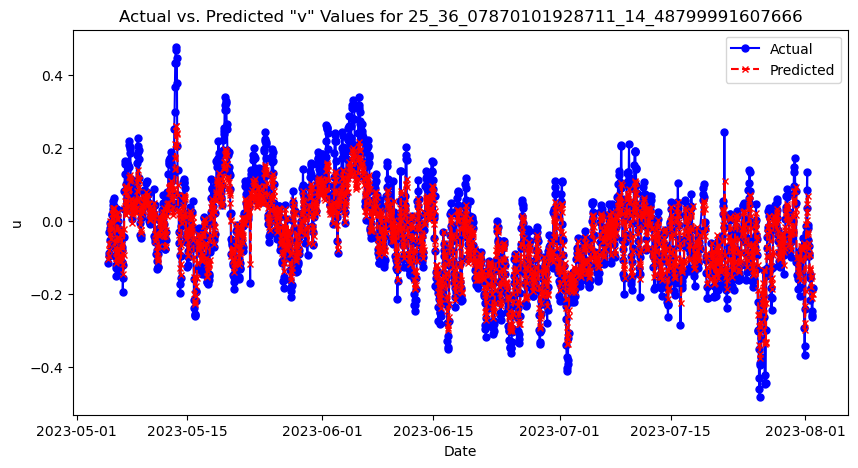

Model tarining & evaluation completed for file: 25_36_07870101928711_14_48799991607666.csv

Processing file: 26_36_07870101928711_14_528599739074707.csv

Epoch 1/100
174/174 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0743INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


174/174 [==============================] - 450s 3s/step - loss: 0.0102 - mean_absolute_error: 0.0743 - val_loss: 0.0059 - val_mean_absolute_error: 0.0540
Epoch 2/100
174/174 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0573INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


174/174 [==============================] - 443s 3s/step - loss: 0.0063 - mean_absolute_error: 0.0573 - val_loss: 0.0049 - val_mean_absolute_error: 0.0472
Epoch 3/100
174/174 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0525INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


174/174 [==============================] - 456s 3s/step - loss: 0.0055 - mean_absolute_error: 0.0525 - val_loss: 0.0044 - val_mean_absolute_error: 0.0431
Epoch 4/100
174/174 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0509INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


174/174 [==============================] - 457s 3s/step - loss: 0.0053 - mean_absolute_error: 0.0509 - val_loss: 0.0040 - val_mean_absolute_error: 0.0411
Epoch 5/100
174/174 [==============================] - 446s 3s/step - loss: 0.0053 - mean_absolute_error: 0.0508 - val_loss: 0.0043 - val_mean_absolute_error: 0.0426
Epoch 6/100
174/174 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0503INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


174/174 [==============================] - 450s 3s/step - loss: 0.0053 - mean_absolute_error: 0.0503 - val_loss: 0.0040 - val_mean_absolute_error: 0.0408
Epoch 7/100
174/174 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0495INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


174/174 [==============================] - 452s 3s/step - loss: 0.0051 - mean_absolute_error: 0.0495 - val_loss: 0.0039 - val_mean_absolute_error: 0.0408
Epoch 8/100
174/174 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0494INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


174/174 [==============================] - 455s 3s/step - loss: 0.0051 - mean_absolute_error: 0.0494 - val_loss: 0.0039 - val_mean_absolute_error: 0.0399
Epoch 9/100
174/174 [==============================] - 448s 3s/step - loss: 0.0050 - mean_absolute_error: 0.0489 - val_loss: 0.0039 - val_mean_absolute_error: 0.0403
Epoch 10/100
174/174 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.0487INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


174/174 [==============================] - 452s 3s/step - loss: 0.0050 - mean_absolute_error: 0.0487 - val_loss: 0.0038 - val_mean_absolute_error: 0.0404
Epoch 11/100
174/174 [==============================] - 448s 3s/step - loss: 0.0050 - mean_absolute_error: 0.0485 - val_loss: 0.0039 - val_mean_absolute_error: 0.0405
Epoch 12/100
174/174 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0477INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


174/174 [==============================] - 452s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0477 - val_loss: 0.0038 - val_mean_absolute_error: 0.0399
Epoch 13/100
174/174 [==============================] - 458s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0478 - val_loss: 0.0039 - val_mean_absolute_error: 0.0403
Epoch 14/100
174/174 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0484INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


174/174 [==============================] - 464s 3s/step - loss: 0.0049 - mean_absolute_error: 0.0484 - val_loss: 0.0038 - val_mean_absolute_error: 0.0396
Epoch 15/100
174/174 [==============================] - 453s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0472 - val_loss: 0.0038 - val_mean_absolute_error: 0.0396
Epoch 16/100
174/174 [==============================] - 452s 3s/step - loss: 0.0047 - mean_absolute_error: 0.0472 - val_loss: 0.0038 - val_mean_absolute_error: 0.0397
Epoch 17/100
174/174 [==============================] - 452s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0473 - val_loss: 0.0039 - val_mean_absolute_error: 0.0405
Epoch 18/100
174/174 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0478INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


174/174 [==============================] - 455s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0478 - val_loss: 0.0037 - val_mean_absolute_error: 0.0392
Epoch 19/100
174/174 [==============================] - 445s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0476 - val_loss: 0.0039 - val_mean_absolute_error: 0.0404
Epoch 20/100
174/174 [==============================] - 444s 3s/step - loss: 0.0049 - mean_absolute_error: 0.0477 - val_loss: 0.0038 - val_mean_absolute_error: 0.0395
Epoch 21/100
174/174 [==============================] - 444s 3s/step - loss: 0.0047 - mean_absolute_error: 0.0468 - val_loss: 0.0038 - val_mean_absolute_error: 0.0405
Epoch 22/100
174/174 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0471INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\26_36_07870101928711_14_528599739074707\assets


174/174 [==============================] - 450s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0471 - val_loss: 0.0037 - val_mean_absolute_error: 0.0391
Epoch 23/100
174/174 [==============================] - 446s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0463 - val_loss: 0.0037 - val_mean_absolute_error: 0.0390
Epoch 24/100
174/174 [==============================] - 450s 3s/step - loss: 0.0047 - mean_absolute_error: 0.0466 - val_loss: 0.0037 - val_mean_absolute_error: 0.0389
Epoch 25/100
174/174 [==============================] - 447s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0464 - val_loss: 0.0037 - val_mean_absolute_error: 0.0389
Epoch 26/100
174/174 [==============================] - 447s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0462 - val_loss: 0.0037 - val_mean_absolute_error: 0.0395
Epoch 27/100
174/174 [==============================] - 447s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0473 - val_loss: 0.0038 - val_mean_absolute_error: 0.0395
Epoch 28/10

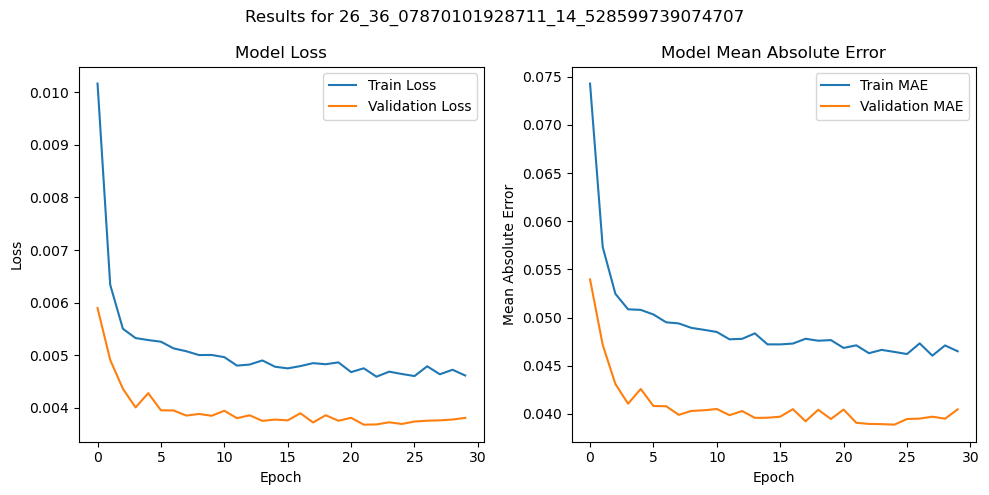

37/37 [==============================] - 18s 472ms/step

Test set Evaluation metrics for file: 26_36_07870101928711_14_528599739074707
Mean Squared Error (MSE): 0.0026987549611896615
Mean Absolute Error (MAE): 0.03476033672583958
Root Mean Squared Error (RMSE): 0.051949542454093486



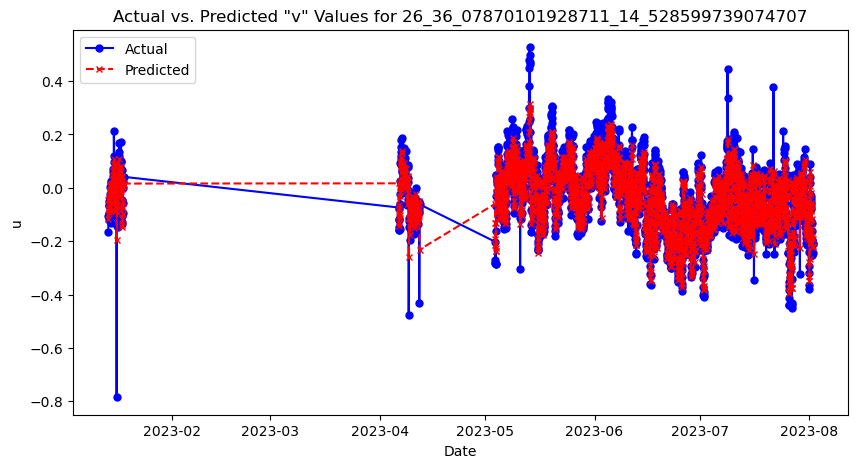

Model tarining & evaluation completed for file: 26_36_07870101928711_14_528599739074707.csv

Processing file: 27_36_07870101928711_14_569199562072754.csv

Epoch 1/100
171/171 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0775INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\27_36_07870101928711_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\27_36_07870101928711_14_569199562072754\assets


171/171 [==============================] - 432s 3s/step - loss: 0.0106 - mean_absolute_error: 0.0775 - val_loss: 0.0043 - val_mean_absolute_error: 0.0468
Epoch 2/100
171/171 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0581INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\27_36_07870101928711_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\27_36_07870101928711_14_569199562072754\assets


171/171 [==============================] - 425s 2s/step - loss: 0.0064 - mean_absolute_error: 0.0581 - val_loss: 0.0037 - val_mean_absolute_error: 0.0417
Epoch 3/100
171/171 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0532INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\27_36_07870101928711_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\27_36_07870101928711_14_569199562072754\assets


171/171 [==============================] - 456s 3s/step - loss: 0.0055 - mean_absolute_error: 0.0532 - val_loss: 0.0036 - val_mean_absolute_error: 0.0403
Epoch 4/100
171/171 [==============================] - 429s 3s/step - loss: 0.0054 - mean_absolute_error: 0.0521 - val_loss: 0.0036 - val_mean_absolute_error: 0.0404
Epoch 5/100
171/171 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0511INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\27_36_07870101928711_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\27_36_07870101928711_14_569199562072754\assets


171/171 [==============================] - 433s 3s/step - loss: 0.0052 - mean_absolute_error: 0.0511 - val_loss: 0.0035 - val_mean_absolute_error: 0.0396
Epoch 6/100
171/171 [==============================] - 430s 3s/step - loss: 0.0053 - mean_absolute_error: 0.0513 - val_loss: 0.0037 - val_mean_absolute_error: 0.0410
Epoch 7/100
171/171 [==============================] - 430s 3s/step - loss: 0.0051 - mean_absolute_error: 0.0500 - val_loss: 0.0039 - val_mean_absolute_error: 0.0437
Epoch 8/100
171/171 [==============================] - 428s 3s/step - loss: 0.0050 - mean_absolute_error: 0.0495 - val_loss: 0.0039 - val_mean_absolute_error: 0.0427
Epoch 9/100
171/171 [==============================] - 429s 3s/step - loss: 0.0051 - mean_absolute_error: 0.0499 - val_loss: 0.0044 - val_mean_absolute_error: 0.0473
Epoch 10/100
171/171 [==============================] - 432s 3s/step - loss: 0.0051 - mean_absolute_error: 0.0498 - val_loss: 0.0037 - val_mean_absolute_error: 0.0411
Epoch 11/100
17

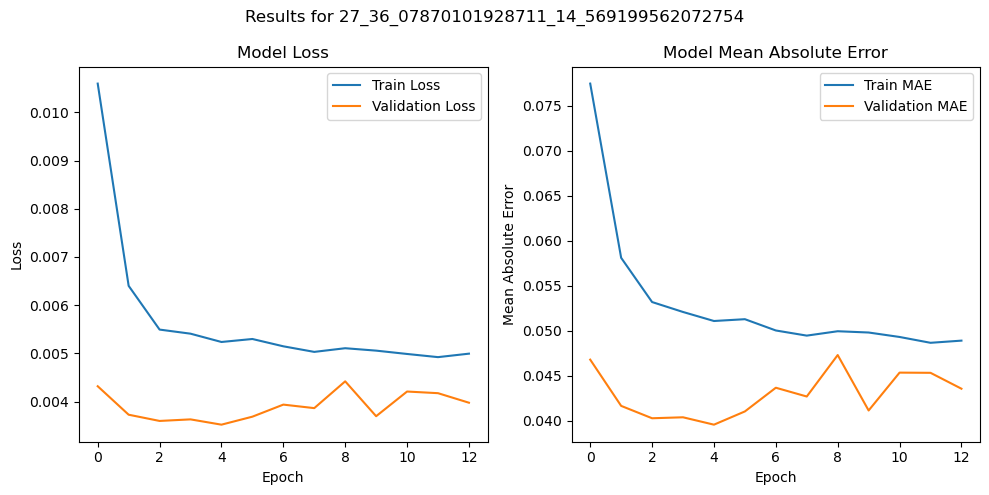

36/36 [==============================] - 17s 468ms/step

Test set Evaluation metrics for file: 27_36_07870101928711_14_569199562072754
Mean Squared Error (MSE): 0.0026184887091844963
Mean Absolute Error (MAE): 0.03687139789883889
Root Mean Squared Error (RMSE): 0.051171170684131274



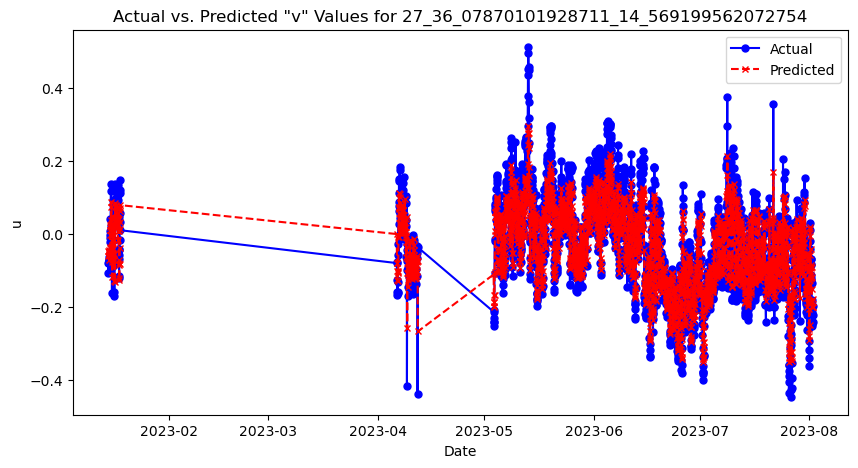

Model tarining & evaluation completed for file: 27_36_07870101928711_14_569199562072754.csv

Processing file: 28_35_945098876953125_14_528599739074707.csv

Epoch 1/100
79/79 [==============================] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0771INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\28_35_945098876953125_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\28_35_945098876953125_14_528599739074707\assets


79/79 [==============================] - 200s 2s/step - loss: 0.0111 - mean_absolute_error: 0.0771 - val_loss: 0.0139 - val_mean_absolute_error: 0.0796
Epoch 2/100
79/79 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0612INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\28_35_945098876953125_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\28_35_945098876953125_14_528599739074707\assets


79/79 [==============================] - 196s 2s/step - loss: 0.0079 - mean_absolute_error: 0.0612 - val_loss: 0.0103 - val_mean_absolute_error: 0.0612
Epoch 3/100
79/79 [==============================] - 189s 2s/step - loss: 0.0071 - mean_absolute_error: 0.0553 - val_loss: 0.0107 - val_mean_absolute_error: 0.0636
Epoch 4/100
79/79 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0541INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\28_35_945098876953125_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\28_35_945098876953125_14_528599739074707\assets


79/79 [==============================] - 195s 2s/step - loss: 0.0068 - mean_absolute_error: 0.0541 - val_loss: 0.0101 - val_mean_absolute_error: 0.0596
Epoch 5/100
79/79 [==============================] - 196s 2s/step - loss: 0.0065 - mean_absolute_error: 0.0521 - val_loss: 0.0105 - val_mean_absolute_error: 0.0624
Epoch 6/100
79/79 [==============================] - 196s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0511 - val_loss: 0.0102 - val_mean_absolute_error: 0.0600
Epoch 7/100
79/79 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0503INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\28_35_945098876953125_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\28_35_945098876953125_14_528599739074707\assets


79/79 [==============================] - 200s 3s/step - loss: 0.0063 - mean_absolute_error: 0.0503 - val_loss: 0.0097 - val_mean_absolute_error: 0.0564
Epoch 8/100
79/79 [==============================] - 207s 3s/step - loss: 0.0065 - mean_absolute_error: 0.0511 - val_loss: 0.0112 - val_mean_absolute_error: 0.0654
Epoch 9/100
79/79 [==============================] - 207s 3s/step - loss: 0.0061 - mean_absolute_error: 0.0492 - val_loss: 0.0110 - val_mean_absolute_error: 0.0642
Epoch 10/100
79/79 [==============================] - 210s 3s/step - loss: 0.0062 - mean_absolute_error: 0.0493 - val_loss: 0.0098 - val_mean_absolute_error: 0.0569
Epoch 11/100
79/79 [==============================] - 207s 3s/step - loss: 0.0061 - mean_absolute_error: 0.0493 - val_loss: 0.0107 - val_mean_absolute_error: 0.0628
Epoch 12/100
79/79 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0478INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\28_35_945098876953

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\28_35_945098876953125_14_528599739074707\assets


79/79 [==============================] - 214s 3s/step - loss: 0.0058 - mean_absolute_error: 0.0478 - val_loss: 0.0094 - val_mean_absolute_error: 0.0540
Epoch 13/100
79/79 [==============================] - 188s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0474 - val_loss: 0.0100 - val_mean_absolute_error: 0.0578
Epoch 14/100
79/79 [==============================] - 189s 2s/step - loss: 0.0059 - mean_absolute_error: 0.0476 - val_loss: 0.0096 - val_mean_absolute_error: 0.0549
Epoch 15/100
79/79 [==============================] - 189s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0476 - val_loss: 0.0101 - val_mean_absolute_error: 0.0588
Epoch 16/100
79/79 [==============================] - 188s 2s/step - loss: 0.0058 - mean_absolute_error: 0.0481 - val_loss: 0.0097 - val_mean_absolute_error: 0.0562
Epoch 17/100
79/79 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0479INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\28_35_9450988769

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\28_35_945098876953125_14_528599739074707\assets


79/79 [==============================] - 193s 2s/step - loss: 0.0057 - mean_absolute_error: 0.0479 - val_loss: 0.0093 - val_mean_absolute_error: 0.0532
Epoch 18/100
79/79 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0463INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\28_35_945098876953125_14_528599739074707\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\28_35_945098876953125_14_528599739074707\assets


79/79 [==============================] - 193s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0463 - val_loss: 0.0092 - val_mean_absolute_error: 0.0546
Epoch 19/100
79/79 [==============================] - 189s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0460 - val_loss: 0.0093 - val_mean_absolute_error: 0.0521
Epoch 20/100
79/79 [==============================] - 189s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0474 - val_loss: 0.0103 - val_mean_absolute_error: 0.0590
Epoch 21/100
79/79 [==============================] - 189s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0467 - val_loss: 0.0106 - val_mean_absolute_error: 0.0622
Epoch 22/100
79/79 [==============================] - 189s 2s/step - loss: 0.0056 - mean_absolute_error: 0.0475 - val_loss: 0.0103 - val_mean_absolute_error: 0.0594
Epoch 23/100
79/79 [==============================] - 189s 2s/step - loss: 0.0054 - mean_absolute_error: 0.0455 - val_loss: 0.0104 - val_mean_absolute_error: 0.0611
Epoch 24/100
79/79 [===

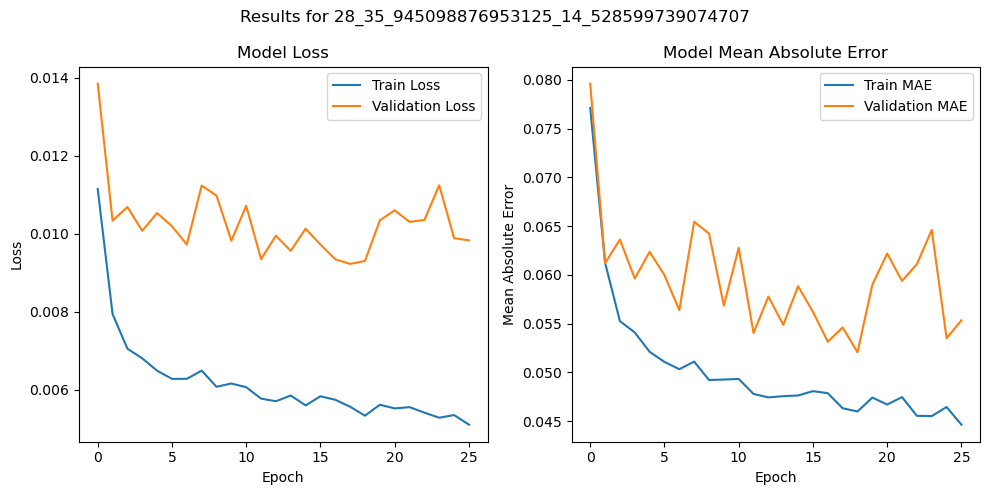

16/16 [==============================] - 8s 452ms/step

Test set Evaluation metrics for file: 28_35_945098876953125_14_528599739074707
Mean Squared Error (MSE): 0.0026156186785394565
Mean Absolute Error (MAE): 0.037884446824286856
Root Mean Squared Error (RMSE): 0.051143119562062855



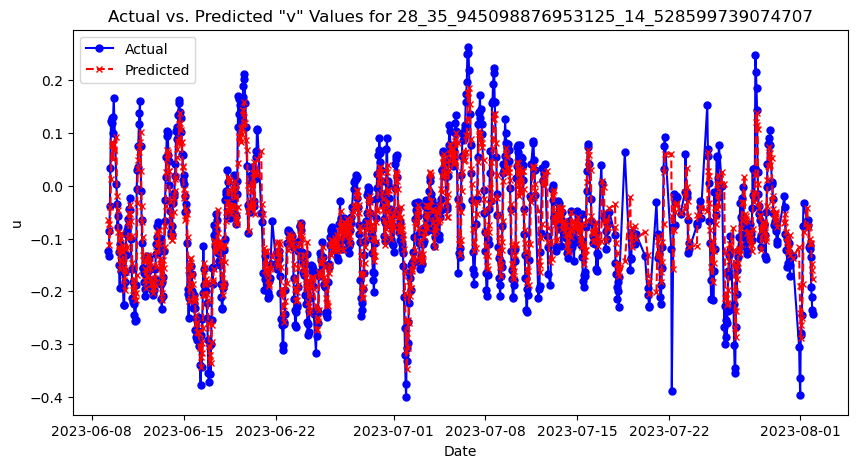

Model tarining & evaluation completed for file: 28_35_945098876953125_14_528599739074707.csv

Processing file: 29_36_03409957885742_14_406900405883789.csv

Epoch 1/100
98/98 [==============================] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0854INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\29_36_03409957885742_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\29_36_03409957885742_14_406900405883789\assets


98/98 [==============================] - 237s 2s/step - loss: 0.0124 - mean_absolute_error: 0.0854 - val_loss: 0.0066 - val_mean_absolute_error: 0.0648
Epoch 2/100
98/98 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0687INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\29_36_03409957885742_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\29_36_03409957885742_14_406900405883789\assets


98/98 [==============================] - 231s 2s/step - loss: 0.0085 - mean_absolute_error: 0.0687 - val_loss: 0.0059 - val_mean_absolute_error: 0.0613
Epoch 3/100
98/98 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0640INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\29_36_03409957885742_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\29_36_03409957885742_14_406900405883789\assets


98/98 [==============================] - 242s 2s/step - loss: 0.0076 - mean_absolute_error: 0.0640 - val_loss: 0.0045 - val_mean_absolute_error: 0.0518
Epoch 4/100
98/98 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0631INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\29_36_03409957885742_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\29_36_03409957885742_14_406900405883789\assets


98/98 [==============================] - 251s 3s/step - loss: 0.0074 - mean_absolute_error: 0.0631 - val_loss: 0.0041 - val_mean_absolute_error: 0.0487
Epoch 5/100
98/98 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0612INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\29_36_03409957885742_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\29_36_03409957885742_14_406900405883789\assets


98/98 [==============================] - 260s 3s/step - loss: 0.0071 - mean_absolute_error: 0.0612 - val_loss: 0.0040 - val_mean_absolute_error: 0.0477
Epoch 6/100
98/98 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0602INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\29_36_03409957885742_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\29_36_03409957885742_14_406900405883789\assets


98/98 [==============================] - 253s 3s/step - loss: 0.0068 - mean_absolute_error: 0.0602 - val_loss: 0.0038 - val_mean_absolute_error: 0.0464
Epoch 7/100
98/98 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0608INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\29_36_03409957885742_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\29_36_03409957885742_14_406900405883789\assets


98/98 [==============================] - 252s 3s/step - loss: 0.0071 - mean_absolute_error: 0.0608 - val_loss: 0.0037 - val_mean_absolute_error: 0.0449
Epoch 8/100
98/98 [==============================] - 248s 3s/step - loss: 0.0068 - mean_absolute_error: 0.0597 - val_loss: 0.0038 - val_mean_absolute_error: 0.0459
Epoch 9/100
98/98 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0603INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\29_36_03409957885742_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\29_36_03409957885742_14_406900405883789\assets


98/98 [==============================] - 252s 3s/step - loss: 0.0069 - mean_absolute_error: 0.0603 - val_loss: 0.0035 - val_mean_absolute_error: 0.0430
Epoch 10/100
98/98 [==============================] - 245s 3s/step - loss: 0.0070 - mean_absolute_error: 0.0605 - val_loss: 0.0036 - val_mean_absolute_error: 0.0447
Epoch 11/100
98/98 [==============================] - 248s 3s/step - loss: 0.0069 - mean_absolute_error: 0.0604 - val_loss: 0.0035 - val_mean_absolute_error: 0.0437
Epoch 12/100
98/98 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0596INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\29_36_03409957885742_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\29_36_03409957885742_14_406900405883789\assets


98/98 [==============================] - 255s 3s/step - loss: 0.0068 - mean_absolute_error: 0.0596 - val_loss: 0.0034 - val_mean_absolute_error: 0.0430
Epoch 13/100
98/98 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0597INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\29_36_03409957885742_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\29_36_03409957885742_14_406900405883789\assets


98/98 [==============================] - 252s 3s/step - loss: 0.0068 - mean_absolute_error: 0.0597 - val_loss: 0.0034 - val_mean_absolute_error: 0.0421
Epoch 14/100
98/98 [==============================] - 251s 3s/step - loss: 0.0069 - mean_absolute_error: 0.0602 - val_loss: 0.0036 - val_mean_absolute_error: 0.0447
Epoch 15/100
98/98 [==============================] - 253s 3s/step - loss: 0.0067 - mean_absolute_error: 0.0595 - val_loss: 0.0037 - val_mean_absolute_error: 0.0460
Epoch 16/100
98/98 [==============================] - 253s 3s/step - loss: 0.0069 - mean_absolute_error: 0.0605 - val_loss: 0.0041 - val_mean_absolute_error: 0.0491
Epoch 17/100
98/98 [==============================] - 253s 3s/step - loss: 0.0069 - mean_absolute_error: 0.0604 - val_loss: 0.0041 - val_mean_absolute_error: 0.0494
Epoch 18/100
98/98 [==============================] - 252s 3s/step - loss: 0.0068 - mean_absolute_error: 0.0598 - val_loss: 0.0045 - val_mean_absolute_error: 0.0526
Epoch 19/100
98/98 [===

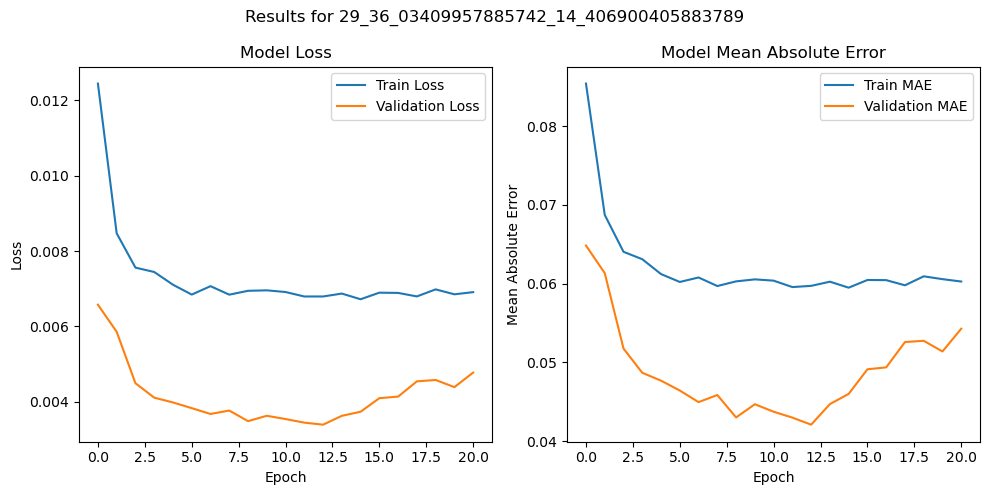

20/20 [==============================] - 10s 492ms/step

Test set Evaluation metrics for file: 29_36_03409957885742_14_406900405883789
Mean Squared Error (MSE): 0.004830393931791328
Mean Absolute Error (MAE): 0.05156490176977634
Root Mean Squared Error (RMSE): 0.06950103547279946



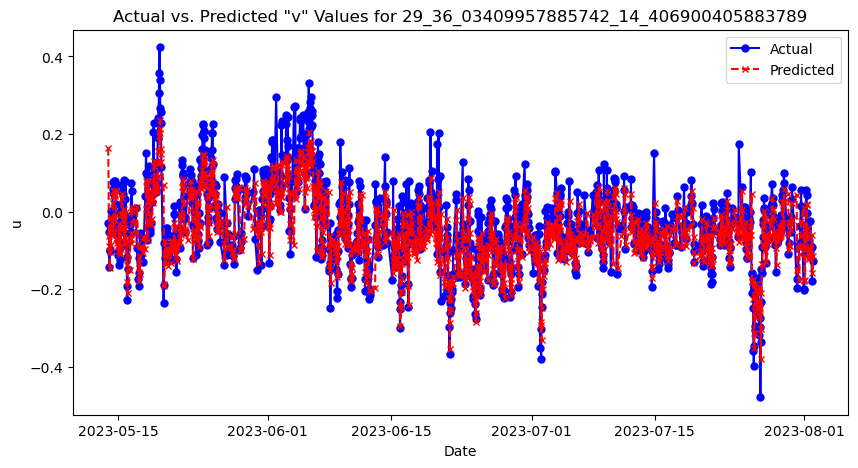

Model tarining & evaluation completed for file: 29_36_03409957885742_14_406900405883789.csv

Processing file: 30_36_056400299072266_14_406900405883789.csv

Epoch 1/100
102/102 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0786INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\30_36_056400299072266_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\30_36_056400299072266_14_406900405883789\assets


102/102 [==============================] - 255s 2s/step - loss: 0.0104 - mean_absolute_error: 0.0786 - val_loss: 0.0051 - val_mean_absolute_error: 0.0579
Epoch 2/100
102/102 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0591INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\30_36_056400299072266_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\30_36_056400299072266_14_406900405883789\assets


102/102 [==============================] - 250s 2s/step - loss: 0.0063 - mean_absolute_error: 0.0591 - val_loss: 0.0047 - val_mean_absolute_error: 0.0566
Epoch 3/100
102/102 [==============================] - 246s 2s/step - loss: 0.0055 - mean_absolute_error: 0.0544 - val_loss: 0.0047 - val_mean_absolute_error: 0.0576
Epoch 4/100
102/102 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0522INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\30_36_056400299072266_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\30_36_056400299072266_14_406900405883789\assets


102/102 [==============================] - 252s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0522 - val_loss: 0.0034 - val_mean_absolute_error: 0.0474
Epoch 5/100
102/102 [==============================] - 250s 2s/step - loss: 0.0050 - mean_absolute_error: 0.0512 - val_loss: 0.0035 - val_mean_absolute_error: 0.0483
Epoch 6/100
102/102 [==============================] - 250s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0510 - val_loss: 0.0038 - val_mean_absolute_error: 0.0499
Epoch 7/100
102/102 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0510INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\30_36_056400299072266_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\30_36_056400299072266_14_406900405883789\assets


102/102 [==============================] - 256s 3s/step - loss: 0.0049 - mean_absolute_error: 0.0510 - val_loss: 0.0032 - val_mean_absolute_error: 0.0455
Epoch 8/100
102/102 [==============================] - 261s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0508 - val_loss: 0.0034 - val_mean_absolute_error: 0.0474
Epoch 9/100
102/102 [==============================] - 262s 3s/step - loss: 0.0050 - mean_absolute_error: 0.0511 - val_loss: 0.0035 - val_mean_absolute_error: 0.0471
Epoch 10/100
102/102 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0510INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\30_36_056400299072266_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\30_36_056400299072266_14_406900405883789\assets


102/102 [==============================] - 267s 3s/step - loss: 0.0049 - mean_absolute_error: 0.0510 - val_loss: 0.0030 - val_mean_absolute_error: 0.0430
Epoch 11/100
102/102 [==============================] - 264s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0501 - val_loss: 0.0041 - val_mean_absolute_error: 0.0519
Epoch 12/100
102/102 [==============================] - 263s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0505 - val_loss: 0.0032 - val_mean_absolute_error: 0.0454
Epoch 13/100
102/102 [==============================] - 266s 3s/step - loss: 0.0048 - mean_absolute_error: 0.0504 - val_loss: 0.0035 - val_mean_absolute_error: 0.0470
Epoch 14/100
102/102 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.0511INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\30_36_056400299072266_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\30_36_056400299072266_14_406900405883789\assets


102/102 [==============================] - 269s 3s/step - loss: 0.0049 - mean_absolute_error: 0.0511 - val_loss: 0.0027 - val_mean_absolute_error: 0.0408
Epoch 15/100
102/102 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0495INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\30_36_056400299072266_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\30_36_056400299072266_14_406900405883789\assets


102/102 [==============================] - 267s 3s/step - loss: 0.0047 - mean_absolute_error: 0.0495 - val_loss: 0.0027 - val_mean_absolute_error: 0.0408
Epoch 16/100
102/102 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0494INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\30_36_056400299072266_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\30_36_056400299072266_14_406900405883789\assets


102/102 [==============================] - 267s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0494 - val_loss: 0.0026 - val_mean_absolute_error: 0.0394
Epoch 17/100
102/102 [==============================] - 265s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0488 - val_loss: 0.0028 - val_mean_absolute_error: 0.0418
Epoch 18/100
102/102 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0493INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\30_36_056400299072266_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\30_36_056400299072266_14_406900405883789\assets


102/102 [==============================] - 267s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0493 - val_loss: 0.0025 - val_mean_absolute_error: 0.0384
Epoch 19/100
102/102 [==============================] - 262s 3s/step - loss: 0.0047 - mean_absolute_error: 0.0499 - val_loss: 0.0026 - val_mean_absolute_error: 0.0392
Epoch 20/100
102/102 [==============================] - 262s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0491 - val_loss: 0.0033 - val_mean_absolute_error: 0.0462
Epoch 21/100
102/102 [==============================] - 262s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0492 - val_loss: 0.0027 - val_mean_absolute_error: 0.0405
Epoch 22/100
102/102 [==============================] - 262s 3s/step - loss: 0.0046 - mean_absolute_error: 0.0487 - val_loss: 0.0026 - val_mean_absolute_error: 0.0391
Epoch 23/100
102/102 [==============================] - 263s 3s/step - loss: 0.0045 - mean_absolute_error: 0.0483 - val_loss: 0.0025 - val_mean_absolute_error: 0.0386
Epoch 24/10

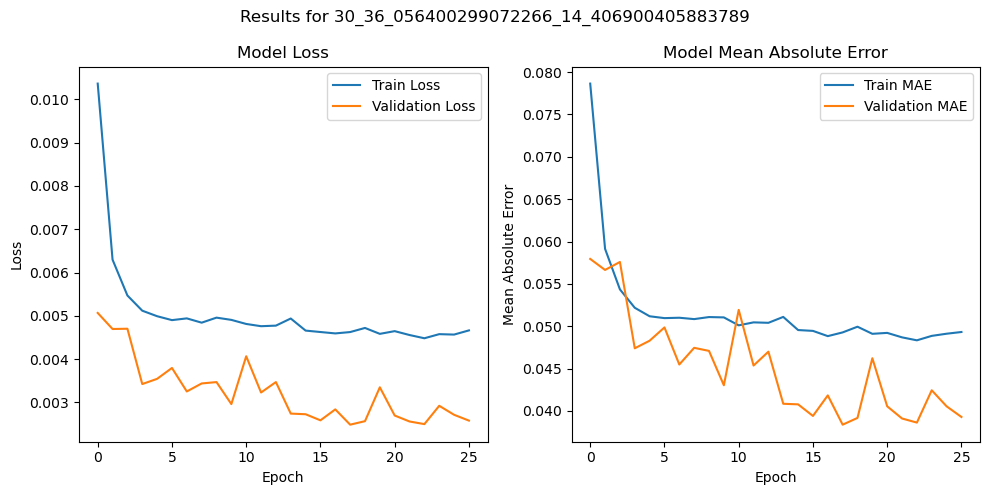

21/21 [==============================] - 11s 487ms/step

Test set Evaluation metrics for file: 30_36_056400299072266_14_406900405883789
Mean Squared Error (MSE): 0.0033331038630677818
Mean Absolute Error (MAE): 0.042206995567780466
Root Mean Squared Error (RMSE): 0.05773303961396612



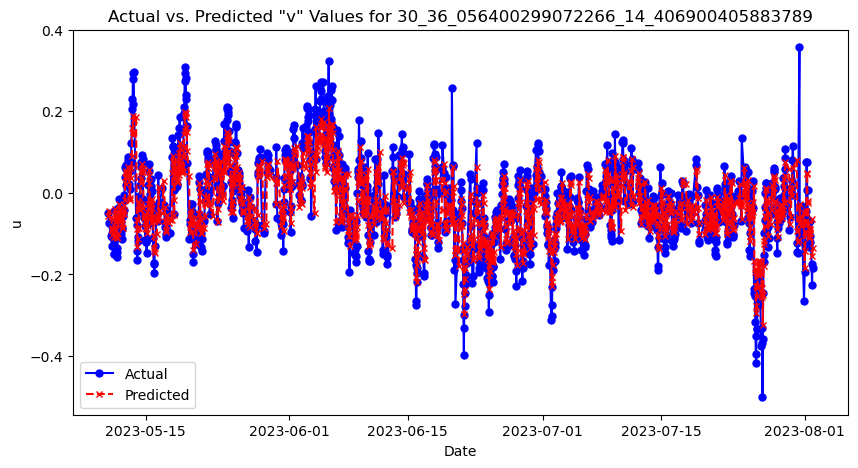

Model tarining & evaluation completed for file: 30_36_056400299072266_14_406900405883789.csv

Processing file: 31_36_01190185546875_14_406900405883789.csv

Epoch 1/100
66/66 [==============================] - ETA: 0s - loss: 0.0193 - mean_absolute_error: 0.1039INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\31_36_01190185546875_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\31_36_01190185546875_14_406900405883789\assets


66/66 [==============================] - 176s 3s/step - loss: 0.0193 - mean_absolute_error: 0.1039 - val_loss: 0.0096 - val_mean_absolute_error: 0.0717
Epoch 2/100
66/66 [==============================] - ETA: 0s - loss: 0.0156 - mean_absolute_error: 0.0934INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\31_36_01190185546875_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\31_36_01190185546875_14_406900405883789\assets


66/66 [==============================] - 174s 3s/step - loss: 0.0156 - mean_absolute_error: 0.0934 - val_loss: 0.0085 - val_mean_absolute_error: 0.0681
Epoch 3/100
66/66 [==============================] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0854INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\31_36_01190185546875_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\31_36_01190185546875_14_406900405883789\assets


66/66 [==============================] - 176s 3s/step - loss: 0.0135 - mean_absolute_error: 0.0854 - val_loss: 0.0070 - val_mean_absolute_error: 0.0581
Epoch 4/100
66/66 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0792INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\31_36_01190185546875_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\31_36_01190185546875_14_406900405883789\assets


66/66 [==============================] - 175s 3s/step - loss: 0.0117 - mean_absolute_error: 0.0792 - val_loss: 0.0068 - val_mean_absolute_error: 0.0576
Epoch 5/100
66/66 [==============================] - ETA: 0s - loss: 0.0116 - mean_absolute_error: 0.0789INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\31_36_01190185546875_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\31_36_01190185546875_14_406900405883789\assets


66/66 [==============================] - 175s 3s/step - loss: 0.0116 - mean_absolute_error: 0.0789 - val_loss: 0.0066 - val_mean_absolute_error: 0.0569
Epoch 6/100
66/66 [==============================] - 169s 3s/step - loss: 0.0111 - mean_absolute_error: 0.0768 - val_loss: 0.0068 - val_mean_absolute_error: 0.0576
Epoch 7/100
66/66 [==============================] - 169s 3s/step - loss: 0.0111 - mean_absolute_error: 0.0765 - val_loss: 0.0069 - val_mean_absolute_error: 0.0586
Epoch 8/100
66/66 [==============================] - 169s 3s/step - loss: 0.0109 - mean_absolute_error: 0.0758 - val_loss: 0.0068 - val_mean_absolute_error: 0.0583
Epoch 9/100
66/66 [==============================] - 169s 3s/step - loss: 0.0108 - mean_absolute_error: 0.0759 - val_loss: 0.0066 - val_mean_absolute_error: 0.0567
Epoch 10/100
66/66 [==============================] - 171s 3s/step - loss: 0.0107 - mean_absolute_error: 0.0750 - val_loss: 0.0066 - val_mean_absolute_error: 0.0567
Epoch 11/100
66/66 [=======

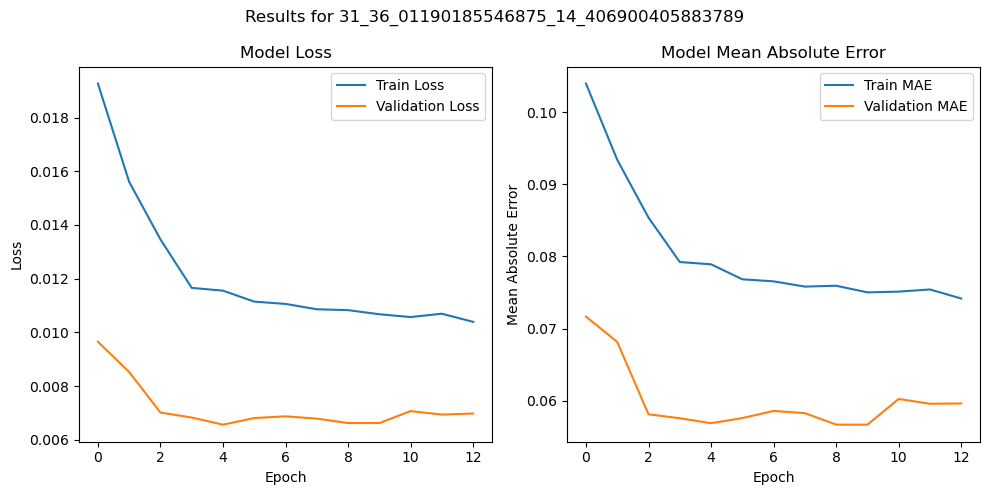

14/14 [==============================] - 7s 465ms/step

Test set Evaluation metrics for file: 31_36_01190185546875_14_406900405883789
Mean Squared Error (MSE): 0.0070613172091339325
Mean Absolute Error (MAE): 0.061519164545955636
Root Mean Squared Error (RMSE): 0.08403164409395981



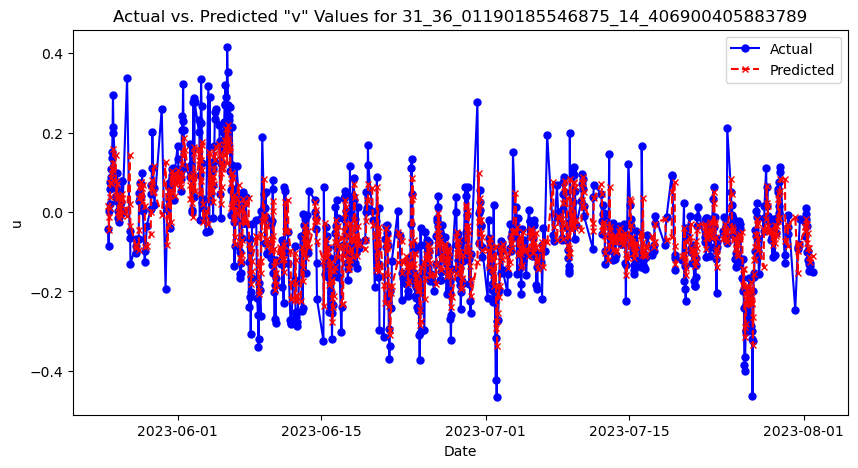

Model tarining & evaluation completed for file: 31_36_01190185546875_14_406900405883789.csv

Processing file: 32_36_03409957885742_14_366399765014648.csv

Epoch 1/100
67/67 [==============================] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0813INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\32_36_03409957885742_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\32_36_03409957885742_14_366399765014648\assets


67/67 [==============================] - 180s 3s/step - loss: 0.0111 - mean_absolute_error: 0.0813 - val_loss: 0.0064 - val_mean_absolute_error: 0.0632
Epoch 2/100
67/67 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0727INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\32_36_03409957885742_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\32_36_03409957885742_14_366399765014648\assets


67/67 [==============================] - 177s 3s/step - loss: 0.0092 - mean_absolute_error: 0.0727 - val_loss: 0.0051 - val_mean_absolute_error: 0.0568
Epoch 3/100
67/67 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0653INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\32_36_03409957885742_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\32_36_03409957885742_14_366399765014648\assets


67/67 [==============================] - 178s 3s/step - loss: 0.0079 - mean_absolute_error: 0.0653 - val_loss: 0.0040 - val_mean_absolute_error: 0.0482
Epoch 4/100
67/67 [==============================] - 171s 3s/step - loss: 0.0076 - mean_absolute_error: 0.0635 - val_loss: 0.0045 - val_mean_absolute_error: 0.0521
Epoch 5/100
67/67 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0629INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\32_36_03409957885742_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\32_36_03409957885742_14_366399765014648\assets


67/67 [==============================] - 180s 3s/step - loss: 0.0074 - mean_absolute_error: 0.0629 - val_loss: 0.0039 - val_mean_absolute_error: 0.0477
Epoch 6/100
67/67 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0627INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\32_36_03409957885742_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\32_36_03409957885742_14_366399765014648\assets


67/67 [==============================] - 176s 3s/step - loss: 0.0074 - mean_absolute_error: 0.0627 - val_loss: 0.0035 - val_mean_absolute_error: 0.0442
Epoch 7/100
67/67 [==============================] - 173s 3s/step - loss: 0.0075 - mean_absolute_error: 0.0629 - val_loss: 0.0039 - val_mean_absolute_error: 0.0475
Epoch 8/100
67/67 [==============================] - 171s 3s/step - loss: 0.0075 - mean_absolute_error: 0.0627 - val_loss: 0.0037 - val_mean_absolute_error: 0.0458
Epoch 9/100
67/67 [==============================] - 172s 3s/step - loss: 0.0073 - mean_absolute_error: 0.0615 - val_loss: 0.0039 - val_mean_absolute_error: 0.0480
Epoch 10/100
67/67 [==============================] - 173s 3s/step - loss: 0.0072 - mean_absolute_error: 0.0612 - val_loss: 0.0037 - val_mean_absolute_error: 0.0460
Epoch 11/100
67/67 [==============================] - 172s 3s/step - loss: 0.0071 - mean_absolute_error: 0.0611 - val_loss: 0.0040 - val_mean_absolute_error: 0.0481
Epoch 12/100
67/67 [======

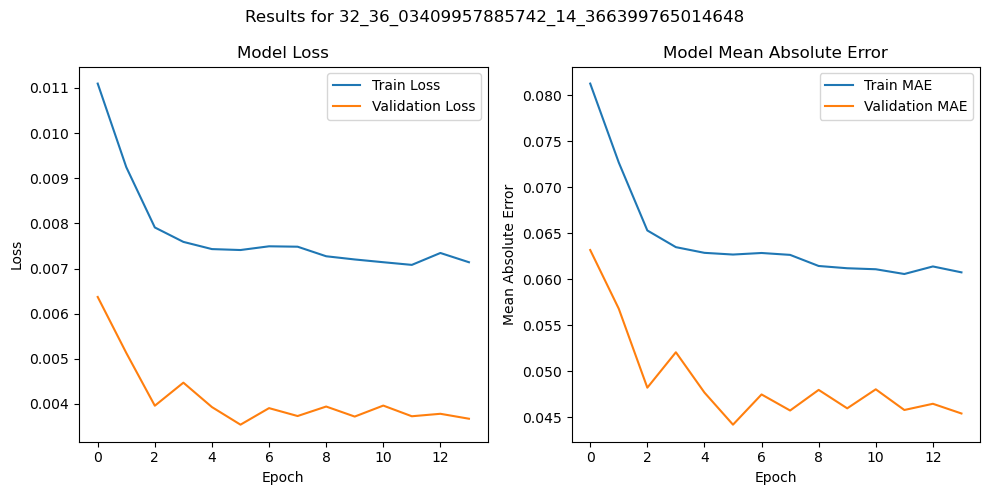

14/14 [==============================] - 7s 463ms/step

Test set Evaluation metrics for file: 32_36_03409957885742_14_366399765014648
Mean Squared Error (MSE): 0.004065760480775722
Mean Absolute Error (MAE): 0.04704192939424136
Root Mean Squared Error (RMSE): 0.06376331610554553



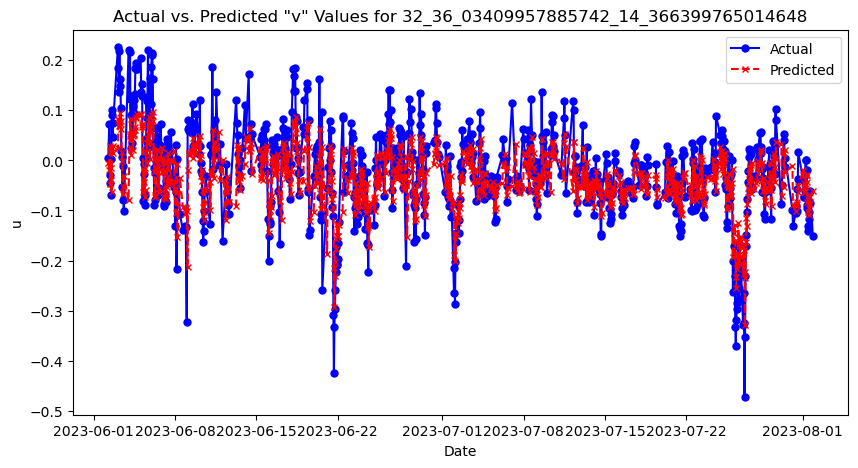

Model tarining & evaluation completed for file: 32_36_03409957885742_14_366399765014648.csv

Processing file: 33_36_056400299072266_14_366399765014648.csv

Epoch 1/100
69/69 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0649INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\33_36_056400299072266_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\33_36_056400299072266_14_366399765014648\assets


69/69 [==============================] - 184s 3s/step - loss: 0.0070 - mean_absolute_error: 0.0649 - val_loss: 0.0045 - val_mean_absolute_error: 0.0516
Epoch 2/100
69/69 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0578INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\33_36_056400299072266_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\33_36_056400299072266_14_366399765014648\assets


69/69 [==============================] - 181s 3s/step - loss: 0.0057 - mean_absolute_error: 0.0578 - val_loss: 0.0036 - val_mean_absolute_error: 0.0478
Epoch 3/100
69/69 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0500INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\33_36_056400299072266_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\33_36_056400299072266_14_366399765014648\assets


69/69 [==============================] - 176s 3s/step - loss: 0.0045 - mean_absolute_error: 0.0500 - val_loss: 0.0028 - val_mean_absolute_error: 0.0402
Epoch 4/100
69/69 [==============================] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.0464INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\33_36_056400299072266_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\33_36_056400299072266_14_366399765014648\assets


69/69 [==============================] - 176s 3s/step - loss: 0.0040 - mean_absolute_error: 0.0464 - val_loss: 0.0026 - val_mean_absolute_error: 0.0375
Epoch 5/100
69/69 [==============================] - 171s 2s/step - loss: 0.0039 - mean_absolute_error: 0.0458 - val_loss: 0.0027 - val_mean_absolute_error: 0.0392
Epoch 6/100
69/69 [==============================] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0452INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\33_36_056400299072266_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\33_36_056400299072266_14_366399765014648\assets


69/69 [==============================] - 176s 3s/step - loss: 0.0038 - mean_absolute_error: 0.0452 - val_loss: 0.0024 - val_mean_absolute_error: 0.0358
Epoch 7/100
69/69 [==============================] - 173s 3s/step - loss: 0.0036 - mean_absolute_error: 0.0434 - val_loss: 0.0026 - val_mean_absolute_error: 0.0384
Epoch 8/100
69/69 [==============================] - 171s 2s/step - loss: 0.0037 - mean_absolute_error: 0.0444 - val_loss: 0.0025 - val_mean_absolute_error: 0.0372
Epoch 9/100
69/69 [==============================] - 172s 2s/step - loss: 0.0038 - mean_absolute_error: 0.0443 - val_loss: 0.0026 - val_mean_absolute_error: 0.0379
Epoch 10/100
69/69 [==============================] - 172s 2s/step - loss: 0.0037 - mean_absolute_error: 0.0437 - val_loss: 0.0027 - val_mean_absolute_error: 0.0385
Epoch 11/100
69/69 [==============================] - 172s 2s/step - loss: 0.0037 - mean_absolute_error: 0.0440 - val_loss: 0.0029 - val_mean_absolute_error: 0.0408
Epoch 12/100
69/69 [======

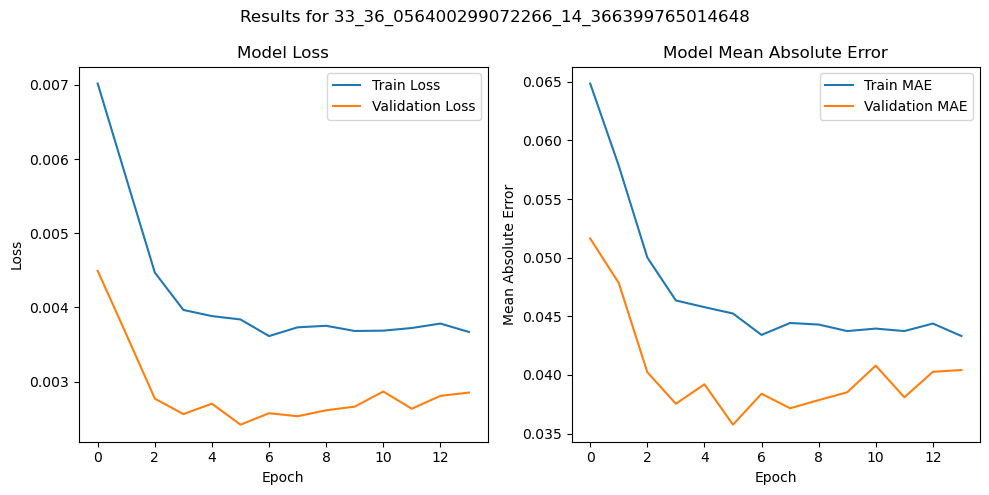

14/14 [==============================] - 7s 465ms/step

Test set Evaluation metrics for file: 33_36_056400299072266_14_366399765014648
Mean Squared Error (MSE): 0.002866018305019161
Mean Absolute Error (MAE): 0.039630931238795034
Root Mean Squared Error (RMSE): 0.05353520622001153



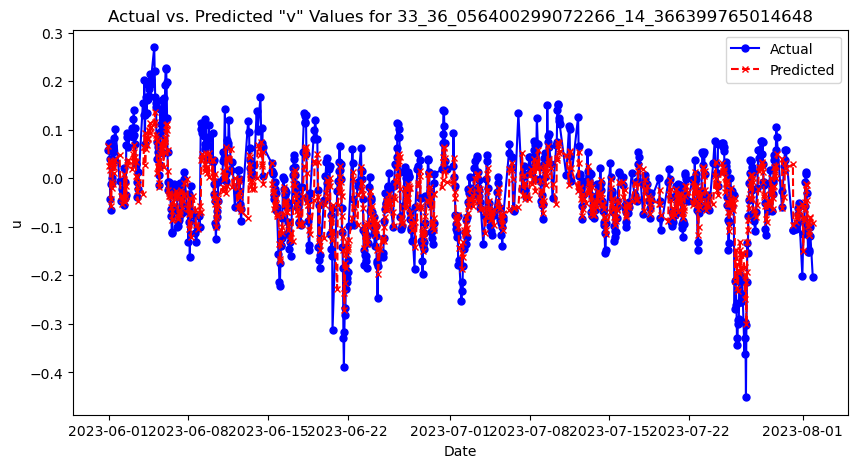

Model tarining & evaluation completed for file: 33_36_056400299072266_14_366399765014648.csv

Processing file: 34_35_96730041503906_14_48799991607666.csv

Epoch 1/100
56/56 [==============================] - ETA: 0s - loss: 0.0171 - mean_absolute_error: 0.1022INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\34_35_96730041503906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\34_35_96730041503906_14_48799991607666\assets


56/56 [==============================] - 149s 3s/step - loss: 0.0171 - mean_absolute_error: 0.1022 - val_loss: 0.0157 - val_mean_absolute_error: 0.0991
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.0789INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\34_35_96730041503906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\34_35_96730041503906_14_48799991607666\assets


56/56 [==============================] - 145s 3s/step - loss: 0.0109 - mean_absolute_error: 0.0789 - val_loss: 0.0099 - val_mean_absolute_error: 0.0766
Epoch 3/100
56/56 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0681INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\34_35_96730041503906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\34_35_96730041503906_14_48799991607666\assets


56/56 [==============================] - 148s 3s/step - loss: 0.0086 - mean_absolute_error: 0.0681 - val_loss: 0.0081 - val_mean_absolute_error: 0.0689
Epoch 4/100
56/56 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\34_35_96730041503906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\34_35_96730041503906_14_48799991607666\assets


56/56 [==============================] - 151s 3s/step - loss: 0.0071 - mean_absolute_error: 0.0602 - val_loss: 0.0074 - val_mean_absolute_error: 0.0656
Epoch 5/100
56/56 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0586INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\34_35_96730041503906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\34_35_96730041503906_14_48799991607666\assets


56/56 [==============================] - 153s 3s/step - loss: 0.0069 - mean_absolute_error: 0.0586 - val_loss: 0.0069 - val_mean_absolute_error: 0.0625
Epoch 6/100
56/56 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0582INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\34_35_96730041503906_14_48799991607666\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\34_35_96730041503906_14_48799991607666\assets


56/56 [==============================] - 151s 3s/step - loss: 0.0066 - mean_absolute_error: 0.0582 - val_loss: 0.0064 - val_mean_absolute_error: 0.0600
Epoch 7/100
56/56 [==============================] - 147s 3s/step - loss: 0.0065 - mean_absolute_error: 0.0570 - val_loss: 0.0070 - val_mean_absolute_error: 0.0635
Epoch 8/100
56/56 [==============================] - 148s 3s/step - loss: 0.0064 - mean_absolute_error: 0.0573 - val_loss: 0.0070 - val_mean_absolute_error: 0.0632
Epoch 9/100
56/56 [==============================] - 146s 3s/step - loss: 0.0063 - mean_absolute_error: 0.0560 - val_loss: 0.0067 - val_mean_absolute_error: 0.0618
Epoch 10/100
56/56 [==============================] - 148s 3s/step - loss: 0.0061 - mean_absolute_error: 0.0547 - val_loss: 0.0066 - val_mean_absolute_error: 0.0615
Epoch 11/100
56/56 [==============================] - 146s 3s/step - loss: 0.0060 - mean_absolute_error: 0.0546 - val_loss: 0.0086 - val_mean_absolute_error: 0.0719
Epoch 12/100
56/56 [======

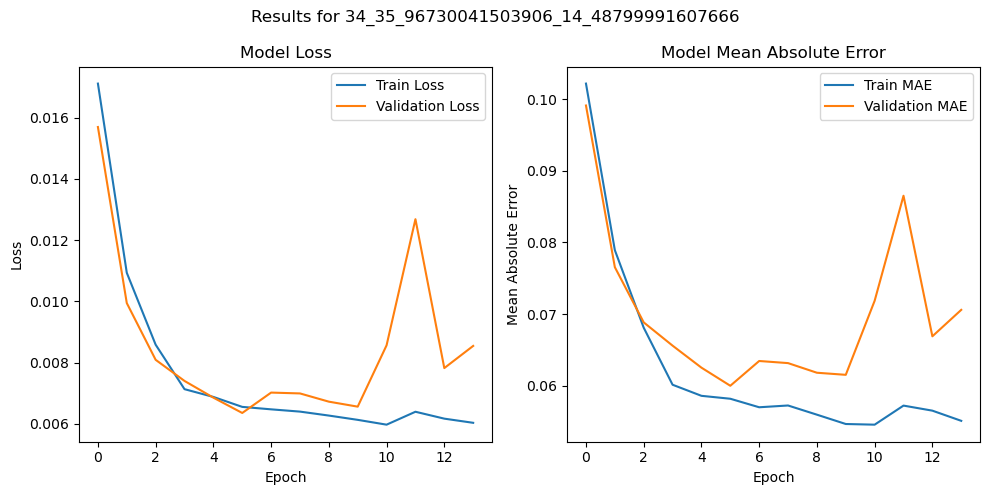

12/12 [==============================] - 6s 477ms/step

Test set Evaluation metrics for file: 34_35_96730041503906_14_48799991607666
Mean Squared Error (MSE): 0.004577800458089039
Mean Absolute Error (MAE): 0.049242670741304735
Root Mean Squared Error (RMSE): 0.06765944470721762



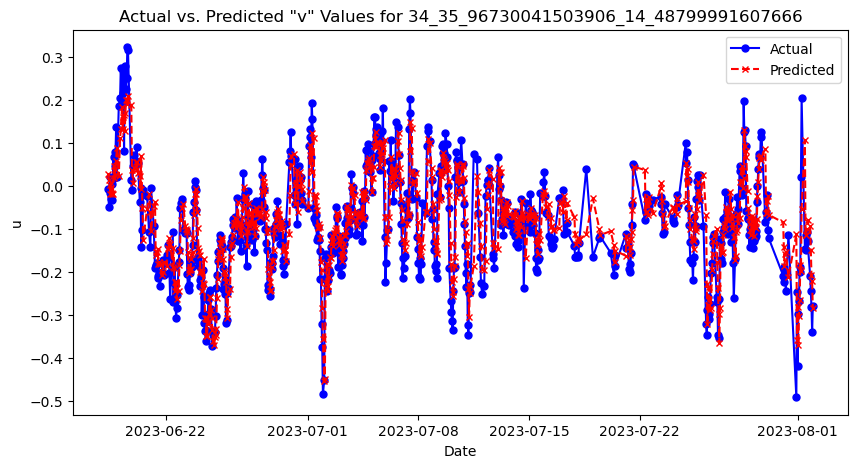

Model tarining & evaluation completed for file: 34_35_96730041503906_14_48799991607666.csv

Processing file: 35_35_989601135253906_14_406900405883789.csv

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 0.0205 - mean_absolute_error: 0.1069INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\35_35_989601135253906_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\35_35_989601135253906_14_406900405883789\assets


27/27 [==============================] - 76s 3s/step - loss: 0.0205 - mean_absolute_error: 0.1069 - val_loss: 0.0237 - val_mean_absolute_error: 0.1177
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 0.0182 - mean_absolute_error: 0.0990INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\35_35_989601135253906_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\35_35_989601135253906_14_406900405883789\assets


27/27 [==============================] - 74s 3s/step - loss: 0.0182 - mean_absolute_error: 0.0990 - val_loss: 0.0230 - val_mean_absolute_error: 0.1156
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 0.0168 - mean_absolute_error: 0.0939INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\35_35_989601135253906_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\35_35_989601135253906_14_406900405883789\assets


27/27 [==============================] - 74s 3s/step - loss: 0.0168 - mean_absolute_error: 0.0939 - val_loss: 0.0213 - val_mean_absolute_error: 0.1097
Epoch 4/100
27/27 [==============================] - ETA: 0s - loss: 0.0155 - mean_absolute_error: 0.0892INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\35_35_989601135253906_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\35_35_989601135253906_14_406900405883789\assets


27/27 [==============================] - 73s 3s/step - loss: 0.0155 - mean_absolute_error: 0.0892 - val_loss: 0.0196 - val_mean_absolute_error: 0.1042
Epoch 5/100
27/27 [==============================] - ETA: 0s - loss: 0.0145 - mean_absolute_error: 0.0863INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\35_35_989601135253906_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\35_35_989601135253906_14_406900405883789\assets


27/27 [==============================] - 73s 3s/step - loss: 0.0145 - mean_absolute_error: 0.0863 - val_loss: 0.0195 - val_mean_absolute_error: 0.1028
Epoch 6/100
27/27 [==============================] - ETA: 0s - loss: 0.0132 - mean_absolute_error: 0.0818INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\35_35_989601135253906_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\35_35_989601135253906_14_406900405883789\assets


27/27 [==============================] - 73s 3s/step - loss: 0.0132 - mean_absolute_error: 0.0818 - val_loss: 0.0182 - val_mean_absolute_error: 0.0980
Epoch 7/100
27/27 [==============================] - 68s 3s/step - loss: 0.0134 - mean_absolute_error: 0.0831 - val_loss: 0.0186 - val_mean_absolute_error: 0.0993
Epoch 8/100
27/27 [==============================] - 68s 3s/step - loss: 0.0133 - mean_absolute_error: 0.0821 - val_loss: 0.0200 - val_mean_absolute_error: 0.1051
Epoch 9/100
27/27 [==============================] - 68s 3s/step - loss: 0.0135 - mean_absolute_error: 0.0827 - val_loss: 0.0189 - val_mean_absolute_error: 0.1006
Epoch 10/100
27/27 [==============================] - 68s 3s/step - loss: 0.0135 - mean_absolute_error: 0.0818 - val_loss: 0.0192 - val_mean_absolute_error: 0.1008
Epoch 11/100
27/27 [==============================] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0813INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\35_35_989601135253906_14

INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\35_35_989601135253906_14_406900405883789\assets


27/27 [==============================] - 73s 3s/step - loss: 0.0130 - mean_absolute_error: 0.0813 - val_loss: 0.0177 - val_mean_absolute_error: 0.0952
Epoch 12/100
27/27 [==============================] - 68s 2s/step - loss: 0.0130 - mean_absolute_error: 0.0803 - val_loss: 0.0179 - val_mean_absolute_error: 0.0957
Epoch 13/100
27/27 [==============================] - 70s 3s/step - loss: 0.0133 - mean_absolute_error: 0.0816 - val_loss: 0.0189 - val_mean_absolute_error: 0.0998
Epoch 14/100
27/27 [==============================] - 67s 2s/step - loss: 0.0134 - mean_absolute_error: 0.0822 - val_loss: 0.0183 - val_mean_absolute_error: 0.0975
Epoch 15/100
27/27 [==============================] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0816INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\35_35_989601135253906_14_406900405883789\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\35_35_989601135253906_14_406900405883789\assets


27/27 [==============================] - 73s 3s/step - loss: 0.0133 - mean_absolute_error: 0.0816 - val_loss: 0.0177 - val_mean_absolute_error: 0.0953
Epoch 16/100
27/27 [==============================] - 70s 3s/step - loss: 0.0133 - mean_absolute_error: 0.0805 - val_loss: 0.0191 - val_mean_absolute_error: 0.1001
Epoch 17/100
27/27 [==============================] - 69s 3s/step - loss: 0.0132 - mean_absolute_error: 0.0813 - val_loss: 0.0192 - val_mean_absolute_error: 0.1009
Epoch 18/100
27/27 [==============================] - 69s 3s/step - loss: 0.0133 - mean_absolute_error: 0.0821 - val_loss: 0.0187 - val_mean_absolute_error: 0.0986
Epoch 19/100
27/27 [==============================] - 69s 3s/step - loss: 0.0130 - mean_absolute_error: 0.0796 - val_loss: 0.0182 - val_mean_absolute_error: 0.0962
Epoch 20/100
27/27 [==============================] - 69s 3s/step - loss: 0.0126 - mean_absolute_error: 0.0793 - val_loss: 0.0196 - val_mean_absolute_error: 0.1021
Epoch 21/100
27/27 [=========

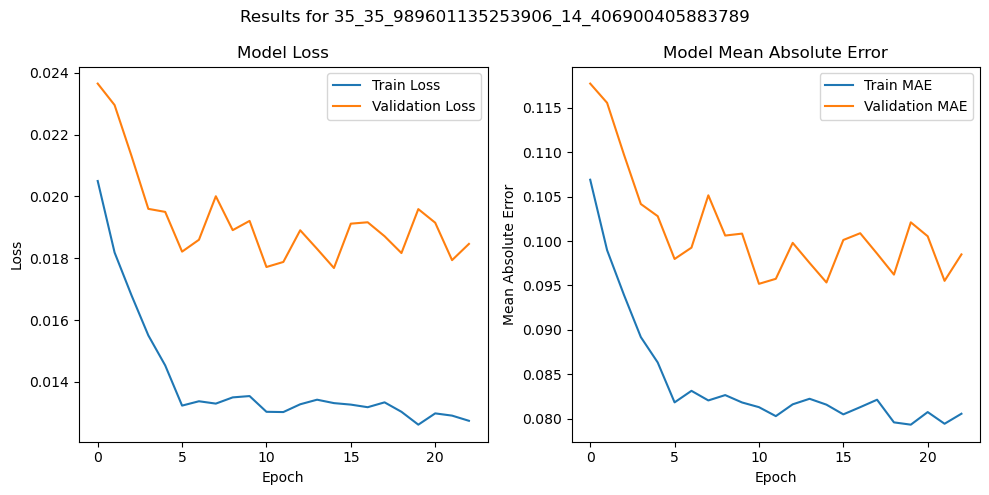

5/5 [==============================] - 4s 442ms/step

Test set Evaluation metrics for file: 35_35_989601135253906_14_406900405883789
Mean Squared Error (MSE): 0.006803006366716875
Mean Absolute Error (MAE): 0.057213318921852094
Root Mean Squared Error (RMSE): 0.08248033927377406



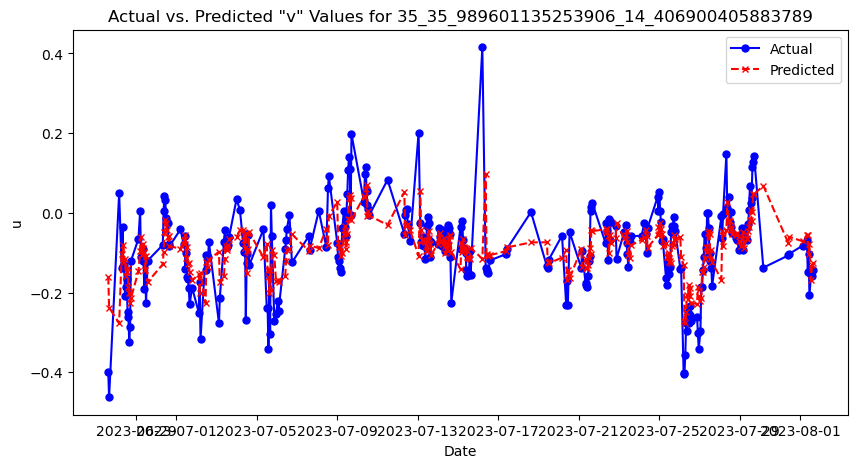

Model tarining & evaluation completed for file: 35_35_989601135253906_14_406900405883789.csv

Processing file: 36_36_01190185546875_14_366399765014648.csv

Epoch 1/100
29/29 [==============================] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.0861INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\36_36_01190185546875_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\36_36_01190185546875_14_366399765014648\assets


29/29 [==============================] - 79s 3s/step - loss: 0.0125 - mean_absolute_error: 0.0861 - val_loss: 0.0131 - val_mean_absolute_error: 0.0890
Epoch 2/100
29/29 [==============================] - ETA: 0s - loss: 0.0116 - mean_absolute_error: 0.0824INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\36_36_01190185546875_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\36_36_01190185546875_14_366399765014648\assets


29/29 [==============================] - 75s 3s/step - loss: 0.0116 - mean_absolute_error: 0.0824 - val_loss: 0.0130 - val_mean_absolute_error: 0.0885
Epoch 3/100
29/29 [==============================] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0786INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\36_36_01190185546875_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\36_36_01190185546875_14_366399765014648\assets


29/29 [==============================] - 75s 3s/step - loss: 0.0108 - mean_absolute_error: 0.0786 - val_loss: 0.0117 - val_mean_absolute_error: 0.0841
Epoch 4/100
29/29 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.0754INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\36_36_01190185546875_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\36_36_01190185546875_14_366399765014648\assets


29/29 [==============================] - 77s 3s/step - loss: 0.0099 - mean_absolute_error: 0.0754 - val_loss: 0.0106 - val_mean_absolute_error: 0.0800
Epoch 5/100
29/29 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0724INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\36_36_01190185546875_14_366399765014648\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\36_36_01190185546875_14_366399765014648\assets


29/29 [==============================] - 79s 3s/step - loss: 0.0092 - mean_absolute_error: 0.0724 - val_loss: 0.0095 - val_mean_absolute_error: 0.0747
Epoch 6/100
29/29 [==============================] - 76s 3s/step - loss: 0.0089 - mean_absolute_error: 0.0698 - val_loss: 0.0099 - val_mean_absolute_error: 0.0762
Epoch 7/100
29/29 [==============================] - 77s 3s/step - loss: 0.0087 - mean_absolute_error: 0.0693 - val_loss: 0.0097 - val_mean_absolute_error: 0.0754
Epoch 8/100
29/29 [==============================] - 76s 3s/step - loss: 0.0086 - mean_absolute_error: 0.0675 - val_loss: 0.0096 - val_mean_absolute_error: 0.0749
Epoch 9/100
29/29 [==============================] - 76s 3s/step - loss: 0.0085 - mean_absolute_error: 0.0677 - val_loss: 0.0099 - val_mean_absolute_error: 0.0759
Epoch 10/100
29/29 [==============================] - 76s 3s/step - loss: 0.0085 - mean_absolute_error: 0.0679 - val_loss: 0.0097 - val_mean_absolute_error: 0.0753
Epoch 11/100
29/29 [=============

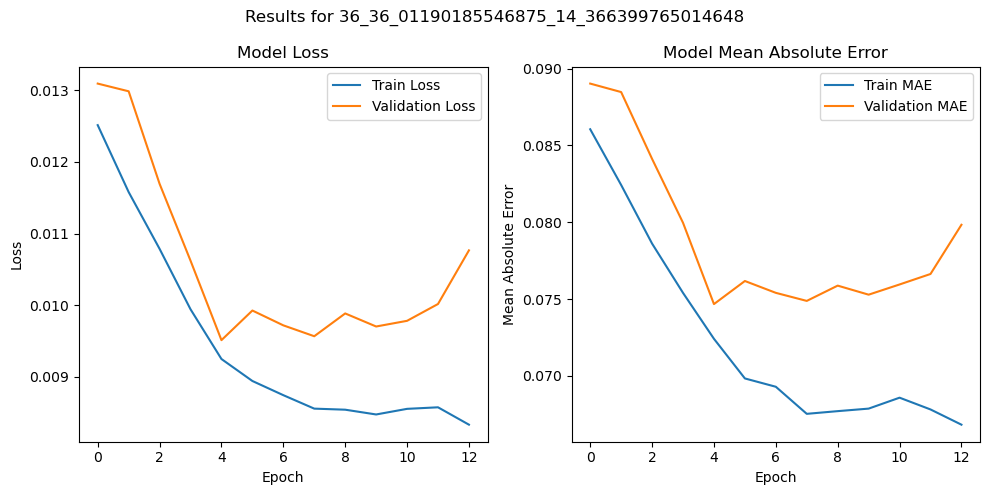

6/6 [==============================] - 3s 453ms/step

Test set Evaluation metrics for file: 36_36_01190185546875_14_366399765014648
Mean Squared Error (MSE): 0.004708456691054346
Mean Absolute Error (MAE): 0.048857878319749436
Root Mean Squared Error (RMSE): 0.06861819504369338



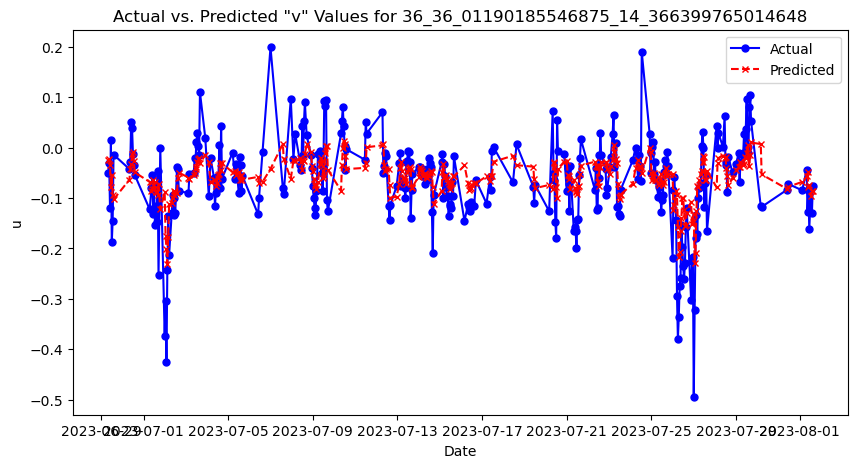

Model tarining & evaluation completed for file: 36_36_01190185546875_14_366399765014648.csv

Processing file: 37_35_96730041503906_14_447500228881836.csv

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.1414INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\37_35_96730041503906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\37_35_96730041503906_14_447500228881836\assets


21/21 [==============================] - 60s 3s/step - loss: 0.0323 - mean_absolute_error: 0.1414 - val_loss: 0.0309 - val_mean_absolute_error: 0.1393
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.0275 - mean_absolute_error: 0.1281INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\37_35_96730041503906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\37_35_96730041503906_14_447500228881836\assets


21/21 [==============================] - 56s 3s/step - loss: 0.0275 - mean_absolute_error: 0.1281 - val_loss: 0.0305 - val_mean_absolute_error: 0.1402
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.0247 - mean_absolute_error: 0.1204INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\37_35_96730041503906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\37_35_96730041503906_14_447500228881836\assets


21/21 [==============================] - 56s 3s/step - loss: 0.0247 - mean_absolute_error: 0.1204 - val_loss: 0.0233 - val_mean_absolute_error: 0.1172
Epoch 4/100
21/21 [==============================] - ETA: 0s - loss: 0.0224 - mean_absolute_error: 0.1131INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\37_35_96730041503906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\37_35_96730041503906_14_447500228881836\assets


21/21 [==============================] - 61s 3s/step - loss: 0.0224 - mean_absolute_error: 0.1131 - val_loss: 0.0213 - val_mean_absolute_error: 0.1114
Epoch 5/100
21/21 [==============================] - ETA: 0s - loss: 0.0201 - mean_absolute_error: 0.1055INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\37_35_96730041503906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\37_35_96730041503906_14_447500228881836\assets


21/21 [==============================] - 56s 3s/step - loss: 0.0201 - mean_absolute_error: 0.1055 - val_loss: 0.0188 - val_mean_absolute_error: 0.1042
Epoch 6/100
21/21 [==============================] - ETA: 0s - loss: 0.0185 - mean_absolute_error: 0.0989INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\37_35_96730041503906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\37_35_96730041503906_14_447500228881836\assets


21/21 [==============================] - 56s 3s/step - loss: 0.0185 - mean_absolute_error: 0.0989 - val_loss: 0.0175 - val_mean_absolute_error: 0.1002
Epoch 7/100
21/21 [==============================] - ETA: 0s - loss: 0.0188 - mean_absolute_error: 0.0989INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\37_35_96730041503906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\37_35_96730041503906_14_447500228881836\assets


21/21 [==============================] - 56s 3s/step - loss: 0.0188 - mean_absolute_error: 0.0989 - val_loss: 0.0168 - val_mean_absolute_error: 0.0948
Epoch 8/100
21/21 [==============================] - ETA: 0s - loss: 0.0181 - mean_absolute_error: 0.0970INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\37_35_96730041503906_14_447500228881836\assets


INFO:tensorflow:Assets written to: Data/saved_models/GRU/models_v\37_35_96730041503906_14_447500228881836\assets


21/21 [==============================] - 56s 3s/step - loss: 0.0181 - mean_absolute_error: 0.0970 - val_loss: 0.0165 - val_mean_absolute_error: 0.0950
Epoch 9/100
21/21 [==============================] - 52s 2s/step - loss: 0.0173 - mean_absolute_error: 0.0928 - val_loss: 0.0169 - val_mean_absolute_error: 0.0951
Epoch 10/100
21/21 [==============================] - 51s 2s/step - loss: 0.0174 - mean_absolute_error: 0.0948 - val_loss: 0.0174 - val_mean_absolute_error: 0.0984
Epoch 11/100
21/21 [==============================] - 51s 2s/step - loss: 0.0180 - mean_absolute_error: 0.0967 - val_loss: 0.0168 - val_mean_absolute_error: 0.0945
Epoch 12/100
21/21 [==============================] - 51s 2s/step - loss: 0.0171 - mean_absolute_error: 0.0935 - val_loss: 0.0166 - val_mean_absolute_error: 0.0938
Epoch 13/100
21/21 [==============================] - 51s 2s/step - loss: 0.0177 - mean_absolute_error: 0.0945 - val_loss: 0.0171 - val_mean_absolute_error: 0.0972
Epoch 14/100
21/21 [==========

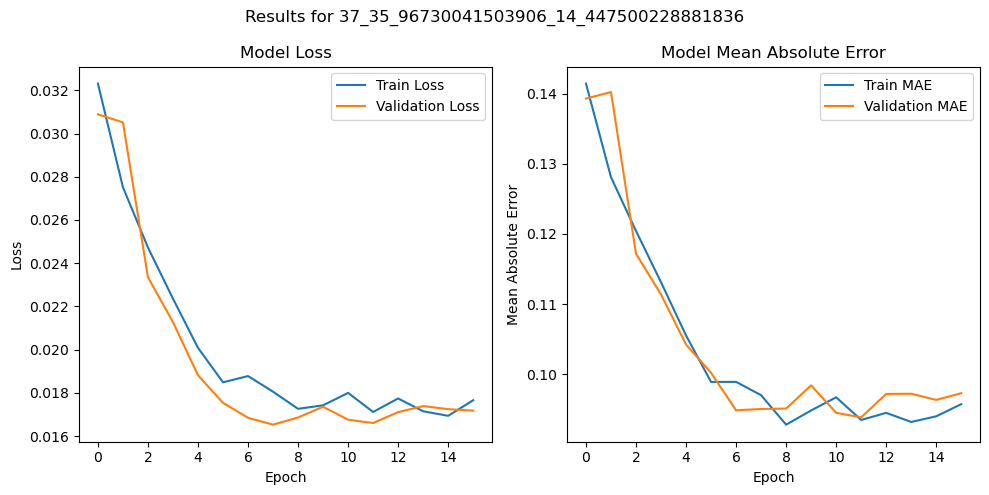

4/4 [==============================] - 2s 419ms/step

Test set Evaluation metrics for file: 37_35_96730041503906_14_447500228881836
Mean Squared Error (MSE): 0.00778105941150127
Mean Absolute Error (MAE): 0.05932880385642462
Root Mean Squared Error (RMSE): 0.08821031352115959



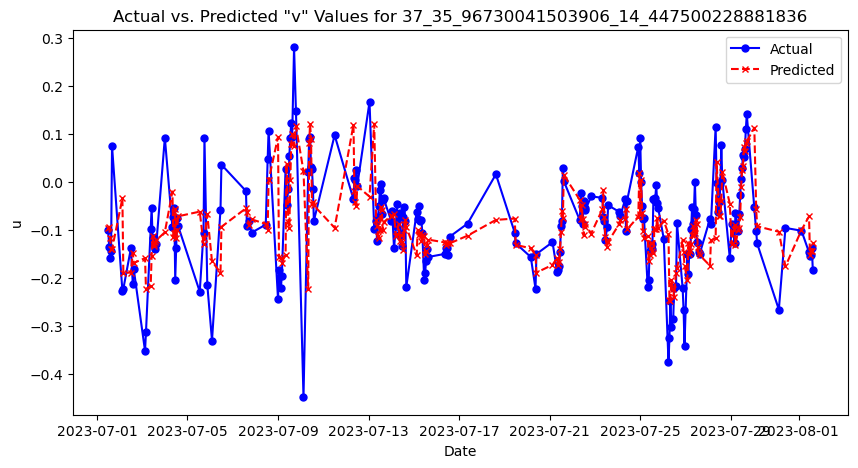

Model tarining & evaluation completed for file: 37_35_96730041503906_14_447500228881836.csv



In [10]:
# Directory for saving models 
model_save_directory = "Data/saved_models/GRU/models_v"
os.makedirs(model_save_directory, exist_ok=True)

# Function to extract the numerical index from the filename
def extract_index(filename):
    # Index is always before the first underscore
    index_part = filename.split("_")[0]
    try:
        return int(index_part)
    except ValueError:
        # In case of any error, return a large number to sort this file at the end
        return float('inf')

# List all CSV files in the directory and sort them numerically based on the index
csv_files = sorted([f for f in os.listdir(save_directory) if f.endswith('.csv')], key=extract_index)

print(csv_files,"\n")
print("="*175)

# Set up early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=8, 
                               mode='min', 
                               restore_best_weights=True)

# Loop through each CSV file in the directory
for file in csv_files:
    print("="*175)
    print(f"Processing file: {file}\n")

    # Load the dataset from the CSV file
    df = pd.read_csv(os.path.join(save_directory, file))

    # Convert the 'time' column to datetime object and set it as the index 
    df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)
    df.set_index('time', inplace=True)

    # Select 'u' and 'v' columns as input features 
    df_input = df[['u', 'v']]
    features = df_input.to_numpy()

    # Set the 'v' column as the target variable 
    target = df_input['v'].values

    # Splitting Data into Train, Validation, and Test sets (70-15-15 split)
    X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=123, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123, shuffle=False)

    # Time series generator parameters
    win_length = 72 # 3 Days
    batch_size = 64 # 64 samples per batch
    num_features = 2 # 'u' and 'v' columns

    # Creating the time series generators for the training, validation, and test sets
    train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
    val_generator = TimeseriesGenerator(X_val, y_val, length=win_length, sampling_rate=1, batch_size=batch_size)
    test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

    # Building the GRU Model Architecture
    model = Sequential([
        GRU(256, input_shape=(win_length, num_features), return_sequences=True),
        Dropout(0.3),
        GRU(128, return_sequences=True),
        Dropout(0.3),
        GRU(128, return_sequences=True),
        Dropout(0.3),
        GRU(64),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])

    # Compile the model 
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[MeanAbsoluteError()])

    # Define ModelCheckpoint callback to save the best model during training
    model_checkpoint = ModelCheckpoint(filepath=f"{model_save_directory}/{file[:-4]}",
                                       save_best_only=True, 
                                       monitor='val_loss', 
                                       mode='min', 
                                       save_format='tf',
                                       verbose=0)

    # Fit the model to the training data
    history = model.fit(train_generator, epochs=100, validation_data=val_generator, shuffle=False, callbacks=[early_stopping, model_checkpoint])

    # Determine the epoch number of best performance
    best_epoch = early_stopping.stopped_epoch - early_stopping.patience

    # Print the best epoch number and the best validation loss achieved
    print("="*175)
    print(f"Training stopped at epoch: {best_epoch + 1}")
    print(f"Best validation loss achieved at epoch: {best_epoch + 1}\n")

    # Plot training and validation loss values 
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot training and validation mean absolute error values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Train MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Display the plots 
    plt.suptitle(f'Results for {file[:-4]}')
    plt.tight_layout()
    plt.show()

    # Generate predictions for the test data 
    predictions = model.predict(test_generator)
    test_indexes = df.index[-len(predictions):]

    # Prepare the final DataFrame for plotting and analysis
    df_final = pd.DataFrame(df.loc[test_indexes])
    df_final['v_pred'] = predictions.flatten() 

   # Calculate evaluation metrics
    mse = mean_squared_error(df_final['v'], df_final['v_pred'])  
    mae = mean_absolute_error(df_final['v'], df_final['v_pred']) 
    rmse = np.sqrt(mse)

    # Print evaluation metrics
    print(f'\nTest set Evaluation metrics for file: {file[:-4]}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Root Mean Squared Error (RMSE): {rmse}\n')

    # Plot Actual vs. Predicted 'v' Values
    plt.figure(figsize=(10, 5))
    plt.plot(df_final.index, df_final['v'], label='Actual', color='blue', marker='o', linestyle='-', markersize=5)
    plt.plot(df_final.index, df_final['v_pred'], label='Predicted', color='red', marker='x', linestyle='--', markersize=5)
    plt.title(f'Actual vs. Predicted "v" Values for {file[:-4]}')  
    plt.xlabel('Date') 
    plt.ylabel('u')
    plt.legend()
    plt.show()
    
    print("="*175)
    print(f"Model tarining & evaluation completed for file: {file}")
    print("="*175, "\n")

---

## Making Real-life Predictions from Data (Simulation)
This section outlines the process of making predictions based on real-life data collected over a span of three days. The goal is to use data from the previous three days to simulate a prediction of the sea surface currents for the 4th of August 2023, demonstrating the application in real-world scenarios.

### Extract 3 Days of Inputs for Each Coordinate Pair

- **Data Loading**: Retrieve sea surface current data from August 1, 2023, to August 3, 2023, and load it.
- **Dataframe Conversion**: Transform the loaded NetCDF data into a pandas DataFrame.
- **Data Cleaning**: Remove unnecessary columns.
- **Data Organization**: Set up a directory specifically for storing the processed data files.
- **Data Processing**:
    - For each predefined pair of coordinates, isolate the data corresponding to that location.
    - Ensure the data is in order to maintain the sequence integrity.
    - Apply interpolation to fill in any missing 'u' and 'v' values, ensuring a continuous dataset.
- **File Saving**: Format latitude and longitude information for compatibility with filenames and save the individual data frames as seperate CSV files. Each file is uniquely named to correspond with its geographic location.

In [11]:
# Load the dataset (from August 1, 2023 till August 3, 2023) 
input_netcdf_path = "Data/model_IO/3_day_input_SSC_Data.nc"
dataset = xr.open_dataset(input_netcdf_path)

# Convert the dataset to a pandas DataFrame and reset the index
df = dataset.to_dataframe().reset_index()

# Drop columns from the DataFrame that are not needed
df = df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Directory to save the files 
input_data_directory = "Data/3_day_input_data_frames"
os.makedirs(input_data_directory, exist_ok=True)

# Loop through each pair of coordinates 
for index, (lon, lat) in enumerate(coordinates_inside, start=1):
    # Extract data for the specific coordinates and copy it
    df_specific = df[(df['lat'] == lat) & (df['lon'] == lon)].copy()

    # Ensure the DataFrame is sorted by time 
    df_specific.sort_values('time', inplace=True)

    # Interpolate NaN values using cubic spline interpolation
    df_specific.loc[:, ['u', 'v']] = df_specific[['u', 'v']].interpolate(method='spline', order=3)

    # After interpolation, if there are still NaNs at the beginning or the end, fill them in using the nearest value
    df_specific.loc[:, ['u', 'v']] = df_specific[['u', 'v']].fillna(method='bfill').fillna(method='ffill')

    # Replace decimal points with underscores in lat and lon for the filename
    lat_str = str(lat).replace('.', '_')
    lon_str = str(lon).replace('.', '_')

    # Save to CSV file with a unique filename
    filename = f"{index}_{lat_str}_{lon_str}_3_day.csv"
    filepath = os.path.join(input_data_directory, filename)
    df_specific.to_csv(filepath, index=False)
    print(f"Saved 3-day data for (lat: {lat}, lon: {lon}) as {filename}")
    
print("="*175)

Saved 3-day data for (lat: 35.90060043334961, lon: 14.569199562072754) as 1_35_90060043334961_14_569199562072754_3_day.csv
Saved 3-day data for (lat: 35.92279815673828, lon: 14.569199562072754) as 2_35_92279815673828_14_569199562072754_3_day.csv
Saved 3-day data for (lat: 35.945098876953125, lon: 14.569199562072754) as 3_35_945098876953125_14_569199562072754_3_day.csv
Saved 3-day data for (lat: 35.96730041503906, lon: 14.528599739074707) as 4_35_96730041503906_14_528599739074707_3_day.csv
Saved 3-day data for (lat: 35.96730041503906, lon: 14.569199562072754) as 5_35_96730041503906_14_569199562072754_3_day.csv
Saved 3-day data for (lat: 35.989601135253906, lon: 14.447500228881836) as 6_35_989601135253906_14_447500228881836_3_day.csv
Saved 3-day data for (lat: 35.989601135253906, lon: 14.48799991607666) as 7_35_989601135253906_14_48799991607666_3_day.csv
Saved 3-day data for (lat: 35.989601135253906, lon: 14.528599739074707) as 8_35_989601135253906_14_528599739074707_3_day.csv
Saved 3-da

### Extract 1 day of actaul data for each coordinate pair to use for comparison 

- **Data Loading**: Access actual sea surface current data for August 4th, 2023, to compare against the predictions.
- **Dataframe Conversion**: Transform the NetCDF data into a pandas DataFrame.
- **Data Cleaning**: Remove unnecessary columns.
- **File Organization**: Establish a directory specifically for storing actual data files.
- **Data Processing**:
    - For each predefined pair of coordinates, isolate the data corresponding to that location.
    - Sort this data to maintain the correct time sequence.
    - Fill in missing 'u' and 'v' data points using interpolation.
- **File Saving**: Adjust latitude and longitude information for filename compatibility and save the processed data frames as seperate CSV files. Each file is distinctly named according to its geographic location.

In [12]:
# Load the dataset for the next day (August 4th, 2023) 
actual_netcdf_path = "Data/model_IO/1_day_actual_4th_SSC_Data.nc"
actual_dataset = xr.open_dataset(actual_netcdf_path)

# Convert the dataset to a pandas DataFrame and reset index
actual_df = actual_dataset.to_dataframe().reset_index()

# Drop columns from the DataFrame that are not needed
actual_df = actual_df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Directory to save the files
actual_data_directory = "Data/1_day_actual_data_frames"
os.makedirs(actual_data_directory, exist_ok=True)

# Loop through each pair of coordinates
for index, (lon, lat) in enumerate(coordinates_inside, start=1):
    # Extract data for the specific coordinates and copy it
    actual_df_specific = actual_df[(actual_df['lat'] == lat) & (actual_df['lon'] == lon)].copy()

    # Ensure the DataFrame is sorted by time
    actual_df_specific.sort_values('time', inplace=True)

    # Check if there are enough non-NaN values to apply cubic spline
    if actual_df_specific[['u', 'v']].count().min() >= 4:
        # Enough data points, use cubic spline
        actual_df_specific.loc[:, ['u', 'v']] = actual_df_specific[['u', 'v']].interpolate(method='spline', order=3)
    else:
        # Not enough data points, use linear interpolation
        actual_df_specific.loc[:, ['u', 'v']] = actual_df_specific[['u', 'v']].interpolate(method='linear')

    # Fill remaining NaNs at the beginning or end
    actual_df_specific.loc[:, ['u', 'v']] = actual_df_specific[['u', 'v']].fillna(method='bfill').fillna(method='ffill')
    
    # Replace decimal points with underscores in lat and lon for the filename
    lat_str = str(lat).replace('.', '_')
    lon_str = str(lon).replace('.', '_')

    # Save to CSV file with a unique filename
    filename = f"{index}_{lat_str}_{lon_str}_1_day.csv"
    filepath = os.path.join(actual_data_directory, filename)
    actual_df_specific.to_csv(filepath, index=False)
    print(f"Saved 1-day actual data for (lat: {lat}, lon: {lon}) as {filename}")

print("="*175)

Saved 1-day actual data for (lat: 35.90060043334961, lon: 14.569199562072754) as 1_35_90060043334961_14_569199562072754_1_day.csv
Saved 1-day actual data for (lat: 35.92279815673828, lon: 14.569199562072754) as 2_35_92279815673828_14_569199562072754_1_day.csv
Saved 1-day actual data for (lat: 35.945098876953125, lon: 14.569199562072754) as 3_35_945098876953125_14_569199562072754_1_day.csv
Saved 1-day actual data for (lat: 35.96730041503906, lon: 14.528599739074707) as 4_35_96730041503906_14_528599739074707_1_day.csv
Saved 1-day actual data for (lat: 35.96730041503906, lon: 14.569199562072754) as 5_35_96730041503906_14_569199562072754_1_day.csv
Saved 1-day actual data for (lat: 35.989601135253906, lon: 14.447500228881836) as 6_35_989601135253906_14_447500228881836_1_day.csv
Saved 1-day actual data for (lat: 35.989601135253906, lon: 14.48799991607666) as 7_35_989601135253906_14_48799991607666_1_day.csv
Saved 1-day actual data for (lat: 35.989601135253906, lon: 14.528599739074707) as 8_35

### Rolling Prediction for 24 hours

This section performs a series of rolling predictions, for a total of 24 hours, utilizing the previously trained models. 

- **Prediction Initialization**: Begin with an empty list to store outcomes from all models.
- **Prediction Span**: Set the forecast length to 24 hours (1 day).
- **Model Access**: Locate all saved GRU models from the designated storage directory.
- **Iterative Forecasting**: For each saved model:
    - Retrieve the model's unique identifier.
    - Load the GRU model.
    - Prepare input data derived from the preceding three days corresponding to each geographical location.
    - Execute sequential predictions where each hourly prediction informs the next, mirroring real-world forecasting scenarios. Specifically:
        - Utilize the model to forecast the next 'v' value based on the last 72 hours (3 days) of data.
        - Update the input feature set for the subsequent prediction by appending the newly predicted 'v' value while shifting the dataset forward by one hour, ensuring the model consistently receives fresh data reflecting the most recent conditions.
        - Importantly, while 'v' values are iteratively forecasted and updated, the 'u' values are directly drawn from the actual data for the corresponding hour, maintaining the model's contextual relevance to evolving environmental conditions.
- **Data Synchronization**: Align each prediction with actual data to evaluate the model's performance accurately.
    - Preprocess real data to match the model's input structure.
    - Record every hourly forecast alongside actual measurements for comparison.
- **Performance Metrics**: For each model, compute and report key metrics:
    - **MAE (Mean Absolute Error)**: Reflects the average magnitude of errors between predicted and actual values, irrespective of direction.
    - **MSE (Mean Squared Error)**: Emphasizes larger errors by squaring them, thus penalizing more significant discrepancies more severely.
    - **RMSE (Root Mean Squared Error)**: Provides error magnitude in the same units as the predicted values.
- **Result Compilation**: Aggregate all hourly predictions across all models and locations into a single DataFrame, creating a comprehensive overview of the forecasting performance.
- **Save Predictions**: Store the combined predictions as a CSV file.

In [13]:
# Initialize a list to collect the results of all predictions
all_predictions = []

# Number of hours to predict into the future
n_future_hours = 24  

# Specify the directory where saved models are stored
model_directory = "Data/saved_models/GRU/models_v"

# Retrieve and sort paths for all saved models within the specified directory based on the numerical index
model_paths = sorted(
    [os.path.join(model_directory, filename).replace("\\", "/") for filename in os.listdir(model_directory)],
    key=lambda x: extract_index(os.path.basename(x).split('.')[0])
)

# Iterate over each model to perform predictions
for model_path in model_paths:
    # Extract model identifier from the file name
    model_id = os.path.basename(model_path).split('.')[0]  
    
    print("="*175)
    print(f"Processing model: {model_id}")
    print("="*175, "\n")

    # Load the saved model from its path
    model = load_model(model_path)

    # Define paths for input data and actual comparison data
    input_data_path = os.path.join(input_data_directory, f"{model_id}_3_day.csv").replace("\\", "/")
    actual_data_path = os.path.join(actual_data_directory, f"{model_id}_1_day.csv").replace("\\", "/")

    # Load and preprocess input data from CSV file
    input_data_df = pd.read_csv(input_data_path)
    input_data_df['time'] = pd.to_datetime(input_data_df['time'])
    features = input_data_df[['u', 'v']].values[-win_length:].reshape(1, win_length, num_features)

    # Initialize a list to store predictions for each hour
    predictions_v = []  
    # Perform rolling predictions for the defined number of future hours
    for i in range(n_future_hours):
        # Predict the next 'v' value using the model
        current_prediction_v = model.predict(features, verbose=0)[0, 0]
        # Append the prediction to the list
        predictions_v.append(current_prediction_v)
        # Update the features for the next prediction step
        next_u_values = np.roll(features[0, :, 0], -1)
        # Update features array with new predictions and actual 'u' values
        features = np.column_stack((next_u_values, np.roll(features[0, :, 1], -1))).reshape(1, win_length, num_features)
        features[0, -1, 1] = current_prediction_v  

    # Load and preprocess actual data for comparison
    actual_data_df = pd.read_csv(actual_data_path)
    actual_data_df['time'] = pd.to_datetime(actual_data_df['time'])
    actual_v_values = actual_data_df['v'].values[:n_future_hours]  
    # Use the first row's lat and lon for location
    lat, lon = actual_data_df[['lat', 'lon']].values[0]  

    # Compile all predictions with their corresponding timestamps and locations
    for i, predicted_v in enumerate(predictions_v):  
        all_predictions.append([actual_data_df['time'].iloc[i], lat, lon, predicted_v])  

    # Calculate evaluation metrics 
    mae = mean_absolute_error(actual_v_values, predictions_v) 
    mse = mean_squared_error(actual_v_values, predictions_v)  
    rmse = np.sqrt(mse)

    # Display calculated metrics
    print(f"Metrics for model {model_id}:\nMAE = {mae}\nMSE = {mse}\nRMSE = {rmse}\n")

print("="*175)

# Convert the list of all predictions into a DataFrame
predictions_df = pd.DataFrame(all_predictions, columns=['time', 'lat', 'lon', 'v'])

# Save the compiled predictions to a CSV file
predictions_df.to_csv("Data/model_IO/GRU/GRU_merged_predictions_v.csv", index=False)
print("Saved merged predictions to 'Data/model_IO/GRU/GRU_merged_predictions_v.csv'")
print("="*175)

Processing model: 1_35_90060043334961_14_569199562072754

Metrics for model 1_35_90060043334961_14_569199562072754:
MAE = 0.37341085434002186
MSE = 0.20993729082983456
RMSE = 0.45818914307285213

Processing model: 2_35_92279815673828_14_569199562072754

Metrics for model 2_35_92279815673828_14_569199562072754:
MAE = 0.46694271712186125
MSE = 0.3355771705121002
RMSE = 0.5792902299470449

Processing model: 3_35_945098876953125_14_569199562072754

Metrics for model 3_35_945098876953125_14_569199562072754:
MAE = 0.2762695375159209
MSE = 0.11802170037388271
RMSE = 0.3435428654096643

Processing model: 4_35_96730041503906_14_528599739074707

Metrics for model 4_35_96730041503906_14_528599739074707:
MAE = 0.37327226664489466
MSE = 0.2097746982659731
RMSE = 0.4580116791807531

Processing model: 5_35_96730041503906_14_569199562072754

Metrics for model 5_35_96730041503906_14_569199562072754:
MAE = 0.3567190461620555
MSE = 0.1958442099861241
RMSE = 0.4425428905610439

Processing model: 6_35_9896

---